In [1]:
!nvidia-smi

Sun Mar  3 20:59:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   33C    P8              15W / 215W |    584MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [9]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [10]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M13sinc as M13

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m14sinc_window.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M14sinc', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [18]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                             | 0.003278688524590164/10 [00:00<33:35, 201.58s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.446156
Mem before-during-after: 1907712 3951596544 31079424


  1%|█▎                                                                                            | 0.13442622950819672/10 [00:16<19:03, 115.94s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.399192
Mem before-during-after: 31961088 3965731840 31961088


  3%|██▍                                                                                           | 0.26557377049180286/10 [00:30<18:26, 113.69s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.169584
Mem before-during-after: 32842752 3967828992 31961088


  4%|███▊                                                                                             | 0.39672131147541/10 [00:46<18:07, 113.21s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.172737
Mem before-during-after: 31961088 3968165888 31961088


  5%|█████                                                                                          | 0.5278688524590167/10 [01:01<19:08, 121.27s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.176883
Mem before-during-after: 31682560 3965380096 31079424


  7%|██████▎                                                                                        | 0.6590163934426216/10 [01:16<17:49, 114.46s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 0.958585
Mem before-during-after: 31961088 3966460416 31404032


  8%|███████▌                                                                                       | 0.7901639344262266/10 [01:31<17:30, 114.05s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 1.270681
Mem before-during-after: 31141888 3967891456 31961088


 10%|█████████▌                                                                                      | 0.9999999999999944/10 [01:44<09:20, 62.23s/it]


Test Epoch: 1	Accuracy: 496/976 (51%)



 10%|█████████▋                                                                                      | 1.0032786885245846/10 [01:45<11:11, 74.60s/it]

Train Epoch: 2 [0/3918 (0%)]	Loss: 0.977178
Mem before-during-after: 31072256 3965279232 31079936


 11%|██████████▊                                                                                    | 1.1344262295081895/10 [02:00<16:38, 112.58s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.227369
Mem before-during-after: 31961088 3965856768 31961088


 13%|████████████                                                                                   | 1.2655737704917944/10 [02:15<19:18, 132.60s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 0.727764
Mem before-during-after: 31305728 3967433216 32285696


 14%|█████████████▎                                                                                 | 1.3967213114753994/10 [02:30<17:21, 121.06s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.814194
Mem before-during-after: 31961088 3759567872 31079424


 15%|██████████████▌                                                                                | 1.5278688524590043/10 [02:45<15:56, 112.94s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 0.876832
Mem before-during-after: 32842752 3965731840 31961088


 17%|███████████████▊                                                                               | 1.6590163934426092/10 [02:59<15:22, 110.63s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 1.498167
Mem before-during-after: 31961088 3967953920 31961088


 18%|█████████████████                                                                              | 1.7901639344262141/10 [03:14<16:00, 117.02s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 0.780414
Mem before-during-after: 32842752 3967828992 31961088


 20%|███████████████████▍                                                                             | 1.999999999999982/10 [03:28<08:37, 64.64s/it]


Test Epoch: 2	Accuracy: 569/976 (58%)



 20%|███████████████████▏                                                                            | 2.0032786885245724/10 [03:28<10:07, 75.98s/it]

Train Epoch: 3 [0/3918 (0%)]	Loss: 0.878194
Mem before-during-after: 31072256 3965278720 31079424


 21%|████████████████████▎                                                                          | 2.1344262295081773/10 [03:43<15:37, 119.17s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 0.996215
Mem before-during-after: 32842752 3967828992 31961088


 23%|█████████████████████▋                                                                          | 2.265573770491782/10 [03:58<14:29, 112.38s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 1.122393
Mem before-during-after: 31961088 3967953920 31961088


 24%|███████████████████████                                                                         | 2.396721311475387/10 [04:13<14:31, 114.61s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 0.708548
Mem before-during-after: 31961088 3965856768 31961088


 25%|████████████████████████▎                                                                       | 2.527868852458992/10 [04:28<13:40, 109.79s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 0.993790
Mem before-during-after: 31961088 3967953920 31961088


 27%|█████████████████████████▌                                                                      | 2.659016393442597/10 [04:43<15:18, 125.16s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 1.102061
Mem before-during-after: 31141888 3967271936 31404032


 28%|██████████████████████████▊                                                                     | 2.790163934426202/10 [04:58<13:45, 114.49s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.537523
Mem before-during-after: 32285696 3857848832 31079424


 30%|█████████████████████████████▍                                                                    | 2.99999999999997/10 [05:11<07:10, 61.53s/it]


Test Epoch: 3	Accuracy: 574/976 (59%)



 30%|█████████████████████████████▍                                                                    | 3.00327868852456/10 [05:12<08:55, 76.58s/it]

Train Epoch: 4 [0/3918 (0%)]	Loss: 0.682675
Mem before-during-after: 31072256 3965278720 31079424


 31%|██████████████████████████████                                                                  | 3.134426229508165/10 [05:27<12:59, 113.51s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 0.936475
Mem before-during-after: 31961088 3966452736 31141888


 33%|███████████████████████████████▋                                                                 | 3.26557377049177/10 [05:41<12:24, 110.54s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 0.733418
Mem before-during-after: 31961088 3965731840 31961088


 34%|████████████████████████████████▎                                                              | 3.3967213114753747/10 [05:57<12:35, 114.41s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 1.059669
Mem before-during-after: 31961088 3965856768 31961088


 35%|█████████████████████████████████▉                                                              | 3.5311475409835698/10 [06:12<10:46, 99.93s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 0.775573
Mem before-during-after: 31404032 3965174784 31961088


 37%|██████████████████████████████████▊                                                            | 3.6590163934425846/10 [06:27<11:53, 112.55s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.525209
Mem before-during-after: 31961088 3415771136 31079424


 38%|████████████████████████████████████                                                           | 3.7901639344261895/10 [06:42<11:10, 107.92s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 1.284396
Mem before-during-after: 31961088 3967828992 31961088


 40%|██████████████████████████████████████▍                                                         | 3.9999999999999574/10 [06:55<06:23, 63.91s/it]


Test Epoch: 4	Accuracy: 543/976 (55%)



 40%|██████████████████████████████████████▍                                                         | 4.0032786885245475/10 [06:55<07:26, 74.49s/it]

Train Epoch: 5 [0/3918 (0%)]	Loss: 0.812089
Mem before-during-after: 31072256 3883011584 31079424


 41%|███████████████████████████████████████▋                                                        | 4.134426229508152/10 [07:10<11:57, 122.30s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 1.239865
Mem before-during-after: 31961088 3966181376 32285696


 43%|████████████████████████████████████████▉                                                       | 4.265573770491757/10 [07:24<10:36, 111.03s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 0.733173
Mem before-during-after: 31961088 3759079424 31485952


 44%|██████████████████████████████████████████▏                                                     | 4.396721311475362/10 [07:39<10:16, 109.96s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.399546
Mem before-during-after: 31961088 3967953920 31961088


 45%|███████████████████████████████████████████▍                                                    | 4.527868852458967/10 [07:54<09:54, 108.59s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 1.225566
Mem before-during-after: 31961088 3967953920 31961088


 47%|████████████████████████████████████████████▋                                                   | 4.659016393442572/10 [08:09<10:13, 114.78s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 0.687348
Mem before-during-after: 32285696 3634092544 31079424


 48%|█████████████████████████████████████████████▉                                                  | 4.790163934426177/10 [08:23<09:28, 109.17s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 0.628719
Mem before-during-after: 31728640 3965824000 31728640


 50%|████████████████████████████████████████████████▍                                                | 4.999999999999945/10 [08:36<05:08, 61.75s/it]


Test Epoch: 5	Accuracy: 561/976 (57%)



 50%|████████████████████████████████████████████████▌                                                | 5.003278688524535/10 [08:37<06:09, 73.93s/it]

Train Epoch: 6 [0/3918 (0%)]	Loss: 1.110394
Mem before-during-after: 31072256 3965341184 31141888


 51%|█████████████████████████████████████████████████▊                                               | 5.13442622950814/10 [08:52<08:36, 106.18s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 0.770119
Mem before-during-after: 31961088 3909861376 31079424


 53%|██████████████████████████████████████████████████▌                                             | 5.265573770491745/10 [09:06<08:37, 109.27s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 0.933684
Mem before-during-after: 31961088 3965731840 31961088


 54%|████████████████████████████████████████████████████▎                                            | 5.39672131147535/10 [09:21<09:12, 119.99s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 1.425276
Mem before-during-after: 31961088 3965731840 31961088


 55%|█████████████████████████████████████████████████████                                           | 5.527868852458955/10 [09:36<08:07, 109.06s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 0.392492
Mem before-during-after: 31961088 3967828992 31961088


 57%|██████████████████████████████████████████████████████▉                                          | 5.65901639344256/10 [09:50<07:52, 108.91s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 1.130495
Mem before-during-after: 31961088 3967953920 31961088


 58%|███████████████████████████████████████████████████████▌                                        | 5.790163934426165/10 [10:04<07:40, 109.48s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 1.079944
Mem before-during-after: 31961088 3967953920 31961088


 60%|█████████████████████████████████████████████████████████▌                                      | 5.9999999999999325/10 [10:17<04:04, 61.03s/it]


Test Epoch: 6	Accuracy: 578/976 (59%)



 60%|██████████████████████████████████████████████████████████▏                                      | 6.003278688524523/10 [10:18<04:57, 74.35s/it]

Train Epoch: 7 [0/3918 (0%)]	Loss: 0.855183
Mem before-during-after: 31072256 3965278720 31079424


 61%|██████████████████████████████████████████████████████████▎                                    | 6.1344262295081275/10 [10:33<07:20, 114.08s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 1.139992
Mem before-during-after: 31141888 3967271936 31404032


 63%|███████████████████████████████████████████████████████████▌                                   | 6.2655737704917325/10 [10:47<06:50, 109.91s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 0.838931
Mem before-during-after: 31961088 3967072256 31961088


 64%|█████████████████████████████████████████████████████████████▍                                  | 6.396721311475337/10 [11:02<07:18, 121.69s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 1.229019
Mem before-during-after: 31961088 3967953920 31961088


 65%|██████████████████████████████████████████████████████████████▋                                 | 6.527868852458942/10 [11:17<06:51, 118.62s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 0.919578
Mem before-during-after: 31404032 3758107648 31079424


 67%|███████████████████████████████████████████████████████████████▉                                | 6.659016393442547/10 [11:32<06:26, 115.67s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 0.837062
Mem before-during-after: 32086016 3965100032 31204352


 68%|█████████████████████████████████████████████████████████████████▏                              | 6.790163934426152/10 [11:46<06:19, 118.23s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 1.146007
Mem before-during-after: 31961088 3967953920 31961088


 70%|████████████████████████████████████████████████████████████████████▌                             | 6.99999999999992/10 [11:59<03:02, 60.85s/it]


Test Epoch: 7	Accuracy: 549/976 (56%)



 70%|████████████████████████████████████████████████████████████████████▋                             | 7.00327868852451/10 [12:00<03:42, 74.15s/it]

Train Epoch: 8 [0/3918 (0%)]	Loss: 1.085150
Mem before-during-after: 31072256 3965341184 31141888


 71%|████████████████████████████████████████████████████████████████████▍                           | 7.134426229508115/10 [12:15<05:25, 113.68s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 1.168873
Mem before-during-after: 32023552 3968161280 31968768


 73%|██████████████████████████████████████████████████████████████████████▍                          | 7.26557377049172/10 [12:29<05:00, 109.91s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 0.960209
Mem before-during-after: 31961088 3965856768 31961088


 74%|███████████████████████████████████████████████████████████████████████                         | 7.396721311475325/10 [12:44<05:20, 123.23s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 0.941728
Mem before-during-after: 31958016 3967072256 31961088


 75%|█████████████████████████████████████████████████████████████████████████                        | 7.52786885245893/10 [12:58<04:34, 110.95s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 0.925519
Mem before-during-after: 31961088 3967953920 31961088


 77%|█████████████████████████████████████████████████████████████████████████▌                      | 7.659016393442535/10 [13:13<05:00, 128.32s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 0.913614
Mem before-during-after: 31141888 3966714880 31404032


 78%|███████████████████████████████████████████████████████████████████████████▌                     | 7.79016393442614/10 [13:28<04:04, 110.43s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 0.843672
Mem before-during-after: 32842752 3967072256 31961088


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 7.999999999999908/10 [13:41<02:01, 60.90s/it]


Test Epoch: 8	Accuracy: 589/976 (60%)



 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 8.003278688524498/10 [13:41<02:27, 73.84s/it]

Train Epoch: 9 [0/3918 (0%)]	Loss: 0.540549
Mem before-during-after: 31072256 3965341184 31141888


 81%|██████████████████████████████████████████████████████████████████████████████                  | 8.134426229508103/10 [13:56<03:24, 109.52s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 1.036733
Mem before-during-after: 31961088 3966452736 31141888


 83%|███████████████████████████████████████████████████████████████████████████████▎                | 8.265573770491708/10 [14:10<03:11, 110.46s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 1.121893
Mem before-during-after: 31961088 3965856768 31961088


 84%|████████████████████████████████████████████████████████████████████████████████▌               | 8.396721311475313/10 [14:25<03:14, 121.42s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 0.800430
Mem before-during-after: 32285696 3967343104 32285696


 85%|█████████████████████████████████████████████████████████████████████████████████▊              | 8.527868852458917/10 [14:41<02:53, 117.66s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 1.046369
Mem before-during-after: 31961088 3967953920 31961088


 87%|████████████████████████████████████████████████████████████████████████████████████             | 8.662295081967113/10 [14:55<02:05, 93.47s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 0.900295
Mem before-during-after: 31961088 3967828992 31961088


 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 8.790163934426127/10 [15:10<02:12, 109.77s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 0.704792
Mem before-during-after: 31079936 3967127040 31259136


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 8.999999999999895/10 [15:23<01:00, 60.55s/it]


Test Epoch: 9	Accuracy: 600/976 (61%)



 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 9.003278688524485/10 [15:23<01:13, 73.98s/it]

Train Epoch: 10 [0/3918 (0%)]	Loss: 0.892770
Mem before-during-after: 31072256 3965278720 31079424


 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 9.13442622950809/10 [15:38<01:35, 110.35s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 1.624001
Mem before-during-after: 31961088 3966068736 31961088


 93%|████████████████████████████████████████████████████████████████████████████████████████▉       | 9.265573770491695/10 [15:53<01:22, 112.07s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 0.775656
Mem before-during-after: 32285696 3966839808 32285696


 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 9.39999999999989/10 [16:08<00:57, 95.62s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 1.133654
Mem before-during-after: 32285696 3967953920 32086016


 95%|███████████████████████████████████████████████████████████████████████████████████████████▍    | 9.527868852458905/10 [16:23<01:01, 130.77s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 1.008286
Mem before-during-after: 31404032 3964742656 32285696


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 9.65901639344251/10 [16:38<00:41, 122.71s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 1.155811
Mem before-during-after: 31322112 3967108608 31404032


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▉  | 9.790163934426115/10 [16:52<00:25, 120.79s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 0.788532
Mem before-during-after: 31961088 3966056448 32285696


100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999883/10 [17:06<00:00, 102.62s/it]



Test Epoch: 10	Accuracy: 546/976 (56%)



In [22]:
model_path = '../models_cremad4/cremad_label4_m14sinc_window_10epochs.pt' 
torch.save(model.state_dict(), model_path)

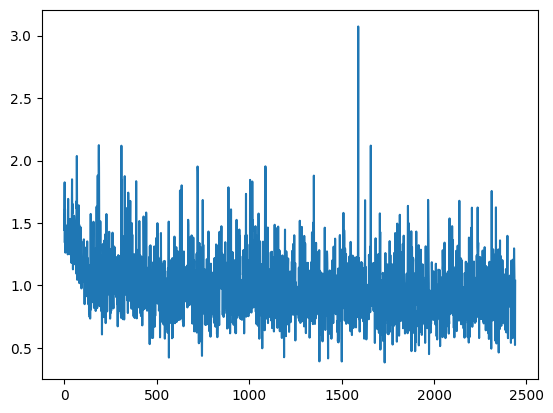

In [23]:
plt.plot(train_losses)

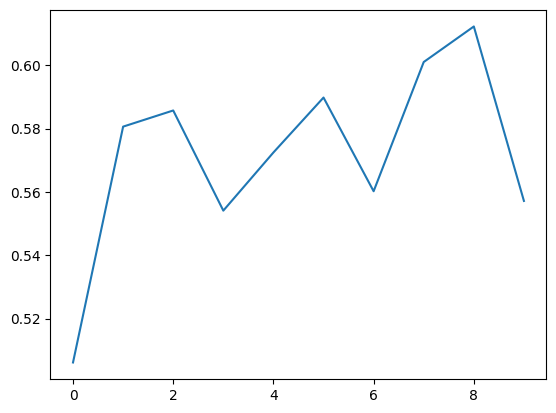

In [24]:
plt.plot(test_accuracy)

In [25]:
layer = model.fe_blocks.blocks[0].block.layer
named_params = [p for p in layer.named_parameters()]
named_params

[('window_params',
  Parameter containing:
  tensor([[[ 1.1197e+00,  1.3027e+00,  1.0036e+00,  1.2765e+00,  1.0781e+00]],
  
          [[ 1.2744e+00,  1.0113e+00,  6.9911e-01,  1.3122e+00,  9.7394e-01]],
  
          [[ 1.2795e+00,  1.0217e+00,  4.5025e-01,  1.0043e+00,  1.1856e+00]],
  
          [[ 1.2839e+00,  5.7691e-01,  7.4278e-01,  9.8695e-01,  1.1369e+00]],
  
          [[ 9.9191e-01,  5.0731e-01,  5.8474e-01,  1.0985e+00,  1.1076e+00]],
  
          [[ 8.6963e-01,  6.0830e-01,  2.8674e-01,  1.0351e+00,  1.0957e+00]],
  
          [[ 3.5049e-01,  5.8731e-01,  1.7542e-01,  2.1178e-01,  3.8161e-01]],
  
          [[ 3.3285e-01,  5.4192e-01,  2.9364e-01,  5.8651e-01,  4.0649e-01]],
  
          [[ 5.4865e-01,  6.2776e-01,  5.2403e-01,  9.5731e-01,  6.7476e-01]],
  
          [[ 4.7972e-01,  5.2667e-01,  3.4063e-01,  5.4890e-01,  4.1842e-01]],
  
          [[ 6.5054e-01,  5.3110e-01,  5.5250e-01,  1.0123e+00,  5.7555e-01]],
  
          [[ 5.7159e-01,  5.7807e-01,  2.4646e-01,  7.7

In [26]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[[ 2.5491e-04,  8.1300e-05,  5.6101e-04,  1.9755e-03,  2.0590e-03]],

        [[ 1.4502e-03,  9.8030e-05,  8.5635e-04,  1.0593e-03,  1.3643e-03]],

        [[ 1.0710e-03,  7.5854e-04,  5.9019e-04,  5.5906e-04,  1.0743e-03]],

        [[ 4.8652e-04,  7.3203e-04,  8.8136e-04,  6.7273e-04,  1.0808e-03]],

        [[ 1.1125e-04,  5.3265e-04,  5.0335e-04,  3.7183e-04,  3.3122e-04]],

        [[ 1.3333e-04,  4.0420e-04,  8.4733e-04,  5.1760e-04,  6.9956e-04]],

        [[ 3.1762e-04,  2.9166e-04,  1.0922e-03,  8.8840e-04,  3.8431e-04]],

        [[ 4.7829e-04,  7.2339e-04,  1.0870e-03,  3.0048e-04,  6.6905e-04]],

        [[ 8.5106e-04,  1.4333e-03,  9.7141e-04,  4.9039e-04,  8.1870e-04]],

        [[-1.5905e-04,  8.8791e-04,  2.0427e-03,  7.8474e-04,  1.7015e-03]],

        [[ 8.0215e-04,  9.5348e-04,  1.2896e-03,  4.8944e-04,  6.0376e-04]],

        [[ 5.6581e-04,  9.8155e-04,  1.4655e-03,  1.0220e-03,  1.2280e-03]],

        [[ 3.4773e-04,  1.1560e-03,  1.3157e-03,  5.9480e-04,  1

[None]

(array([ 2.,  7.,  7., 11., 15., 20., 26., 31., 39., 37., 45., 54., 51.,
        51., 45., 41., 42., 32., 25., 36., 26., 21., 22., 19., 19., 24.,
        15., 15., 18., 29., 25., 23., 27., 27., 18., 19., 12.,  6.,  4.,
         4.]),
 array([-0.23210314, -0.18960513, -0.14710711, -0.10460909, -0.06211108,
        -0.01961307,  0.02288495,  0.06538296,  0.10788097,  0.15037899,
         0.19287699,  0.23537502,  0.27787304,  0.32037103,  0.36286905,
         0.40536708,  0.4478651 ,  0.49036309,  0.53286111,  0.57535911,
         0.61785716,  0.66035515,  0.70285314,  0.7453512 ,  0.78784919,
         0.83034724,  0.87284523,  0.91534323,  0.95784128,  1.00033927,
         1.04283726,  1.08533525,  1.12783337,  1.17033136,  1.21282935,
         1.25532734,  1.29782534,  1.34032333,  1.38282144,  1.42531943,
         1.46781743]),
 <BarContainer object of 40 artists>)

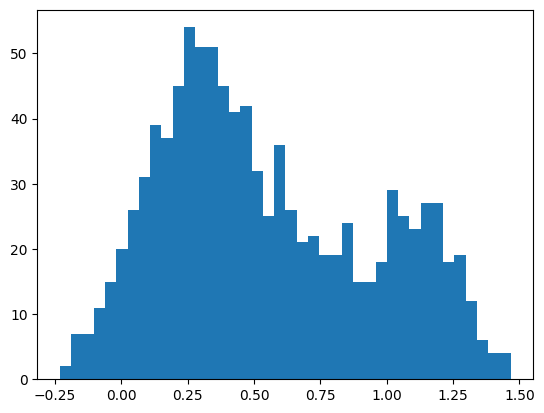

In [27]:
p = named_params[0][1].detach().cpu().numpy()
plt.hist(p.flatten(), bins=40)

(array([  1.,   0.,   0.,   1.,   1.,   4.,   3.,   5.,  15.,  35.,  51.,
         63.,  81.,  91., 116., 114.,  74.,  85.,  62.,  42.,  34.,  25.,
         15.,  22.,  12.,  11.,   7.,   6.,   2.,   2.,   1.,   0.,   1.,
          4.,   0.,   1.,   1.,   0.,   0.,   2.]),
 array([-1.47570239e-03, -1.36927434e-03, -1.26284629e-03, -1.15641824e-03,
        -1.04999030e-03, -9.43562191e-04, -8.37134197e-04, -7.30706146e-04,
        -6.24278095e-04, -5.17850043e-04, -4.11422021e-04, -3.04993999e-04,
        -1.98565947e-04, -9.21379105e-05,  1.42901263e-05,  1.20718163e-04,
         2.27146200e-04,  3.33574251e-04,  4.40002274e-04,  5.46430296e-04,
         6.52858347e-04,  7.59286399e-04,  8.65714392e-04,  9.72142443e-04,
         1.07857049e-03,  1.18499855e-03,  1.29142660e-03,  1.39785465e-03,
         1.50428270e-03,  1.61071063e-03,  1.71713869e-03,  1.82356674e-03,
         1.92999479e-03,  2.03642272e-03,  2.14285078e-03,  2.24927883e-03,
         2.35570688e-03,  2.46213493e-03, 

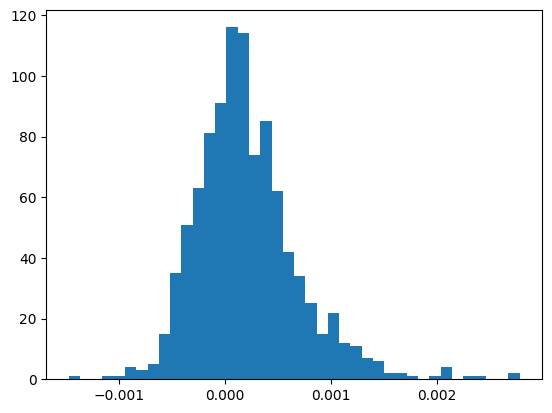

In [28]:
p_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(p_grad.flatten(), bins=40)

In [ ]:
from IConNet.visualizer import visualize_model
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

In [ ]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = windows, 
    window_length = 64,
    sample_rate = sr
)

filtviz.visualize_filters(filter_domain='time')

In [ ]:
filtviz.visualize_filters(filter_domain='freq')

In [25]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [30]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 546/976 (0.5594)
{'acc_detail': tensor([0.8780, 0.8148, 0.4173, 0.1627], device='cuda:0'),
 'acc_unweighted': tensor(0.5682, device='cuda:0'),
 'acc_weighted': tensor(0.5594, device='cuda:0'),
 'f1s_detail': tensor([0.7159, 0.5614, 0.5668, 0.2500], device='cuda:0'),
 'f1s_unweighted': tensor(0.5235, device='cuda:0'),
 'f1s_weighted': tensor(0.5226, device='cuda:0'),
 'precision_detail': tensor([0.6043, 0.4282, 0.8833, 0.5395], device='cuda:0'),
 'recall_detail': tensor([0.8780, 0.8148, 0.4173, 0.1627], device='cuda:0'),
 'rocauc': tensor(0.8513, device='cuda:0'),
 'rocauc_detail': tensor([0.9169, 0.8005, 0.9121, 0.7759], device='cuda:0'),
 'uar': tensor(0.5682, device='cuda:0'),
 'wap': tensor(0.6212, device='cuda:0')}


tensor([[223,  18,   2,  11],
        [ 16, 176,   8,  16],
        [  7, 133, 106,   8],
        [123,  84,   4,  41]], device='cuda:0')

In [31]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m14sinc_window_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                           | 0.003278688524590164/50 [00:00<1:29:18, 107.18s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 0.970050
Mem before-during-after: 27650048 3923377664 31196160


  0%|▏                                                                                           | 0.13442622950819672/50 [00:15<1:31:12, 109.75s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 1.237428
Mem before-during-after: 32048128 3857864704 31166464


  1%|▍                                                                                           | 0.26557377049180286/50 [00:31<1:33:22, 112.65s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 1.032774
Mem before-during-after: 32048128 3967916032 32048128


  1%|▊                                                                                              | 0.39672131147541/50 [00:46<1:33:44, 113.40s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 1.141632
Mem before-during-after: 32048128 3967979008 31229440


  1%|▉                                                                                            | 0.5278688524590167/50 [01:01<1:38:01, 118.89s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 0.766634
Mem before-during-after: 32048128 3968040960 32048128


  1%|█▏                                                                                           | 0.6590163934426216/50 [01:16<1:32:48, 112.86s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 0.849629
Mem before-during-after: 32048128 3968040960 32048128


  2%|█▍                                                                                           | 0.7901639344262266/50 [01:31<1:51:50, 136.36s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 0.796152
Mem before-during-after: 31166464 3841785856 32130048


  2%|█▉                                                                                              | 0.9999999999999944/50 [01:45<51:54, 63.56s/it]


Test Epoch: 11	Accuracy: 617/976 (63%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_11epoch.pt


  2%|█▉                                                                                            | 1.0032786885245846/50 [01:46<1:03:49, 78.16s/it]

Train Epoch: 12 [0/3918 (0%)]	Loss: 0.743981
Mem before-during-after: 31159296 3965428224 31228928


  2%|██                                                                                           | 1.1344262295081895/50 [02:01<1:37:03, 119.17s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 0.808599
Mem before-during-after: 32929792 3967916032 32048128


  3%|██▎                                                                                          | 1.2655737704917944/50 [02:16<1:31:10, 112.25s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 0.859680
Mem before-during-after: 32048128 3968040960 32048128


  3%|██▌                                                                                          | 1.3967213114753994/50 [02:31<1:36:12, 118.76s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 0.857968
Mem before-during-after: 32048128 3968040960 32048128


  3%|██▊                                                                                          | 1.5278688524590043/50 [02:46<1:30:46, 112.37s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 0.989508
Mem before-during-after: 32048128 3968040960 32048128


  3%|███                                                                                          | 1.6590163934426092/50 [03:01<1:33:25, 115.96s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 1.116800
Mem before-during-after: 32372736 3967987200 32929792


  4%|███▎                                                                                         | 1.7901639344262141/50 [03:16<1:31:17, 113.62s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 0.778665
Mem before-during-after: 32929792 3965818880 32048128


  4%|███▉                                                                                             | 1.999999999999982/50 [03:30<51:02, 63.80s/it]


Test Epoch: 12	Accuracy: 624/976 (64%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_12epoch.pt


  4%|███▊                                                                                          | 2.0032786885245724/50 [03:31<1:00:51, 76.09s/it]

Train Epoch: 13 [0/3918 (0%)]	Loss: 0.519080
Mem before-during-after: 31159296 3965366272 31166976


  4%|███▉                                                                                         | 2.1344262295081773/50 [03:46<1:39:33, 124.80s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 1.036677
Mem before-during-after: 32048128 3968040960 32048128


  5%|████▎                                                                                         | 2.265573770491782/50 [04:01<1:39:36, 125.21s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 0.749731
Mem before-during-after: 31491072 3967358976 32048128


  5%|████▌                                                                                         | 2.396721311475387/50 [04:16<1:28:58, 112.16s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 0.663258
Mem before-during-after: 32048128 3675493376 31166464


  5%|████▊                                                                                         | 2.527868852458992/50 [04:31<1:33:39, 118.38s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 0.786141
Mem before-during-after: 32372736 3965943808 32173056


  5%|████▉                                                                                         | 2.659016393442597/50 [04:46<1:28:41, 112.41s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 0.360911
Mem before-during-after: 32048128 3968040960 32048128


  6%|█████▏                                                                                        | 2.790163934426202/50 [05:01<1:30:06, 114.52s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 0.892112
Mem before-during-after: 32048128 3965943808 32048128


  6%|█████▉                                                                                            | 2.99999999999997/50 [05:15<50:09, 64.03s/it]


Test Epoch: 13	Accuracy: 629/976 (64%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_13epoch.pt


  6%|█████▉                                                                                            | 3.00327868852456/50 [05:15<59:43, 76.25s/it]

Train Epoch: 14 [0/3918 (0%)]	Loss: 0.793199
Mem before-during-after: 31159296 3965365760 31166464


  6%|█████▉                                                                                        | 3.134426229508165/50 [05:30<1:37:37, 124.98s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 0.845456
Mem before-during-after: 32048128 3965711360 32372736


  7%|██████▏                                                                                        | 3.26557377049177/50 [05:45<1:34:18, 121.07s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 0.731788
Mem before-during-after: 32048128 3968240640 32372736


  7%|██████▎                                                                                      | 3.3967213114753747/50 [06:01<1:33:32, 120.42s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 1.333423
Mem before-during-after: 31491072 3965261824 32048128


  7%|██████▌                                                                                      | 3.5278688524589796/50 [06:16<1:26:02, 111.09s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 1.205579
Mem before-during-after: 32048128 3716807168 31166464


  7%|██████▊                                                                                      | 3.6590163934425846/50 [06:31<1:26:17, 111.73s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 0.864703
Mem before-during-after: 32048128 3967916032 32048128


  8%|███████                                                                                      | 3.7901639344261895/50 [06:47<1:27:41, 113.86s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 1.343139
Mem before-during-after: 32048128 3968040960 32048128


  8%|███████▋                                                                                        | 3.9999999999999574/50 [07:00<48:36, 63.41s/it]


Test Epoch: 14	Accuracy: 626/976 (64%)



  8%|███████▋                                                                                        | 4.0032786885245475/50 [07:01<57:55, 75.56s/it]

Train Epoch: 15 [0/3918 (0%)]	Loss: 0.609115
Mem before-during-after: 31159296 3965365760 31166464


  8%|███████▊                                                                                      | 4.134426229508152/50 [07:16<1:27:28, 114.44s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 0.674520
Mem before-during-after: 32048128 3965943808 32048128


  9%|████████                                                                                      | 4.265573770491757/50 [07:30<1:25:22, 112.00s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 0.734163
Mem before-during-after: 32048128 3968040960 32048128


  9%|████████▎                                                                                     | 4.396721311475362/50 [07:46<1:32:38, 121.89s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 0.758828
Mem before-during-after: 31815680 3967483904 32173056


  9%|████████▌                                                                                     | 4.527868852458967/50 [08:01<1:35:10, 125.58s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 0.948078
Mem before-during-after: 32048128 3968240640 32372736


  9%|████████▊                                                                                     | 4.659016393442572/50 [08:16<1:38:22, 130.18s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 0.923376
Mem before-during-after: 31572992 3967078912 31228928


 10%|█████████                                                                                     | 4.790163934426177/50 [08:31<1:38:24, 130.60s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 0.719846
Mem before-during-after: 31166464 3933305856 31196160


 10%|█████████▋                                                                                       | 4.999999999999945/50 [08:45<47:39, 63.55s/it]


Test Epoch: 15	Accuracy: 618/976 (63%)



 10%|█████████▋                                                                                       | 5.003278688524535/50 [08:45<57:45, 77.02s/it]

Train Epoch: 16 [0/3918 (0%)]	Loss: 0.963252
Mem before-during-after: 31159296 3965428224 31228928


 10%|█████████▊                                                                                     | 5.13442622950814/50 [09:00<1:25:10, 113.91s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 0.895141
Mem before-during-after: 32048128 3965943808 32048128


 11%|█████████▉                                                                                    | 5.265573770491745/50 [09:16<1:33:32, 125.47s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 0.780377
Mem before-during-after: 31815680 3939734016 31392768


 11%|██████████▎                                                                                    | 5.39672131147535/50 [09:31<1:32:15, 124.11s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 0.488703
Mem before-during-after: 31166464 3969921024 32048128


 11%|██████████▍                                                                                   | 5.527868852458955/50 [09:46<1:23:27, 112.59s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 1.245167
Mem before-during-after: 32048128 3965943808 32048128


 11%|██████████▊                                                                                    | 5.65901639344256/50 [10:01<1:24:04, 113.76s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 0.813537
Mem before-during-after: 32929792 3967916032 32048128


 12%|██████████▉                                                                                   | 5.790163934426165/50 [10:16<1:22:31, 112.00s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 0.855098
Mem before-during-after: 32102912 3909492736 31166464


 12%|███████████▌                                                                                    | 5.9999999999999325/50 [10:31<46:21, 63.22s/it]


Test Epoch: 16	Accuracy: 615/976 (63%)



 12%|███████████▋                                                                                     | 6.003278688524523/50 [10:31<55:54, 76.24s/it]

Train Epoch: 17 [0/3918 (0%)]	Loss: 0.710850
Mem before-during-after: 31159296 3965428224 31228928


 12%|███████████▍                                                                                 | 6.1344262295081275/50 [10:47<1:33:31, 127.93s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 0.820980
Mem before-during-after: 31166464 3969456128 31491072


 13%|███████████▋                                                                                 | 6.2655737704917325/50 [11:02<1:39:37, 136.67s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 0.873544
Mem before-during-after: 31166464 3966045184 31491072


 13%|████████████                                                                                  | 6.396721311475337/50 [11:16<1:21:59, 112.82s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 0.869359
Mem before-during-after: 32048128 3968040960 32048128


 13%|████████████▎                                                                                 | 6.527868852458942/50 [11:31<1:28:33, 122.24s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 0.991888
Mem before-during-after: 32048128 3968040960 32048128


 13%|████████████▌                                                                                 | 6.659016393442547/50 [11:47<1:22:18, 113.95s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 0.871095
Mem before-during-after: 32048128 3964442624 31228928


 14%|████████████▊                                                                                 | 6.790163934426152/50 [12:02<1:22:21, 114.36s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 1.229244
Mem before-during-after: 32048128 3968040960 32048128


 14%|█████████████▋                                                                                    | 6.99999999999992/50 [12:15<45:09, 63.02s/it]


Test Epoch: 17	Accuracy: 616/976 (63%)



 14%|█████████████▋                                                                                    | 7.00327868852451/50 [12:16<53:56, 75.26s/it]

Train Epoch: 18 [0/3918 (0%)]	Loss: 1.126614
Mem before-during-after: 31159296 3965428224 31228928


 14%|█████████████▍                                                                                | 7.134426229508115/50 [12:31<1:20:30, 112.69s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 0.756899
Mem before-during-after: 32048128 3967916032 32048128


 15%|█████████████▊                                                                                 | 7.26557377049172/50 [12:46<1:20:45, 113.38s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 0.752916
Mem before-during-after: 32048128 3968040960 32048128


 15%|█████████████▉                                                                                | 7.396721311475325/50 [13:01<1:20:08, 112.87s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 0.787354
Mem before-during-after: 32048128 3968040960 32048128


 15%|██████████████▎                                                                                | 7.52786885245893/50 [13:16<1:21:49, 115.58s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 0.711161
Mem before-during-after: 31228928 3965881344 32048128


 15%|██████████████▍                                                                               | 7.659016393442535/50 [13:31<1:22:25, 116.81s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 0.949858
Mem before-during-after: 32173056 3965187072 31291392


 16%|██████████████▉                                                                                 | 7.79344262295073/50 [13:47<1:08:08, 96.86s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 0.681740
Mem before-during-after: 32048128 3967916032 32048128


 16%|███████████████▌                                                                                 | 7.999999999999908/50 [14:00<44:14, 63.21s/it]


Test Epoch: 18	Accuracy: 626/976 (64%)



 16%|███████████████▌                                                                                 | 8.003278688524498/50 [14:01<52:44, 75.36s/it]

Train Epoch: 19 [0/3918 (0%)]	Loss: 0.896053
Mem before-during-after: 31159296 3965365760 31166464


 16%|███████████████▎                                                                              | 8.134426229508103/50 [14:16<1:20:45, 115.74s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 1.117074
Mem before-during-after: 32048128 3967916032 32048128


 17%|███████████████▌                                                                              | 8.265573770491708/50 [14:31<1:21:34, 117.28s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 0.955051
Mem before-during-after: 32048128 3965711360 32372736


 17%|███████████████▊                                                                              | 8.396721311475313/50 [14:46<1:31:43, 132.29s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 0.832516
Mem before-during-after: 31572992 3966522368 31228928


 17%|████████████████                                                                              | 8.527868852458917/50 [15:01<1:19:15, 114.66s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 0.683872
Mem before-during-after: 32372736 3965890048 32929792


 17%|████████████████▎                                                                             | 8.659016393442522/50 [15:16<1:18:25, 113.82s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 0.737847
Mem before-during-after: 32048128 3968040960 32048128


 18%|████████████████▌                                                                             | 8.790163934426127/50 [15:31<1:17:22, 112.65s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 0.834234
Mem before-during-after: 32048128 3968040960 32048128


 18%|█████████████████▍                                                                               | 8.999999999999895/50 [15:45<46:57, 68.72s/it]


Test Epoch: 19	Accuracy: 619/976 (63%)



 18%|█████████████████▍                                                                               | 9.003278688524485/50 [15:45<54:10, 79.29s/it]

Train Epoch: 20 [0/3918 (0%)]	Loss: 0.750819
Mem before-during-after: 31159296 3965428224 31228928


 18%|█████████████████▎                                                                             | 9.13442622950809/50 [16:00<1:17:54, 114.40s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 0.785776
Mem before-during-after: 31228928 3967170048 32048128


 19%|█████████████████▍                                                                            | 9.265573770491695/50 [16:16<1:18:09, 115.11s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 0.411474
Mem before-during-after: 32048128 3799450112 31166464


 19%|██████████████████                                                                              | 9.3967213114753/50 [16:31<1:15:59, 112.29s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 0.607645
Mem before-during-after: 32048128 3967916032 32048128


 19%|█████████████████▉                                                                            | 9.527868852458905/50 [16:45<1:19:00, 117.13s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 0.922294
Mem before-during-after: 32048128 3968040960 32048128


 19%|██████████████████▎                                                                            | 9.65901639344251/50 [17:01<1:18:32, 116.83s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 0.870756
Mem before-during-after: 32048128 3967808512 32372736


 20%|██████████████████▍                                                                           | 9.790163934426115/50 [17:16<1:34:58, 141.72s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 0.613268
Mem before-during-after: 31166464 3967358976 31491072


 20%|███████████████████▍                                                                             | 9.999999999999883/50 [17:30<43:19, 65.00s/it]


Test Epoch: 20	Accuracy: 628/976 (64%)



 20%|███████████████████▏                                                                            | 10.003278688524473/50 [17:30<51:19, 76.99s/it]

Train Epoch: 21 [0/3918 (0%)]	Loss: 0.835238
Mem before-during-after: 31159296 3965428224 31228928


 20%|██████████████████▊                                                                          | 10.134426229508078/50 [17:45<1:15:41, 113.92s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 1.023352
Mem before-during-after: 32048128 3968040960 32048128


 21%|███████████████████                                                                          | 10.265573770491683/50 [18:01<1:15:36, 114.18s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 0.512084
Mem before-during-after: 32048128 3968040960 32048128


 21%|███████████████████▎                                                                         | 10.396721311475288/50 [18:16<1:15:24, 114.24s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 0.464651
Mem before-during-after: 32048128 3965943808 32048128


 21%|███████████████████▌                                                                         | 10.527868852458893/50 [18:31<1:13:53, 112.31s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 0.983336
Mem before-during-after: 32048128 3968040960 32048128


 21%|███████████████████▊                                                                         | 10.659016393442498/50 [18:45<1:13:43, 112.44s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: 1.099475
Mem before-during-after: 32929792 3966602240 31491072


 22%|████████████████████                                                                         | 10.790163934426102/50 [19:00<1:16:31, 117.10s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: 0.615362
Mem before-during-after: 32048128 3967808512 32372736


 22%|█████████████████████▎                                                                           | 10.99999999999987/50 [19:14<40:48, 62.78s/it]


Test Epoch: 21	Accuracy: 614/976 (63%)



 22%|█████████████████████▎                                                                           | 11.00327868852446/50 [19:15<48:43, 74.97s/it]

Train Epoch: 22 [0/3918 (0%)]	Loss: 0.829279
Mem before-during-after: 31159296 3965366272 31166976


 22%|████████████████████▋                                                                        | 11.134426229508065/50 [19:30<1:14:45, 115.41s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: 0.940588
Mem before-during-after: 32048128 3967916032 32048128


 23%|█████████████████████▏                                                                        | 11.26557377049167/50 [19:45<1:23:28, 129.32s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: 0.724562
Mem before-during-after: 31166464 3967159296 32048128


 23%|█████████████████████▏                                                                       | 11.396721311475275/50 [20:00<1:12:38, 112.91s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: 1.208570
Mem before-during-after: 31166464 3776995840 31166464


 23%|█████████████████████▋                                                                        | 11.52786885245888/50 [20:15<1:12:17, 112.75s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: 0.784863
Mem before-during-after: 32048128 3965943808 32048128


 23%|█████████████████████▋                                                                       | 11.659016393442485/50 [20:30<1:12:15, 113.08s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: 0.855186
Mem before-during-after: 32048128 3965818880 32048128


 24%|██████████████████████▏                                                                       | 11.79016393442609/50 [20:45<1:10:50, 111.24s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: 1.101342
Mem before-during-after: 32048128 3968040960 32048128


 24%|███████████████████████                                                                         | 11.999999999999858/50 [20:59<40:53, 64.58s/it]


Test Epoch: 22	Accuracy: 635/976 (65%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_22epoch.pt


 24%|███████████████████████                                                                         | 12.003278688524448/50 [20:59<48:28, 76.53s/it]

Train Epoch: 23 [0/3918 (0%)]	Loss: 0.778396
Mem before-during-after: 31159296 3965366272 31166976


 24%|██████████████████████▌                                                                      | 12.134426229508053/50 [21:14<1:25:09, 134.94s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: 0.689773
Mem before-during-after: 31356928 3966242304 31166464


 25%|██████████████████████▊                                                                      | 12.265573770491658/50 [21:29<1:18:34, 124.95s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: 0.656186
Mem before-during-after: 31166464 3967105536 32048128


 25%|███████████████████████                                                                      | 12.396721311475263/50 [21:44<1:14:48, 119.37s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: 1.110219
Mem before-during-after: 32048128 3967808512 32372736


 25%|███████████████████████▎                                                                     | 12.527868852458868/50 [21:59<1:18:40, 125.98s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: 0.638426
Mem before-during-after: 31166464 3967358976 31491072


 25%|███████████████████████▌                                                                     | 12.659016393442473/50 [22:15<1:09:51, 112.25s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: 0.994453
Mem before-during-after: 31815680 3967197696 31815680


 26%|███████████████████████▊                                                                     | 12.790163934426078/50 [22:31<1:13:29, 118.51s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: 0.478752
Mem before-during-after: 32173056 3966726656 31491072


 26%|████████████████████████▉                                                                       | 12.999999999999845/50 [22:44<38:45, 62.84s/it]


Test Epoch: 23	Accuracy: 626/976 (64%)



 26%|████████████████████████▉                                                                       | 13.003278688524436/50 [22:45<46:50, 75.96s/it]

Train Epoch: 24 [0/3918 (0%)]	Loss: 0.617690
Mem before-during-after: 31159296 3965428224 31228928


 26%|████████████████████████▋                                                                     | 13.13442622950804/50 [23:00<1:09:57, 113.86s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: 0.561359
Mem before-during-after: 32048128 3967916032 32048128


 27%|████████████████████████▋                                                                    | 13.265573770491645/50 [23:15<1:09:42, 113.87s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: 0.639354
Mem before-during-after: 32372736 3968240640 32372736


 27%|█████████████████████████▏                                                                    | 13.39672131147525/50 [23:30<1:08:50, 112.85s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: 0.997656
Mem before-during-after: 32048128 3968040960 32048128


 27%|█████████████████████████▏                                                                   | 13.527868852458855/50 [23:45<1:20:05, 131.75s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: 1.488461
Mem before-during-after: 31166464 3967078912 31228928


 27%|█████████████████████████▋                                                                    | 13.65901639344246/50 [24:00<1:13:18, 121.03s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: 1.040216
Mem before-during-after: 32048128 3968040960 32048128


 28%|█████████████████████████▋                                                                   | 13.790163934426065/50 [24:15<1:08:50, 114.07s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: 0.974589
Mem before-during-after: 32048128 3967916032 32048128


 28%|██████████████████████████▉                                                                     | 13.999999999999833/50 [24:29<38:29, 64.15s/it]


Test Epoch: 24	Accuracy: 608/976 (62%)



 28%|██████████████████████████▉                                                                     | 14.003278688524423/50 [24:29<46:09, 76.93s/it]

Train Epoch: 25 [0/3918 (0%)]	Loss: 0.445954
Mem before-during-after: 31159296 3965365760 31166464


 28%|██████████████████████████▎                                                                  | 14.134426229508028/50 [24:44<1:07:48, 113.43s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: 0.814958
Mem before-during-after: 32048128 3967916032 32048128


 29%|██████████████████████████▌                                                                  | 14.265573770491633/50 [24:59<1:15:59, 127.61s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: 1.130342
Mem before-during-after: 31392768 3968899072 31491072


 29%|██████████████████████████▊                                                                  | 14.396721311475238/50 [25:15<1:15:34, 127.35s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: 1.016489
Mem before-during-after: 31491072 3758759936 31166464


 29%|███████████████████████████                                                                  | 14.527868852458843/50 [25:30<1:09:27, 117.48s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: 0.986612
Mem before-during-after: 32048128 3968040960 32048128


 29%|███████████████████████████▎                                                                 | 14.659016393442448/50 [25:45<1:06:44, 113.32s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: 0.724348
Mem before-during-after: 32929792 3967916032 32048128


 30%|███████████████████████████▌                                                                 | 14.790163934426053/50 [26:00<1:06:35, 113.47s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: 0.976420
Mem before-during-after: 32048128 3968040960 32048128


 30%|█████████████████████████████                                                                    | 14.99999999999982/50 [26:14<37:39, 64.54s/it]


Test Epoch: 25	Accuracy: 626/976 (64%)



 30%|█████████████████████████████                                                                    | 15.00327868852441/50 [26:15<44:33, 76.39s/it]

Train Epoch: 26 [0/3918 (0%)]	Loss: 0.823751
Mem before-during-after: 31159296 3965366272 31166976


 30%|████████████████████████████▏                                                                | 15.134426229508016/50 [26:30<1:13:47, 126.98s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: 0.820478
Mem before-during-after: 31232000 3967916032 32048128


 31%|████████████████████████████▋                                                                 | 15.26557377049162/50 [26:45<1:05:07, 112.51s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: 0.801113
Mem before-during-after: 32048128 3967916032 32048128


 31%|████████████████████████████▋                                                                | 15.396721311475225/50 [27:00<1:06:21, 115.05s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: 0.941448
Mem before-during-after: 32372736 3968240640 32372736


 31%|█████████████████████████████▏                                                                | 15.52786885245883/50 [27:15<1:09:12, 120.45s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: 0.704997
Mem before-during-after: 32048128 3965943808 32048128


 31%|█████████████████████████████▏                                                               | 15.659016393442435/50 [27:30<1:04:36, 112.88s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: 0.794926
Mem before-during-after: 32048128 3965943808 32048128


 32%|█████████████████████████████▋                                                                | 15.79016393442604/50 [27:46<1:07:36, 118.57s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: 0.741984
Mem before-during-after: 32048128 3967178240 31228928


 32%|██████████████████████████████▋                                                                 | 15.999999999999808/50 [27:59<35:51, 63.27s/it]


Test Epoch: 26	Accuracy: 627/976 (64%)



 32%|███████████████████████████████▎                                                                  | 16.0032786885244/50 [28:00<43:13, 76.29s/it]

Train Epoch: 27 [0/3918 (0%)]	Loss: 0.989693
Mem before-during-after: 31159296 3965366272 31166976


 32%|██████████████████████████████                                                               | 16.134426229508076/50 [28:15<1:08:15, 120.94s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: 0.892399
Mem before-during-after: 32048128 3967916032 32048128


 33%|██████████████████████████████▎                                                              | 16.265573770491752/50 [28:30<1:02:40, 111.48s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: 0.797154
Mem before-during-after: 32048128 3968040960 32048128


 33%|██████████████████████████████▍                                                              | 16.396721311475428/50 [28:45<1:04:47, 115.68s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: 0.729451
Mem before-during-after: 32048128 3968040960 32048128


 33%|██████████████████████████████▋                                                              | 16.527868852459104/50 [29:00<1:05:28, 117.38s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: 0.592919
Mem before-during-after: 31166464 3967123968 32048128


 33%|███████████████████████████████▎                                                              | 16.65901639344278/50 [29:15<1:02:02, 111.65s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: 0.876839
Mem before-during-after: 32235008 3967916032 32048128


 34%|███████████████████████████████▏                                                             | 16.790163934426456/50 [29:30<1:11:47, 129.70s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: 0.898214
Mem before-during-after: 31166464 3925053952 31166464


 34%|████████████████████████████████▋                                                               | 17.000000000000338/50 [29:44<35:22, 64.32s/it]


Test Epoch: 27	Accuracy: 624/976 (64%)



 34%|████████████████████████████████▉                                                                | 17.00327868852493/50 [29:44<42:40, 77.59s/it]

Train Epoch: 28 [0/3918 (0%)]	Loss: 0.898343
Mem before-during-after: 31159296 3965365760 31166464


 34%|███████████████████████████████▊                                                             | 17.134426229508605/50 [29:59<1:01:23, 112.07s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: 1.031079
Mem before-during-after: 32048128 3966539776 31228928


 35%|████████████████████████████████▍                                                             | 17.26557377049228/50 [30:15<1:01:51, 113.39s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: 0.825886
Mem before-during-after: 31291392 3968165888 32048128


 35%|████████████████████████████████▎                                                            | 17.396721311475957/50 [30:30<1:00:37, 111.58s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: 0.919948
Mem before-during-after: 32048128 3968040960 32048128


 35%|████████████████████████████████▌                                                            | 17.527868852459633/50 [30:45<1:02:17, 115.10s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: 0.923782
Mem before-during-after: 31353856 3965178880 32227328


 35%|█████████████████████████████████▏                                                            | 17.65901639344331/50 [31:00<1:00:51, 112.90s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: 0.488118
Mem before-during-after: 32372736 3966926848 32372736


 36%|█████████████████████████████████▊                                                             | 17.790163934426985/50 [31:15<58:42, 109.36s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: 1.133511
Mem before-during-after: 32048128 3910571008 31166464


 36%|██████████████████████████████████▌                                                             | 18.000000000000867/50 [31:29<33:23, 62.61s/it]


Test Epoch: 28	Accuracy: 620/976 (63%)



 36%|██████████████████████████████████▉                                                              | 18.00327868852546/50 [31:30<40:00, 75.02s/it]

Train Epoch: 29 [0/3918 (0%)]	Loss: 0.626642
Mem before-during-after: 31159296 3965428224 31228928


 36%|█████████████████████████████████▋                                                           | 18.134426229509135/50 [31:45<1:00:21, 113.65s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: 0.835636
Mem before-during-after: 32048128 3965943808 32048128


 37%|██████████████████████████████████▎                                                           | 18.26557377049281/50 [32:00<1:02:10, 117.56s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: 0.936520
Mem before-during-after: 32048128 3965711360 32372736


 37%|███████████████████████████████████▎                                                            | 18.40000000000108/50 [32:16<55:45, 105.88s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: 0.851377
Mem before-during-after: 32048128 3968040960 32048128


 37%|███████████████████████████████████▏                                                           | 18.527868852460163/50 [32:31<59:26, 113.33s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: 0.861801
Mem before-during-after: 32048128 3968040960 32048128


 37%|███████████████████████████████████▊                                                            | 18.65901639344384/50 [32:46<58:40, 112.33s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: 1.253568
Mem before-during-after: 32048128 3968040960 32048128


 38%|██████████████████████████████████▉                                                          | 18.790163934427515/50 [33:01<1:11:14, 136.97s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: 0.870454
Mem before-during-after: 31491072 3457483264 31166464


 38%|████████████████████████████████████▍                                                           | 19.000000000001396/50 [33:15<32:28, 62.87s/it]


Test Epoch: 29	Accuracy: 624/976 (64%)



 38%|████████████████████████████████████▍                                                           | 19.003278688525988/50 [33:16<39:18, 76.08s/it]

Train Epoch: 30 [0/3918 (0%)]	Loss: 1.068201
Mem before-during-after: 31159296 3965428224 31228928


 38%|████████████████████████████████████▎                                                          | 19.134426229509664/50 [33:30<57:41, 112.15s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: 0.874593
Mem before-during-after: 32048128 3937157120 31166464


 39%|████████████████████████████████████▉                                                           | 19.26557377049334/50 [33:45<57:32, 112.33s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: 0.689509
Mem before-during-after: 32048128 3968040960 32048128


 39%|████████████████████████████████████▊                                                          | 19.396721311477016/50 [34:00<57:35, 112.91s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: 0.563499
Mem before-during-after: 32048128 3968040960 32048128


 39%|████████████████████████████████████▎                                                        | 19.527868852460692/50 [34:15<1:07:27, 132.81s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: 0.935434
Mem before-during-after: 31842304 3967159296 32048128


 39%|█████████████████████████████████████▎                                                         | 19.659016393444368/50 [34:30<57:17, 113.30s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: 0.517442
Mem before-during-after: 32048128 3967916032 32048128


 40%|█████████████████████████████████████▌                                                         | 19.790163934428044/50 [34:45<56:45, 112.73s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: 1.056313
Mem before-during-after: 32048128 3967916032 32048128


 40%|██████████████████████████████████████▍                                                         | 20.000000000001926/50 [34:59<31:50, 63.68s/it]


Test Epoch: 30	Accuracy: 634/976 (65%)



 40%|██████████████████████████████████████▍                                                         | 20.003278688526517/50 [35:00<38:18, 76.63s/it]

Train Epoch: 31 [0/3918 (0%)]	Loss: 0.943940
Mem before-during-after: 31159296 3965365760 31166464


 40%|█████████████████████████████████████▍                                                       | 20.134426229510193/50 [35:14<1:02:21, 125.28s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: 0.607037
Mem before-during-after: 32048128 3965943808 32048128


 41%|██████████████████████████████████████▉                                                         | 20.26557377049387/50 [35:30<56:40, 114.36s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: 0.674901
Mem before-during-after: 31228928 3967151616 32102912


 41%|█████████████████████████████████████▉                                                       | 20.396721311477545/50 [35:45<1:02:09, 125.99s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: 1.155866
Mem before-during-after: 31196160 3968475648 31321088


 41%|██████████████████████████████████████▌                                                       | 20.52786885246122/50 [36:00<1:00:10, 122.51s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: 1.092911
Mem before-during-after: 32048128 3968240640 32372736


 41%|███████████████████████████████████████▎                                                       | 20.659016393444897/50 [36:15<56:45, 116.07s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: 0.702034
Mem before-during-after: 32372736 3968040960 32173056


 42%|███████████████████████████████████████▌                                                       | 20.790163934428573/50 [36:30<54:45, 112.49s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: 1.079650
Mem before-during-after: 32048128 3965943808 32048128


 42%|████████████████████████████████████████▎                                                       | 21.000000000002455/50 [36:44<32:25, 67.07s/it]


Test Epoch: 31	Accuracy: 612/976 (62%)



 42%|████████████████████████████████████████▎                                                       | 21.003278688527047/50 [36:44<38:49, 80.33s/it]

Train Epoch: 32 [0/3918 (0%)]	Loss: 0.710836
Mem before-during-after: 31159296 3965365760 31166464


 42%|████████████████████████████████████████▏                                                      | 21.134426229510723/50 [36:59<56:24, 117.25s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: 0.691556
Mem before-during-after: 32048128 3799450112 31166464


 43%|█████████████████████████████████████████▎                                                       | 21.2655737704944/50 [37:15<53:59, 112.73s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: 0.761962
Mem before-during-after: 32372736 3967754752 32372736


 43%|████████████████████████████████████████▋                                                      | 21.396721311478075/50 [37:29<53:50, 112.94s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: 0.681988
Mem before-during-after: 32048128 3964442624 31228928


 43%|█████████████████████████████████████████▎                                                      | 21.52786885246175/50 [37:44<53:37, 112.99s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: 0.874153
Mem before-during-after: 32048128 3964442624 31228928


 43%|█████████████████████████████████████████▏                                                     | 21.659016393445427/50 [37:59<54:22, 115.11s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: 0.647758
Mem before-during-after: 31416320 3967346688 31478784


 44%|████████████████████████████████████████▌                                                    | 21.790163934429103/50 [38:15<1:04:46, 137.76s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: 1.097837
Mem before-during-after: 31166464 3966539776 31228928


 44%|██████████████████████████████████████████▏                                                     | 22.000000000002984/50 [38:29<30:08, 64.58s/it]


Test Epoch: 32	Accuracy: 612/976 (62%)



 44%|██████████████████████████████████████████▏                                                     | 22.003278688527576/50 [38:29<35:44, 76.59s/it]

Train Epoch: 33 [0/3918 (0%)]	Loss: 1.113075
Mem before-during-after: 31159296 3965428224 31228928


 44%|██████████████████████████████████████████                                                     | 22.134426229511252/50 [38:44<52:33, 113.16s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: 1.004660
Mem before-during-after: 32048128 3968040960 32048128


 45%|██████████████████████████████████████████▎                                                    | 22.265573770494928/50 [38:59<51:55, 112.32s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: 0.996478
Mem before-during-after: 31491072 3968365568 32929792


 45%|██████████████████████████████████████████▌                                                    | 22.396721311478604/50 [39:14<52:55, 115.05s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: 0.802148
Mem before-during-after: 32048128 3967916032 32048128


 45%|███████████████████████████████████████████▎                                                    | 22.52786885246228/50 [39:29<53:41, 117.25s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: 0.920918
Mem before-during-after: 32048128 3965943808 32048128


 45%|███████████████████████████████████████████                                                    | 22.659016393445956/50 [39:44<56:45, 124.56s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: 0.731925
Mem before-during-after: 32372736 3967430144 32372736


 46%|███████████████████████████████████████████▎                                                   | 22.790163934429632/50 [40:00<52:58, 116.81s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: 0.582934
Mem before-during-after: 32048128 3965943808 32048128


 46%|████████████████████████████████████████████▏                                                   | 23.000000000003514/50 [40:14<28:01, 62.29s/it]


Test Epoch: 33	Accuracy: 622/976 (63%)



 46%|████████████████████████████████████████████▏                                                   | 23.003278688528106/50 [40:14<34:04, 75.72s/it]

Train Epoch: 34 [0/3918 (0%)]	Loss: 0.788229
Mem before-during-after: 31159296 3965428224 31228928


 46%|████████████████████████████████████████████▍                                                   | 23.13442622951178/50 [40:29<53:12, 118.84s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: 0.873486
Mem before-during-after: 32173056 3966727168 31416320


 47%|████████████████████████████████████████████▏                                                  | 23.265573770495457/50 [40:44<54:21, 122.01s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: 0.662168
Mem before-during-after: 32048128 3967808512 32372736


 47%|████████████████████████████████████████████▍                                                  | 23.396721311479133/50 [40:59<55:07, 124.32s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: 0.702832
Mem before-during-after: 32048128 3967916032 32048128


 47%|█████████████████████████████████████████████▏                                                  | 23.52786885246281/50 [41:15<55:14, 125.22s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: 0.752962
Mem before-during-after: 32048128 3968040960 32048128


 47%|████████████████████████████████████████████▉                                                  | 23.659016393446485/50 [41:29<53:29, 121.84s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: 1.012985
Mem before-during-after: 32048128 3967483904 31491072


 48%|█████████████████████████████████████████████▋                                                  | 23.79016393443016/50 [41:45<49:38, 113.63s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: 0.565845
Mem before-during-after: 32048128 3968040960 32048128


 48%|██████████████████████████████████████████████                                                  | 24.000000000004043/50 [41:59<28:37, 66.06s/it]


Test Epoch: 34	Accuracy: 631/976 (64%)



 48%|██████████████████████████████████████████████                                                  | 24.003278688528635/50 [41:59<33:34, 77.49s/it]

Train Epoch: 35 [0/3918 (0%)]	Loss: 0.832397
Mem before-during-after: 31159296 3965428224 31228928


 48%|██████████████████████████████████████████████▎                                                 | 24.13442622951231/50 [42:14<50:19, 116.73s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: 0.700881
Mem before-during-after: 32372736 3966143488 32372736


 49%|██████████████████████████████████████████████                                                 | 24.265573770495987/50 [42:30<49:37, 115.70s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: 1.237358
Mem before-during-after: 32048128 3968040960 32048128


 49%|██████████████████████████████████████████████▎                                                | 24.396721311479663/50 [42:45<49:31, 116.08s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: 0.553461
Mem before-during-after: 32048128 3965711360 32372736


 49%|███████████████████████████████████████████████                                                 | 24.52786885246334/50 [43:00<48:08, 113.39s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: 0.681078
Mem before-during-after: 32048128 3965943808 32048128


 49%|██████████████████████████████████████████████▊                                                | 24.659016393447015/50 [43:15<52:18, 123.87s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: 0.415985
Mem before-during-after: 32372736 3967987200 32929792


 50%|███████████████████████████████████████████████▌                                                | 24.79016393443069/50 [43:30<47:32, 113.14s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: 0.338224
Mem before-during-after: 32048128 3968040960 32048128


 50%|████████████████████████████████████████████████                                                | 25.000000000004572/50 [43:44<26:58, 64.73s/it]


Test Epoch: 35	Accuracy: 627/976 (64%)



 50%|████████████████████████████████████████████████                                                | 25.003278688529164/50 [43:45<32:25, 77.84s/it]

Train Epoch: 36 [0/3918 (0%)]	Loss: 0.615584
Mem before-during-after: 31159296 3965428224 31228928


 50%|████████████████████████████████████████████████▎                                               | 25.13442622951284/50 [44:00<47:13, 113.95s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: 0.611466
Mem before-during-after: 32048128 3967916032 32048128


 51%|████████████████████████████████████████████████                                               | 25.265573770496516/50 [44:15<48:54, 118.63s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: 0.501918
Mem before-during-after: 32048128 3965943808 32048128


 51%|████████████████████████████████████████████████▎                                              | 25.396721311480192/50 [44:30<51:44, 126.17s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: 0.848612
Mem before-during-after: 32110592 3966107648 31815680


 51%|████████████████████████████████████████████████▌                                              | 25.527868852463868/50 [44:45<46:27, 113.89s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: 1.157287
Mem before-during-after: 32048128 3965818880 32048128


 51%|████████████████████████████████████████████████▊                                              | 25.659016393447544/50 [45:00<45:38, 112.52s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: 0.926728
Mem before-during-after: 32048128 3967916032 32048128


 52%|█████████████████████████████████████████████████▌                                              | 25.79016393443122/50 [45:15<47:19, 117.29s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: 0.842267
Mem before-during-after: 31166464 3675952128 31166464


 52%|██████████████████████████████████████████████████▉                                               | 26.0000000000051/50 [45:29<25:49, 64.57s/it]


Test Epoch: 36	Accuracy: 621/976 (63%)



 52%|█████████████████████████████████████████████████▉                                              | 26.003278688529694/50 [45:30<30:53, 77.24s/it]

Train Epoch: 37 [0/3918 (0%)]	Loss: 0.813244
Mem before-during-after: 31159296 3965366272 31166976


 52%|██████████████████████████████████████████████████▏                                             | 26.13442622951337/50 [45:45<51:48, 130.26s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: 0.934569
Mem before-during-after: 32045056 3966602240 31491072


 53%|█████████████████████████████████████████████████▉                                             | 26.265573770497046/50 [46:00<45:15, 114.40s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: 0.844824
Mem before-during-after: 32372736 3907228672 31166464


 53%|██████████████████████████████████████████████████▋                                             | 26.39672131148072/50 [46:15<45:09, 114.79s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: 1.110887
Mem before-during-after: 31291392 3967608832 31491072


 53%|██████████████████████████████████████████████████▍                                            | 26.527868852464398/50 [46:30<43:50, 112.08s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: 0.563155
Mem before-during-after: 32048128 3968040960 32048128


 53%|██████████████████████████████████████████████████▋                                            | 26.659016393448074/50 [46:45<45:10, 116.12s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: 0.857761
Mem before-during-after: 32173056 3964630016 31416320


 54%|███████████████████████████████████████████████████▍                                            | 26.79016393443175/50 [47:00<43:48, 113.26s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: 0.729469
Mem before-during-after: 32048128 3965818880 32048128


 54%|████████████████████████████████████████████████████▍                                            | 27.00000000000563/50 [47:13<24:38, 64.28s/it]


Test Epoch: 37	Accuracy: 627/976 (64%)



 54%|███████████████████████████████████████████████████▊                                            | 27.003278688530223/50 [47:14<29:13, 76.26s/it]

Train Epoch: 38 [0/3918 (0%)]	Loss: 0.624233
Mem before-during-after: 31159296 3965365760 31166464


 54%|████████████████████████████████████████████████████▋                                            | 27.1344262295139/50 [47:29<45:22, 119.04s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: 0.810784
Mem before-during-after: 32048128 3967808512 32372736


 55%|███████████████████████████████████████████████████▊                                           | 27.265573770497575/50 [47:44<43:08, 113.84s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: 0.951575
Mem before-during-after: 32048128 3968040960 32048128


 55%|████████████████████████████████████████████████████▌                                           | 27.39672131148125/50 [47:59<42:47, 113.59s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: 0.557220
Mem before-during-after: 32048128 3968040960 32048128


 55%|████████████████████████████████████████████████████▎                                          | 27.527868852464927/50 [48:14<42:12, 112.70s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: 0.632316
Mem before-during-after: 32929792 3967916032 32048128


 55%|████████████████████████████████████████████████████▌                                          | 27.659016393448603/50 [48:29<45:49, 123.07s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: 0.771356
Mem before-during-after: 32929792 3967916032 32048128


 56%|█████████████████████████████████████████████████████▎                                          | 27.79016393443228/50 [48:44<47:29, 128.28s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: 0.976914
Mem before-during-after: 31166464 3969921024 32048128


 56%|██████████████████████████████████████████████████████▎                                          | 28.00000000000616/50 [48:58<23:12, 63.30s/it]


Test Epoch: 38	Accuracy: 605/976 (62%)



 56%|█████████████████████████████████████████████████████▊                                          | 28.003278688530752/50 [48:58<27:42, 75.56s/it]

Train Epoch: 39 [0/3918 (0%)]	Loss: 0.909409
Mem before-during-after: 31159296 3800022528 31245824


 56%|██████████████████████████████████████████████████████                                          | 28.13442622951443/50 [49:13<48:53, 134.18s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: 0.996516
Mem before-during-after: 31196160 3966223872 31166464


 57%|█████████████████████████████████████████████████████▋                                         | 28.265573770498104/50 [49:28<43:08, 119.11s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: 1.023255
Mem before-during-after: 32372736 3968240640 32372736


 57%|██████████████████████████████████████████████████████▌                                         | 28.39672131148178/50 [49:43<41:48, 116.10s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: 0.794560
Mem before-during-after: 32048128 3965892096 32048128


 57%|██████████████████████████████████████████████████████▏                                        | 28.527868852465456/50 [49:59<43:13, 120.77s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: 0.816340
Mem before-during-after: 31491072 3967808512 32372736


 57%|██████████████████████████████████████████████████████▍                                        | 28.659016393449132/50 [50:14<41:42, 117.26s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: 0.809485
Mem before-during-after: 32048128 3967916032 32048128


 58%|██████████████████████████████████████████████████████▋                                        | 28.790163934432808/50 [50:29<41:03, 116.14s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: 0.757093
Mem before-during-after: 32048128 3968040960 32048128


 58%|████████████████████████████████████████████████████████▎                                        | 29.00000000000669/50 [50:43<22:42, 64.86s/it]


Test Epoch: 39	Accuracy: 620/976 (63%)



 58%|████████████████████████████████████████████████████████▎                                        | 29.00327868853128/50 [50:43<27:22, 78.25s/it]

Train Epoch: 40 [0/3918 (0%)]	Loss: 0.566434
Mem before-during-after: 31159296 3965365760 31166464


 58%|███████████████████████████████████████████████████████▎                                       | 29.134426229514958/50 [50:59<38:23, 110.42s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: 0.915762
Mem before-during-after: 32048128 3965943808 32048128


 59%|███████████████████████████████████████████████████████▌                                       | 29.265573770498634/50 [51:13<39:39, 114.75s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: 1.370596
Mem before-during-after: 32048128 3759654912 31166464


 59%|████████████████████████████████████████████████████████▍                                       | 29.39672131148231/50 [51:29<39:01, 113.62s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: 0.936898
Mem before-during-after: 32048128 3967916032 32048128


 59%|████████████████████████████████████████████████████████                                       | 29.527868852465986/50 [51:44<38:19, 112.31s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: 0.666593
Mem before-during-after: 32048128 3968040960 32048128


 59%|████████████████████████████████████████████████████████▉                                       | 29.65901639344966/50 [51:59<38:28, 113.51s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: 0.689295
Mem before-during-after: 32048128 3838651904 31166464


 60%|████████████████████████████████████████████████████████▌                                      | 29.790163934433338/50 [52:14<41:23, 122.89s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: 0.864738
Mem before-during-after: 31166464 3969921024 32048128


 60%|██████████████████████████████████████████████████████████▏                                      | 30.00000000000722/50 [52:28<21:22, 64.14s/it]


Test Epoch: 40	Accuracy: 627/976 (64%)



 60%|██████████████████████████████████████████████████████████▏                                      | 30.00327868853181/50 [52:29<25:21, 76.08s/it]

Train Epoch: 41 [0/3918 (0%)]	Loss: 0.980267
Mem before-during-after: 31159296 3965428224 31228928


 60%|█████████████████████████████████████████████████████████▎                                     | 30.134426229515487/50 [52:44<37:26, 113.10s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: 1.015428
Mem before-during-after: 32048128 3965943808 32048128


 61%|█████████████████████████████████████████████████████████▌                                     | 30.265573770499163/50 [52:59<37:13, 113.15s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: 0.942311
Mem before-during-after: 32048128 3968040960 32048128


 61%|██████████████████████████████████████████████████████████▎                                     | 30.39672131148284/50 [53:14<39:52, 122.05s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: 0.790242
Mem before-during-after: 32372736 3967987200 32929792


 61%|██████████████████████████████████████████████████████████                                     | 30.527868852466515/50 [53:29<36:32, 112.60s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: 0.705226
Mem before-during-after: 32048128 3968040960 32048128


 61%|██████████████████████████████████████████████████████████▊                                     | 30.65901639345019/50 [53:44<36:37, 113.60s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: 1.277698
Mem before-during-after: 32048128 3965943808 32048128


 62%|██████████████████████████████████████████████████████████▌                                    | 30.790163934433867/50 [53:59<38:05, 118.95s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: 0.856291
Mem before-during-after: 32372736 3968240640 32372736


 62%|████████████████████████████████████████████████████████████▏                                    | 31.00000000000775/50 [54:13<20:36, 65.09s/it]


Test Epoch: 41	Accuracy: 619/976 (63%)



 62%|████████████████████████████████████████████████████████████▏                                    | 31.00327868853234/50 [54:14<24:19, 76.81s/it]

Train Epoch: 42 [0/3918 (0%)]	Loss: 0.586817
Mem before-during-after: 31159296 3965365760 31166464


 62%|███████████████████████████████████████████████████████████▏                                   | 31.134426229516016/50 [54:29<38:16, 121.73s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: 0.847813
Mem before-during-after: 32048128 3968040960 32048128


 63%|███████████████████████████████████████████████████████████▍                                   | 31.265573770499692/50 [54:44<36:41, 117.51s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: 0.786171
Mem before-during-after: 32048128 3968040960 32048128


 63%|████████████████████████████████████████████████████████████▎                                   | 31.39672131148337/50 [54:59<34:41, 111.89s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: 0.590598
Mem before-during-after: 32048128 3967916032 32048128


 63%|███████████████████████████████████████████████████████████▉                                   | 31.527868852467044/50 [55:14<39:52, 129.50s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: 0.628033
Mem before-during-after: 31166464 3969363968 31491072


 63%|████████████████████████████████████████████████████████████▊                                   | 31.65901639345072/50 [55:29<39:35, 129.53s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: 0.783497
Mem before-during-after: 31294464 3883035648 31166464


 64%|████████████████████████████████████████████████████████████▍                                  | 31.790163934434396/50 [55:45<37:26, 123.38s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: 0.884188
Mem before-during-after: 31491072 3965261824 32048128


 64%|██████████████████████████████████████████████████████████████                                   | 32.00000000000828/50 [55:59<21:17, 70.97s/it]


Test Epoch: 42	Accuracy: 623/976 (64%)



 64%|█████████████████████████████████████████████████████████████▍                                  | 32.003278688532866/50 [55:59<24:13, 80.77s/it]

Train Epoch: 43 [0/3918 (0%)]	Loss: 0.782601
Mem before-during-after: 31159296 3926886912 31196160


 64%|██████████████████████████████████████████████████████████████▎                                  | 32.1344262295164/50 [56:14<33:52, 113.75s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: 1.199247
Mem before-during-after: 32929792 3966700544 32929792


 65%|█████████████████████████████████████████████████████████████▎                                 | 32.265573770499934/50 [56:29<34:38, 117.22s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: 0.726001
Mem before-during-after: 31416832 3965873152 32102400


 65%|██████████████████████████████████████████████████████████████▏                                 | 32.39672131148347/50 [56:45<38:49, 132.35s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: 0.726632
Mem before-during-after: 31553536 3966636032 31491072


 65%|███████████████████████████████████████████████████████████████▊                                  | 32.527868852467/50 [57:00<33:31, 115.14s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: 0.665136
Mem before-during-after: 31353344 3967096832 31228928


 65%|██████████████████████████████████████████████████████████████                                 | 32.659016393450536/50 [57:15<35:59, 124.54s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: 0.863220
Mem before-during-after: 31409152 3969292800 31491072


 66%|██████████████████████████████████████████████████████████████▉                                 | 32.79016393443407/50 [57:30<34:10, 119.17s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: 1.207622
Mem before-during-after: 31166464 3676604416 31802368


 66%|███████████████████████████████████████████████████████████████▎                                | 33.000000000007724/50 [57:44<18:30, 65.33s/it]


Test Epoch: 43	Accuracy: 635/976 (65%)



 66%|████████████████████████████████████████████████████████████████                                 | 33.00327868853231/50 [57:44<21:44, 76.78s/it]

Train Epoch: 44 [0/3918 (0%)]	Loss: 0.918655
Mem before-during-after: 31159296 3965365760 31166464


 66%|██████████████████████████████████████████████████████████████▉                                | 33.134426229515846/50 [57:59<31:56, 113.66s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: 1.194187
Mem before-during-after: 32048128 3967916032 32048128


 67%|███████████████████████████████████████████████████████████████▊                                | 33.26557377049938/50 [58:14<31:07, 111.61s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: 0.635350
Mem before-during-after: 32048128 3967916032 32048128


 67%|████████████████████████████████████████████████████████████████▊                                | 33.4000000000075/50 [58:29<29:04, 105.08s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: 0.938974
Mem before-during-after: 32048128 3968040960 32048128


 67%|████████████████████████████████████████████████████████████████▎                               | 33.52786885246645/50 [58:44<30:48, 112.20s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: 0.738517
Mem before-during-after: 32048128 3967916032 32048128


 67%|████████████████████████████████████████████████████████████████▋                               | 33.65901639344998/50 [58:59<31:15, 114.79s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: 0.986106
Mem before-during-after: 32929792 3966602240 31491072


 68%|████████████████████████████████████████████████████████████████▏                              | 33.790163934433515/50 [59:14<30:52, 114.27s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: 0.921128
Mem before-during-after: 32048128 3967916032 32048128


 68%|█████████████████████████████████████████████████████████████████▉                               | 34.00000000000717/50 [59:28<17:27, 65.50s/it]


Test Epoch: 44	Accuracy: 625/976 (64%)



 68%|█████████████████████████████████████████████████████████████████▉                               | 34.00327868853176/50 [59:28<20:16, 76.05s/it]

Train Epoch: 45 [0/3918 (0%)]	Loss: 0.810006
Mem before-during-after: 31159296 3800091136 31166464


 68%|█████████████████████████████████████████████████████████████████▌                              | 34.13442622951529/50 [59:44<29:56, 113.21s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: 0.546537
Mem before-during-after: 32048128 3966539776 31228928


 69%|█████████████████████████████████████████████████████████████████                              | 34.265573770498825/50 [59:59<29:27, 112.35s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: 0.821354
Mem before-during-after: 32048128 3968040960 32048128


 69%|████████████████████████████████████████████████████████████████▋                             | 34.39672131148236/50 [1:00:14<29:31, 113.53s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: 0.860001
Mem before-during-after: 32048128 3968040960 32048128


 69%|████████████████████████████████████████████████████████████████▉                             | 34.52786885246589/50 [1:00:29<28:40, 111.20s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: 0.804220
Mem before-during-after: 32048128 3968040960 32048128


 69%|█████████████████████████████████████████████████████████████████▏                            | 34.65901639344943/50 [1:00:44<28:34, 111.78s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: 0.634777
Mem before-during-after: 32048128 3968040960 32048128


 70%|█████████████████████████████████████████████████████████████████▍                            | 34.79016393443296/50 [1:00:59<28:38, 113.01s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: 0.660144
Mem before-during-after: 32048128 3965943808 32048128


 70%|█████████████████████████████████████████████████████████████████▊                            | 35.000000000006615/50 [1:01:13<16:18, 65.21s/it]


Test Epoch: 45	Accuracy: 634/976 (65%)



 70%|███████████████████████████████████████████████████████████████████▏                            | 35.0032786885312/50 [1:01:13<19:03, 76.26s/it]

Train Epoch: 46 [0/3918 (0%)]	Loss: 0.752096
Mem before-during-after: 31159296 3800090624 31166464


 70%|██████████████████████████████████████████████████████████████████                            | 35.13442622951474/50 [1:01:29<28:13, 113.95s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: 1.006965
Mem before-during-after: 31228928 3967978496 32048128


 71%|██████████████████████████████████████████████████████████████████▎                           | 35.26557377049827/50 [1:01:43<30:26, 123.94s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: 0.781448
Mem before-during-after: 32048128 3799869952 31586304


 71%|█████████████████████████████████████████████████████████████████▊                           | 35.396721311481805/50 [1:01:59<30:19, 124.58s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: 0.754987
Mem before-during-after: 31356928 3969327616 32048128


 71%|██████████████████████████████████████████████████████████████████▊                           | 35.52786885246534/50 [1:02:14<27:36, 114.47s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: 0.951558
Mem before-during-after: 32929792 3968797696 32929792


 71%|███████████████████████████████████████████████████████████████████                           | 35.65901639344887/50 [1:02:29<30:13, 126.47s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: 1.005980
Mem before-during-after: 31409152 3967195648 31491072


 72%|███████████████████████████████████████████████████████████████████▎                          | 35.79016393443241/50 [1:02:44<29:17, 123.68s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: 0.679483
Mem before-during-after: 32048128 3968040960 32048128


 72%|████████████████████████████████████████████████████████████████████▍                          | 36.00000000000606/50 [1:02:58<15:05, 64.69s/it]


Test Epoch: 46	Accuracy: 614/976 (63%)



 72%|████████████████████████████████████████████████████████████████████▍                          | 36.00327868853065/50 [1:02:58<18:00, 77.19s/it]

Train Epoch: 47 [0/3918 (0%)]	Loss: 0.887988
Mem before-during-after: 31159296 3965428224 31228928


 72%|███████████████████████████████████████████████████████████████████▉                          | 36.13442622951418/50 [1:03:14<26:41, 115.47s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: 0.733695
Mem before-during-after: 32048128 3966547968 31491072


 73%|████████████████████████████████████████████████████████████████████▏                         | 36.26557377049772/50 [1:03:29<26:20, 115.07s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: 0.646584
Mem before-during-after: 32048128 3968040960 32048128


 73%|████████████████████████████████████████████████████████████████████▍                         | 36.39672131148125/50 [1:03:44<26:17, 115.95s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: 0.583613
Mem before-during-after: 32110592 3969558528 32929792


 73%|███████████████████████████████████████████████████████████████████▉                         | 36.527868852464785/50 [1:03:59<27:50, 123.98s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: 0.800882
Mem before-during-after: 32372736 3967570944 31491072


 73%|████████████████████████████████████████████████████████████████████▉                         | 36.65901639344832/50 [1:04:14<24:59, 112.42s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: 0.913583
Mem before-during-after: 32048128 3968128000 32048128


 74%|█████████████████████████████████████████████████████████████████████▏                        | 36.79016393443185/50 [1:04:29<27:03, 122.88s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: 1.136503
Mem before-during-after: 31166464 3970132992 32048128


 74%|██████████████████████████████████████████████████████████████████████▎                        | 37.00000000000551/50 [1:04:43<13:45, 63.50s/it]


Test Epoch: 47	Accuracy: 626/976 (64%)



 74%|█████████████████████████████████████████████████████████████████████▌                        | 37.003278688530095/50 [1:04:43<16:37, 76.74s/it]

Train Epoch: 48 [0/3918 (0%)]	Loss: 0.577464
Mem before-during-after: 31159296 3965366272 31166976


 74%|█████████████████████████████████████████████████████████████████████▊                        | 37.13442622951363/50 [1:04:59<27:39, 129.01s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: 0.885282
Mem before-during-after: 31491072 3967358976 31491072


 75%|██████████████████████████████████████████████████████████████████████                        | 37.26557377049716/50 [1:05:14<24:16, 114.41s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: 0.582114
Mem before-during-after: 32372736 3965890048 32929792


 75%|███████████████████████████████████████████████████████████████████████                        | 37.3967213114807/50 [1:05:29<23:42, 112.88s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: 0.595121
Mem before-during-after: 32048128 3968040960 32048128


 75%|██████████████████████████████████████████████████████████████████████▌                       | 37.52786885246423/50 [1:05:44<23:47, 114.42s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: 1.245497
Mem before-during-after: 32048128 3965943808 32048128


 75%|██████████████████████████████████████████████████████████████████████                       | 37.659016393447764/50 [1:05:59<25:01, 121.69s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: 0.899772
Mem before-during-after: 32048128 3965943808 32048128


 76%|███████████████████████████████████████████████████████████████████████▊                       | 37.7901639344313/50 [1:06:13<22:23, 110.04s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: 0.797463
Mem before-during-after: 32048128 3939415040 31409152


 76%|████████████████████████████████████████████████████████████████████████▏                      | 38.00000000000495/50 [1:06:28<12:45, 63.82s/it]


Test Epoch: 48	Accuracy: 628/976 (64%)



 76%|████████████████████████████████████████████████████████████████████████▏                      | 38.00327868852954/50 [1:06:28<15:18, 76.58s/it]

Train Epoch: 49 [0/3918 (0%)]	Loss: 0.566365
Mem before-during-after: 31159296 3965428224 31228928


 76%|██████████████████████████████████████████████████████████████████████▉                      | 38.134426229513075/50 [1:06:43<25:53, 130.91s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: 0.728273
Mem before-during-after: 32110592 3966801920 31491072


 77%|███████████████████████████████████████████████████████████████████████▉                      | 38.26557377049661/50 [1:06:58<24:03, 123.04s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: 0.837396
Mem before-during-after: 32048128 3968240640 32372736


 77%|████████████████████████████████████████████████████████████████████████▏                     | 38.39672131148014/50 [1:07:13<21:48, 112.80s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: 0.709977
Mem before-during-after: 32048128 3967916032 32048128


 77%|███████████████████████████████████████████████████████████████████████▋                     | 38.527868852463676/50 [1:07:28<23:39, 123.74s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: 0.483265
Mem before-during-after: 31815680 3967483904 32173056


 77%|████████████████████████████████████████████████████████████████████████▋                     | 38.65901639344721/50 [1:07:43<21:10, 112.00s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: 0.960703
Mem before-during-after: 32048128 3967916032 32048128


 78%|████████████████████████████████████████████████████████████████████████▏                    | 38.790163934430744/50 [1:07:58<23:57, 128.28s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: 0.727746
Mem before-during-after: 31166464 3967358976 31491072


 78%|██████████████████████████████████████████████████████████████████████████▉                     | 39.0000000000044/50 [1:08:12<11:52, 64.73s/it]


Test Epoch: 49	Accuracy: 610/976 (62%)



 78%|██████████████████████████████████████████████████████████████████████████                     | 39.00327868852899/50 [1:08:12<13:59, 76.38s/it]

Train Epoch: 50 [0/3918 (0%)]	Loss: 1.072120
Mem before-during-after: 31159296 3965428224 31228928


 78%|█████████████████████████████████████████████████████████████████████████▌                    | 39.13442622951252/50 [1:08:27<21:27, 118.50s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: 0.803662
Mem before-during-after: 32048128 3965711360 32372736


 79%|█████████████████████████████████████████████████████████████████████████                    | 39.265573770496054/50 [1:08:42<20:25, 114.13s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: 0.624574
Mem before-during-after: 32929792 3966700544 32929792


 79%|██████████████████████████████████████████████████████████████████████████                    | 39.39672131147959/50 [1:08:57<21:29, 121.62s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: 0.983049
Mem before-during-after: 31409152 3819864576 31842304


 79%|██████████████████████████████████████████████████████████████████████████▎                   | 39.52786885246312/50 [1:09:12<19:41, 112.84s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: 0.881427
Mem before-during-after: 32048128 3967916032 32048128


 79%|█████████████████████████████████████████████████████████████████████████▊                   | 39.659016393446656/50 [1:09:27<19:21, 112.28s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: 0.834854
Mem before-during-after: 32048128 3967916032 32048128


 80%|██████████████████████████████████████████████████████████████████████████▊                   | 39.79016393443019/50 [1:09:42<19:40, 115.65s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: 1.051321
Mem before-during-after: 32372736 3759678464 31166464


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 40.000000000003844/50 [1:09:56<11:12, 67.22s/it]


Test Epoch: 50	Accuracy: 623/976 (64%)



 80%|████████████████████████████████████████████████████████████████████████████                   | 40.00327868852843/50 [1:09:57<13:02, 78.29s/it]

Train Epoch: 51 [0/3918 (0%)]	Loss: 0.827182
Mem before-during-after: 31159296 3965428224 31228928


 80%|██████████████████████████████████████████████████████████████████████████▋                  | 40.134426229511966/50 [1:10:12<19:40, 119.69s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: 0.594289
Mem before-during-after: 31228928 3967177728 31228928


 81%|████████████████████████████████████████████████████████████████████████████▌                  | 40.2655737704955/50 [1:10:27<18:18, 112.85s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: 0.788940
Mem before-during-after: 32048128 3968040960 32048128


 81%|███████████████████████████████████████████████████████████████████████████▏                 | 40.396721311479034/50 [1:10:42<19:13, 120.16s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: 0.911146
Mem before-during-after: 32048128 3965943808 32048128


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 40.52786885246257/50 [1:10:58<19:47, 125.40s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: 0.774281
Mem before-during-after: 32372736 3967358976 31491072


 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 40.6590163934461/50 [1:11:13<17:29, 112.38s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: 1.159448
Mem before-during-after: 32048128 3968040960 32048128


 82%|███████████████████████████████████████████████████████████████████████████▊                 | 40.790163934429636/50 [1:11:28<17:54, 116.61s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: 0.519461
Mem before-during-after: 32372736 3968240640 32372736


 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 41.00000000000329/50 [1:11:42<10:06, 67.43s/it]


Test Epoch: 51	Accuracy: 623/976 (64%)



 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 41.00327868852788/50 [1:11:42<11:46, 78.52s/it]

Train Epoch: 52 [0/3918 (0%)]	Loss: 0.700415
Mem before-during-after: 31159296 3965365760 31166464


 82%|█████████████████████████████████████████████████████████████████████████████▎                | 41.13442622951141/50 [1:11:57<17:04, 115.51s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: 0.682672
Mem before-during-after: 32048128 3967808512 32372736


 83%|████████████████████████████████████████████████████████████████████████████▊                | 41.265573770494946/50 [1:12:12<16:44, 115.01s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: 0.889825
Mem before-during-after: 32048128 3838651904 31166464


 83%|█████████████████████████████████████████████████████████████████████████████▊                | 41.39672131147848/50 [1:12:27<16:07, 112.45s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: 0.453525
Mem before-during-after: 32048128 3965818880 32048128


 83%|█████████████████████████████████████████████████████████████████████████████▏               | 41.527868852462014/50 [1:12:43<17:56, 127.04s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: 0.649330
Mem before-during-after: 31815680 3967683584 31815680


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 41.65901639344555/50 [1:12:57<15:45, 113.35s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: 0.822337
Mem before-during-after: 32048128 3968040960 32048128


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 41.79016393442908/50 [1:13:13<15:23, 112.54s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: 0.724461
Mem before-during-after: 32048128 3966539776 31228928


 84%|██████████████████████████████████████████████████████████████████████████████▉               | 42.000000000002736/50 [1:13:26<08:34, 64.32s/it]


Test Epoch: 52	Accuracy: 621/976 (63%)



 84%|██████████████████████████████████████████████████████████████████████████████▉               | 42.003278688527324/50 [1:13:27<10:16, 77.11s/it]

Train Epoch: 53 [0/3918 (0%)]	Loss: 0.725264
Mem before-during-after: 31159296 3965365760 31166464


 84%|███████████████████████████████████████████████████████████████████████████████▏              | 42.13442622951086/50 [1:13:42<15:21, 117.12s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: 0.866032
Mem before-during-after: 31478784 3966789632 31740928


 85%|███████████████████████████████████████████████████████████████████████████████▍              | 42.26885245901898/50 [1:13:57<13:24, 104.05s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: 1.126863
Mem before-during-after: 31491072 3965261824 32048128


 85%|██████████████████████████████████████████████████████████████████████████████▊              | 42.396721311477926/50 [1:14:12<16:18, 128.65s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: 0.591036
Mem before-during-after: 31545856 3967970304 32048128


 85%|███████████████████████████████████████████████████████████████████████████████▉              | 42.52786885246146/50 [1:14:28<14:48, 118.93s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: 0.681851
Mem before-during-after: 31491072 3967358976 32048128


 85%|████████████████████████████████████████████████████████████████████████████████▏             | 42.65901639344499/50 [1:14:42<13:47, 112.74s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: 1.105974
Mem before-during-after: 32048128 3968040960 32048128


 86%|████████████████████████████████████████████████████████████████████████████████▍             | 42.79016393442853/50 [1:14:57<15:14, 126.87s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: 1.117920
Mem before-during-after: 32372736 3966680064 32372736


 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 43.00000000000218/50 [1:15:11<07:22, 63.27s/it]


Test Epoch: 53	Accuracy: 623/976 (64%)



 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 43.00327868852677/50 [1:15:12<08:47, 75.46s/it]

Train Epoch: 54 [0/3918 (0%)]	Loss: 0.635163
Mem before-during-after: 31159296 3965428224 31228928


 86%|████████████████████████████████████████████████████████████████████████████████▏            | 43.134426229510304/50 [1:15:27<13:44, 120.08s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: 0.937480
Mem before-during-after: 32048640 3968115712 32048128


 87%|█████████████████████████████████████████████████████████████████████████████████▎            | 43.26557377049384/50 [1:15:42<12:44, 113.50s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: 1.001857
Mem before-during-after: 32048128 3965943808 32048128


 87%|█████████████████████████████████████████████████████████████████████████████████▌            | 43.39672131147737/50 [1:15:57<12:25, 112.90s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: 0.623717
Mem before-during-after: 32048128 3968040960 32048128


 87%|████████████████████████████████████████████████████████████████████████████████▉            | 43.527868852460905/50 [1:16:12<12:05, 112.11s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: 0.862210
Mem before-during-after: 32048128 3967916544 32048128


 87%|██████████████████████████████████████████████████████████████████████████████████            | 43.65901639344444/50 [1:16:27<13:21, 126.35s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: 0.946392
Mem before-during-after: 32048128 3968040960 32048128


 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 43.79016393442797/50 [1:16:42<11:49, 114.33s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: 0.855019
Mem before-during-after: 32048128 3968040960 32048128


 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 44.00000000000163/50 [1:16:56<06:33, 65.52s/it]


Test Epoch: 54	Accuracy: 627/976 (64%)



 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 44.003278688526215/50 [1:16:57<07:42, 77.10s/it]

Train Epoch: 55 [0/3918 (0%)]	Loss: 0.632955
Mem before-during-after: 31159296 3965428224 31228928


 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 44.13442622950975/50 [1:17:12<10:59, 112.37s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: 1.272677
Mem before-during-after: 32048128 3967916032 32048128


 89%|███████████████████████████████████████████████████████████████████████████████████▏          | 44.26557377049328/50 [1:17:26<10:43, 112.26s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: 0.703014
Mem before-during-after: 32048128 3968040960 32048128


 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 44.39672131147682/50 [1:17:41<10:52, 116.53s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: 1.150359
Mem before-during-after: 32048128 3939254272 31166464


 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 44.52786885246035/50 [1:17:57<10:18, 113.05s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: 0.576400
Mem before-during-after: 32048128 3964442624 31228928


 89%|███████████████████████████████████████████████████████████████████████████████████          | 44.659016393443885/50 [1:18:12<10:02, 112.85s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: 0.583417
Mem before-during-after: 32048128 3968040960 32048128


 90%|████████████████████████████████████████████████████████████████████████████████████▏         | 44.79016393442742/50 [1:18:27<09:59, 114.99s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: 0.846792
Mem before-during-after: 31491072 3965881344 31228928


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 45.00000000000107/50 [1:18:41<05:25, 65.04s/it]


Test Epoch: 55	Accuracy: 603/976 (62%)



 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 45.00327868852566/50 [1:18:41<06:32, 78.62s/it]

Train Epoch: 56 [0/3918 (0%)]	Loss: 0.932697
Mem before-during-after: 31159296 3965365760 31166464


 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 45.134426229509195/50 [1:18:57<10:42, 132.09s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: 0.925458
Mem before-during-after: 31166464 3967096832 31228928


 91%|█████████████████████████████████████████████████████████████████████████████████████         | 45.26557377049273/50 [1:19:12<09:56, 125.96s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: 0.884219
Mem before-during-after: 32372736 3966355456 32372736


 91%|█████████████████████████████████████████████████████████████████████████████████████▎        | 45.39672131147626/50 [1:19:27<08:40, 113.04s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: 0.787559
Mem before-during-after: 32048128 3966155776 32048128


 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 45.531147540984385/50 [1:19:42<07:09, 96.13s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: 0.785401
Mem before-during-after: 32048128 3966155776 32048128


 91%|█████████████████████████████████████████████████████████████████████████████████████▊        | 45.65901639344333/50 [1:19:57<08:17, 114.56s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: 0.870808
Mem before-during-after: 32048128 3968040960 32048128


 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 45.790163934426865/50 [1:20:12<08:32, 121.71s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: 0.555991
Mem before-during-after: 32048128 3968040960 32048128


 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 46.00000000000052/50 [1:20:26<04:17, 64.45s/it]


Test Epoch: 56	Accuracy: 589/976 (60%)



 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 46.00327868852511/50 [1:20:27<05:07, 76.92s/it]

Train Epoch: 57 [0/3918 (0%)]	Loss: 1.105460
Mem before-during-after: 31159296 3965428224 31228928


 92%|██████████████████████████████████████████████████████████████████████████████████████▋       | 46.13442622950864/50 [1:20:42<07:31, 116.71s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: 0.550213
Mem before-during-after: 32048128 3968040960 32048128


 93%|██████████████████████████████████████████████████████████████████████████████████████       | 46.265573770492175/50 [1:20:57<07:14, 116.37s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: 1.117641
Mem before-during-after: 32048128 3968040960 32048128


 93%|███████████████████████████████████████████████████████████████████████████████████████▏      | 46.39672131147571/50 [1:21:12<07:41, 128.17s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: 0.896360
Mem before-during-after: 31166464 3967159296 32048128


 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 46.52786885245924/50 [1:21:27<06:33, 113.37s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: 0.486817
Mem before-during-after: 31491072 3967979008 31229440


 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 46.659016393442776/50 [1:21:42<07:18, 131.21s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: 0.859397
Mem before-during-after: 31166464 3967159296 32048128


 94%|███████████████████████████████████████████████████████████████████████████████████████▉      | 46.79016393442631/50 [1:21:57<06:25, 120.24s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: 0.752334
Mem before-during-after: 32372736 3965890048 32929792


 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 46.999999999999964/50 [1:22:11<03:16, 65.59s/it]


Test Epoch: 57	Accuracy: 628/976 (64%)



 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 47.00327868852455/50 [1:22:12<03:51, 77.19s/it]

Train Epoch: 58 [0/3918 (0%)]	Loss: 0.870253
Mem before-during-after: 31159296 3965366272 31166976


 94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 47.13442622950809/50 [1:22:27<05:25, 113.44s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: 0.687315
Mem before-during-after: 32048128 3965943808 32048128


 95%|████████████████████████████████████████████████████████████████████████████████████████▊     | 47.26557377049162/50 [1:22:42<05:25, 118.86s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: 0.757393
Mem before-during-after: 32173056 3967283712 32048128


 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 47.396721311475154/50 [1:22:57<05:06, 117.80s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: 0.585283
Mem before-during-after: 32048128 3968040960 32048128


 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 47.52786885245869/50 [1:23:12<04:40, 113.34s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: 1.238016
Mem before-during-after: 32048128 3965943808 32048128


 95%|█████████████████████████████████████████████████████████████████████████████████████████▌    | 47.65901639344222/50 [1:23:27<04:22, 112.29s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: 0.713749
Mem before-during-after: 32048128 3967916032 32048128


 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 47.790163934425756/50 [1:23:42<04:10, 113.43s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: 0.941678
Mem before-during-after: 32929792 3965818880 32048128


 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 47.99999999999941/50 [1:23:56<02:07, 63.89s/it]


Test Epoch: 58	Accuracy: 621/976 (63%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 48.003278688524/50 [1:23:56<02:31, 76.01s/it]

Train Epoch: 59 [0/3918 (0%)]	Loss: 0.686189
Mem before-during-after: 31159296 3965365760 31166464


 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 48.13442622950753/50 [1:24:11<03:34, 114.80s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: 1.347550
Mem before-during-after: 31478784 3967916032 32048128


 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 48.265573770491066/50 [1:24:27<03:53, 134.49s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: 0.868272
Mem before-during-after: 31572992 3926680576 31747072


 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 48.3967213114746/50 [1:24:42<03:33, 133.14s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: 1.116992
Mem before-during-after: 31166464 3967078912 31228928


 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 48.527868852458134/50 [1:24:57<02:58, 121.55s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: 0.616879
Mem before-during-after: 31166464 3969202688 32048128


 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 48.65901639344167/50 [1:25:13<02:48, 125.83s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: 1.373408
Mem before-during-after: 31166464 3967483904 31616000


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 48.7901639344252/50 [1:25:28<02:16, 112.97s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: 0.716609
Mem before-during-after: 32048128 3965943808 32048128


 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 48.999999999998856/50 [1:25:42<01:14, 74.67s/it]


Test Epoch: 59	Accuracy: 628/976 (64%)



 98%|████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.003278688523444/50 [1:25:42<01:23, 83.86s/it]

Train Epoch: 60 [0/3918 (0%)]	Loss: 0.410953
Mem before-during-after: 31159296 3965365760 31166464


 98%|████████████████████████████████████████████████████████████████████████████████████████████▎ | 49.13442622950698/50 [1:25:57<01:44, 120.17s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: 0.650326
Mem before-during-after: 32048128 3965711360 32372736


 99%|████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.26557377049051/50 [1:26:12<01:32, 126.58s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: 0.823736
Mem before-during-after: 32372736 3966355456 32372736


 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 49.396721311474046/50 [1:26:28<01:10, 117.08s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: 0.768609
Mem before-during-after: 31220736 3963642368 31229952


 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 49.52786885245758/50 [1:26:43<00:59, 125.72s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: 0.991372
Mem before-during-after: 32372736 3965586432 32372736


 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 49.659016393441114/50 [1:26:58<00:38, 113.39s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: 0.885221
Mem before-during-after: 32173056 3967284224 31291392


100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 49.79016393442465/50 [1:27:13<00:23, 112.81s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: 0.635528
Mem before-during-after: 32048128 3965943808 32048128


100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 49.9999999999983/50 [1:27:27<00:00, 104.95s/it]


Test Epoch: 60	Accuracy: 630/976 (64%)



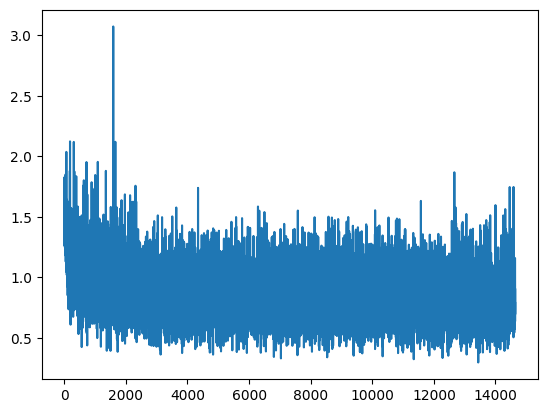

In [32]:
plt.plot(train_losses)

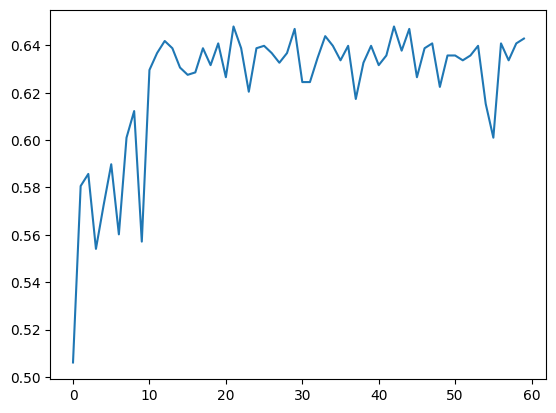

In [33]:
plt.plot(test_accuracy)

In [34]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 630/976 (0.6455)
{'acc_detail': tensor([0.6890, 0.6852, 0.6969, 0.5159], device='cuda:0'),
 'acc_unweighted': tensor(0.6467, device='cuda:0'),
 'acc_weighted': tensor(0.6455, device='cuda:0'),
 'f1s_detail': tensor([0.7368, 0.5725, 0.7269, 0.5497], device='cuda:0'),
 'f1s_unweighted': tensor(0.6465, device='cuda:0'),
 'f1s_weighted': tensor(0.6496, device='cuda:0'),
 'precision_detail': tensor([0.7919, 0.4917, 0.7597, 0.5882], device='cuda:0'),
 'recall_detail': tensor([0.6890, 0.6852, 0.6969, 0.5159], device='cuda:0'),
 'rocauc': tensor(0.8744, device='cuda:0'),
 'rocauc_detail': tensor([0.9229, 0.8456, 0.9127, 0.8165], device='cuda:0'),
 'uar': tensor(0.6467, device='cuda:0'),
 'wap': tensor(0.6645, device='cuda:0')}


tensor([[175,  17,   4,  58],
        [  2, 148,  39,  27],
        [  4,  67, 177,   6],
        [ 40,  69,  13, 130]], device='cuda:0')

In [35]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m14sinc_window_best_22epoch.pt
Correct: 635/976 (0.6506)
{'acc_detail': tensor([0.7244, 0.6157, 0.7165, 0.5397], device='cuda:0'),
 'acc_unweighted': tensor(0.6491, device='cuda:0'),
 'acc_weighted': tensor(0.6506, device='cuda:0'),
 'f1s_detail': tensor([0.7480, 0.5553, 0.7251, 0.5678], device='cuda:0'),
 'f1s_unweighted': tensor(0.6491, device='cuda:0'),
 'f1s_weighted': tensor(0.6529, device='cuda:0'),
 'precision_detail': tensor([0.7731, 0.5057, 0.7339, 0.5991], device='cuda:0'),
 'recall_detail': tensor([0.7244, 0.6157, 0.7165, 0.5397], device='cuda:0'),
 'rocauc': tensor(0.8685, device='cuda:0'),
 'rocauc_detail': tensor([0.9197, 0.8354, 0.9119, 0.8070], device='cuda:0'),
 'uar': tensor(0.6491, device='cuda:0'),
 'wap': tensor(0.6588, device='cuda:0')}


tensor([[184,  15,   4,  51],
        [  4, 133,  47,  32],
        [  5,  59, 182,   8],
        [ 45,  56,  15, 136]], device='cuda:0')

In [36]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_window_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [37]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                           | 0.003278688524590164/40 [00:00<1:11:26, 107.17s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: 0.401094
Mem before-during-after: 34685440 3968993280 38201856


  0%|▎                                                                                           | 0.13442622950819672/40 [00:16<1:22:21, 123.95s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: 0.989279
Mem before-during-after: 38264320 3971478016 38526464


  1%|▌                                                                                           | 0.26557377049180286/40 [00:31<1:21:53, 123.66s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: 0.869381
Mem before-during-after: 39145984 3970920960 38264320


  1%|▉                                                                                              | 0.39672131147541/40 [00:46<1:23:04, 125.87s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: 0.709700
Mem before-during-after: 38395392 3975681024 38526464


  1%|█▏                                                                                           | 0.5278688524590167/40 [01:02<1:16:14, 115.88s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: 0.865571
Mem before-during-after: 38319104 3972571648 39408128


  2%|█▌                                                                                           | 0.6590163934426216/40 [01:17<1:13:55, 112.75s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: 0.613636
Mem before-during-after: 38580736 3973368320 39138304


  2%|█▊                                                                                           | 0.7901639344262266/40 [01:32<1:24:29, 129.30s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: 0.930644
Mem before-during-after: 38526464 3973575168 38264320


  2%|██▍                                                                                             | 0.9999999999999944/40 [01:46<41:58, 64.57s/it]


Test Epoch: 61	Accuracy: 633/976 (65%)



  3%|██▍                                                                                             | 1.0032786885245846/40 [01:47<50:51, 78.24s/it]

Train Epoch: 62 [0/3918 (0%)]	Loss: 0.794064
Mem before-during-after: 38194688 3972463616 38201856


  3%|██▋                                                                                          | 1.1344262295081895/40 [02:02<1:14:10, 114.52s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: 0.988158
Mem before-during-after: 38264320 3725112320 38598656


  3%|██▉                                                                                          | 1.2655737704917944/40 [02:17<1:13:38, 114.08s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: 0.715618
Mem before-during-after: 39408128 3973575168 38264320


  3%|███▏                                                                                         | 1.3967213114753994/40 [02:32<1:12:23, 112.51s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: 1.069024
Mem before-during-after: 39083520 3973575168 38264320


  4%|███▌                                                                                         | 1.5278688524590043/40 [02:47<1:18:23, 122.25s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: 0.809889
Mem before-during-after: 38264320 3974132224 39083520


  4%|███▊                                                                                         | 1.6590163934426092/40 [03:03<1:15:14, 117.73s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: 0.903926
Mem before-during-after: 39408128 3973575168 38264320


  4%|████▏                                                                                        | 1.7901639344262141/40 [03:18<1:11:56, 112.97s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: 0.552993
Mem before-during-after: 39083520 3975006208 39138304


  5%|████▊                                                                                            | 1.999999999999982/40 [03:32<40:31, 63.98s/it]


Test Epoch: 62	Accuracy: 626/976 (64%)



  5%|████▊                                                                                           | 2.0032786885245724/40 [03:32<48:57, 77.30s/it]

Train Epoch: 63 [0/3918 (0%)]	Loss: 0.713749
Mem before-during-after: 38194688 3972463616 38201856


  5%|████▉                                                                                        | 2.1344262295081773/40 [03:47<1:21:40, 129.41s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: 0.987528
Mem before-during-after: 38201856 3973513216 38202368


  6%|█████▎                                                                                        | 2.265573770491782/40 [04:02<1:11:27, 113.63s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: 0.936721
Mem before-during-after: 38319104 3974456832 39408128


  6%|█████▋                                                                                        | 2.396721311475387/40 [04:18<1:19:46, 127.28s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: 0.968540
Mem before-during-after: 39145984 3973018112 38526464


  6%|█████▉                                                                                        | 2.527868852458992/40 [04:33<1:21:49, 131.02s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: 0.712859
Mem before-during-after: 38264320 3806706688 38398976


  7%|██████▏                                                                                       | 2.659016393442597/40 [04:48<1:20:22, 129.14s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: 1.125500
Mem before-during-after: 38264320 3974456832 39408128


  7%|██████▌                                                                                       | 2.790163934426202/40 [05:03<1:15:40, 122.02s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: 0.951064
Mem before-during-after: 39408128 3974132224 38264320


  7%|███████▎                                                                                          | 2.99999999999997/40 [05:18<39:23, 63.88s/it]


Test Epoch: 63	Accuracy: 639/976 (65%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_63epoch.pt


  8%|███████▎                                                                                          | 3.00327868852456/40 [05:18<47:47, 77.51s/it]

Train Epoch: 64 [0/3918 (0%)]	Loss: 0.891169
Mem before-during-after: 38248960 3972549120 38319104


  8%|███████▎                                                                                      | 3.134426229508165/40 [05:33<1:11:35, 116.53s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: 0.885916
Mem before-during-after: 38201856 3974069760 38201856


  8%|███████▊                                                                                       | 3.26557377049177/40 [05:48<1:09:28, 113.47s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: 0.690577
Mem before-during-after: 38264320 3972035072 39083520


  8%|███████▉                                                                                     | 3.3967213114753747/40 [06:04<1:15:41, 124.07s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: 0.975089
Mem before-during-after: 38526464 3971740160 38526464


  9%|████████▏                                                                                    | 3.5278688524589796/40 [06:19<1:15:13, 123.77s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: 0.534817
Mem before-during-after: 38264320 3974511616 39408128


  9%|████████▌                                                                                    | 3.6590163934425846/40 [06:34<1:10:23, 116.22s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: 0.925538
Mem before-during-after: 39138304 3975276544 39408128


  9%|████████▊                                                                                    | 3.7901639344261895/40 [06:49<1:09:32, 115.23s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: 0.782709
Mem before-during-after: 38201856 3971972608 38201856


 10%|█████████▌                                                                                      | 3.9999999999999574/40 [07:03<38:38, 64.41s/it]


Test Epoch: 64	Accuracy: 644/976 (66%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_64epoch.pt


 10%|█████████▌                                                                                      | 4.0032786885245475/40 [07:03<47:58, 79.97s/it]

Train Epoch: 65 [0/3918 (0%)]	Loss: 0.877829
Mem before-during-after: 38194688 3972463616 38201856


 10%|█████████▋                                                                                    | 4.134426229508152/40 [07:18<1:08:39, 114.85s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: 0.526518
Mem before-during-after: 38264320 3972089856 38319104


 11%|██████████                                                                                    | 4.265573770491757/40 [07:33<1:07:06, 112.69s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: 0.856552
Mem before-during-after: 39084032 3974456832 39083520


 11%|██████████▎                                                                                   | 4.396721311475362/40 [07:48<1:08:02, 114.67s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: 1.244490
Mem before-during-after: 39083520 3972621824 39083520


 11%|██████████▋                                                                                   | 4.527868852458967/40 [08:04<1:14:07, 125.38s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: 1.125235
Mem before-during-after: 38201856 3974456832 38526464


 12%|██████████▉                                                                                   | 4.659016393442572/40 [08:19<1:09:04, 117.27s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: 0.714441
Mem before-during-after: 39083520 3972621824 39083520


 12%|███████████▎                                                                                  | 4.790163934426177/40 [08:34<1:08:34, 116.85s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: 1.057555
Mem before-during-after: 38581248 3974140928 39083520


 12%|████████████                                                                                     | 4.999999999999945/40 [08:48<37:08, 63.67s/it]


Test Epoch: 65	Accuracy: 631/976 (64%)



 13%|████████████▏                                                                                    | 5.003278688524535/40 [08:48<45:01, 77.18s/it]

Train Epoch: 66 [0/3918 (0%)]	Loss: 0.601581
Mem before-during-after: 38248960 3972549120 38319104


 13%|████████████▏                                                                                  | 5.13442622950814/40 [09:03<1:06:38, 114.67s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: 0.448943
Mem before-during-after: 38264320 3974132224 39083520


 13%|████████████▎                                                                                 | 5.265573770491745/40 [09:18<1:05:53, 113.81s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: 1.202379
Mem before-during-after: 38264320 3973429760 39137792


 13%|████████████▊                                                                                  | 5.39672131147535/40 [09:34<1:05:38, 113.82s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: 1.216957
Mem before-during-after: 39083520 3975006208 39138304


 14%|████████████▉                                                                                 | 5.527868852458955/40 [09:48<1:06:23, 115.56s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: 0.630134
Mem before-during-after: 39408128 3973575168 38264320


 14%|█████████████▍                                                                                 | 5.65901639344256/40 [10:04<1:05:46, 114.93s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: 0.883295
Mem before-during-after: 39083520 3974718976 39083520


 14%|█████████████▌                                                                                | 5.790163934426165/40 [10:19<1:04:17, 112.76s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: 0.602089
Mem before-during-after: 38264320 3974132224 39083520


 15%|██████████████▍                                                                                 | 5.9999999999999325/40 [10:33<36:23, 64.21s/it]


Test Epoch: 66	Accuracy: 627/976 (64%)



 15%|██████████████▌                                                                                  | 6.003278688524523/40 [10:33<43:51, 77.41s/it]

Train Epoch: 67 [0/3918 (0%)]	Loss: 0.766412
Mem before-during-after: 38248960 3972549120 38319104


 15%|██████████████▎                                                                              | 6.1344262295081275/40 [10:48<1:10:41, 125.26s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: 0.870605
Mem before-during-after: 38350848 3972755968 38201856


 16%|██████████████▌                                                                              | 6.2655737704917325/40 [11:03<1:03:53, 113.62s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: 1.003350
Mem before-during-after: 38319104 3974132736 39083520


 16%|███████████████                                                                               | 6.396721311475337/40 [11:19<1:03:20, 113.08s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: 0.946993
Mem before-during-after: 39083520 3974070272 38202368


 16%|███████████████▎                                                                              | 6.527868852458942/40 [11:34<1:03:23, 113.63s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: 0.854330
Mem before-during-after: 39408128 3973787136 38264320


 17%|███████████████▋                                                                              | 6.659016393442547/40 [11:49<1:19:14, 142.62s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: 0.539323
Mem before-during-after: 38201856 3972359680 38526464


 17%|███████████████▉                                                                              | 6.790163934426152/40 [12:04<1:02:51, 113.56s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: 0.683304
Mem before-during-after: 39083520 3972854272 39083520


 17%|█████████████████▏                                                                                | 6.99999999999992/40 [12:18<37:21, 67.92s/it]


Test Epoch: 67	Accuracy: 608/976 (62%)



 18%|█████████████████▏                                                                                | 7.00327868852451/40 [12:18<43:32, 79.18s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: 0.868672
Mem before-during-after: 38194688 3972464128 38202368


 18%|████████████████▊                                                                             | 7.134426229508115/40 [12:34<1:06:47, 121.93s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: 0.830644
Mem before-during-after: 39408128 3971478016 38264320


 18%|█████████████████▎                                                                             | 7.26557377049172/40 [12:49<1:03:27, 116.33s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: 1.093245
Mem before-during-after: 39408128 3973575168 38264320


 18%|█████████████████▍                                                                            | 7.396721311475325/40 [13:04<1:02:12, 114.47s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: 0.978334
Mem before-during-after: 38264320 3972035072 39083520


 19%|█████████████████▉                                                                             | 7.52786885245893/40 [13:19<1:01:50, 114.26s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: 0.697956
Mem before-during-after: 38264320 3972089856 38264320


 19%|█████████████████▉                                                                            | 7.659016393442535/40 [13:34<1:00:39, 112.53s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: 0.775470
Mem before-during-after: 38264320 3973629952 38319104


 19%|██████████████████▌                                                                            | 7.79016393442614/40 [13:49<1:04:56, 120.97s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: 0.812719
Mem before-during-after: 39083520 3974186496 39137792


 20%|███████████████████▍                                                                             | 7.999999999999908/40 [14:04<33:44, 63.26s/it]


Test Epoch: 68	Accuracy: 604/976 (62%)



 20%|███████████████████▍                                                                             | 8.003278688524498/40 [14:04<40:54, 76.71s/it]

Train Epoch: 69 [0/3918 (0%)]	Loss: 0.933097
Mem before-during-after: 38194688 3972463616 38201856


 20%|███████████████████                                                                           | 8.134426229508103/40 [14:19<1:02:16, 117.25s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: 0.433864
Mem before-during-after: 39083520 3973575168 38264320


 21%|███████████████████▍                                                                          | 8.265573770491708/40 [14:35<1:07:20, 127.31s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: 0.863246
Mem before-during-after: 38526464 3973575168 38264320


 21%|████████████████████▏                                                                           | 8.396721311475313/40 [14:50<59:35, 113.13s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: 0.764261
Mem before-during-after: 38319104 3974132736 39083520


 21%|████████████████████                                                                          | 8.527868852458917/40 [15:05<1:00:06, 114.58s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: 0.708200
Mem before-during-after: 38201856 3972089856 38319104


 22%|████████████████████▎                                                                         | 8.659016393442522/40 [15:20<1:07:14, 128.72s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: 0.998285
Mem before-during-after: 38526464 3974449152 38526464


 22%|█████████████████████                                                                           | 8.790163934426127/40 [15:35<59:01, 113.47s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: 0.757668
Mem before-during-after: 39138304 3972854272 39083520


 22%|█████████████████████▊                                                                           | 8.999999999999895/40 [15:49<33:49, 65.47s/it]


Test Epoch: 69	Accuracy: 639/976 (65%)



 23%|█████████████████████▊                                                                           | 9.003278688524485/40 [15:49<39:47, 77.04s/it]

Train Epoch: 70 [0/3918 (0%)]	Loss: 0.865369
Mem before-during-after: 38194688 3890123264 38201856


 23%|█████████████████████▋                                                                         | 9.13442622950809/40 [16:05<1:04:33, 125.51s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: 0.824740
Mem before-during-after: 39408128 3973018112 38264320


 23%|██████████████████████▏                                                                         | 9.265573770491695/40 [16:20<58:59, 115.18s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: 1.153087
Mem before-during-after: 39408128 3971478016 38264320


 23%|██████████████████████▌                                                                         | 9.3967213114753/40 [16:36<1:04:13, 125.93s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: 0.571583
Mem before-during-after: 38264320 3974132224 38264320


 24%|██████████████████████▊                                                                         | 9.527868852458905/40 [16:51<58:31, 115.24s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: 0.630260
Mem before-during-after: 39083520 3974394880 39084032


 24%|███████████████████████▍                                                                         | 9.65901639344251/40 [17:06<57:50, 114.39s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: 0.570491
Mem before-during-after: 39083520 3971478016 38264320


 24%|███████████████████████▍                                                                        | 9.790163934426115/40 [17:21<57:30, 114.21s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: 0.713702
Mem before-during-after: 39137792 3973621760 38581248


 25%|████████████████████████▏                                                                        | 9.999999999999883/40 [17:35<31:38, 63.30s/it]


Test Epoch: 70	Accuracy: 638/976 (65%)



 25%|████████████████████████                                                                        | 10.003278688524473/40 [17:35<38:34, 77.16s/it]

Train Epoch: 71 [0/3918 (0%)]	Loss: 0.463665
Mem before-during-after: 38248960 3972549120 38319104


 25%|███████████████████████▌                                                                     | 10.134426229508078/40 [17:51<1:08:27, 137.54s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: 0.740508
Mem before-during-after: 38662656 3974178816 39138304


 26%|████████████████████████▍                                                                      | 10.265573770491683/40 [18:06<56:44, 114.50s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: 0.526295
Mem before-during-after: 38201856 3972854272 39083520


 26%|████████████████████████▋                                                                      | 10.396721311475288/40 [18:21<57:04, 115.68s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: 0.950987
Mem before-during-after: 38202368 3972089856 38319104


 26%|█████████████████████████                                                                      | 10.527868852458893/40 [18:36<57:06, 116.25s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: 0.983061
Mem before-during-after: 38526464 3974132224 38264320


 27%|█████████████████████████▎                                                                     | 10.659016393442498/40 [18:52<55:27, 113.40s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: 0.652793
Mem before-during-after: 38264320 3974132224 38264320


 27%|█████████████████████████▋                                                                     | 10.790163934426102/40 [19:07<55:48, 114.62s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: 0.831720
Mem before-during-after: 39083520 3975006208 39083520


 27%|██████████████████████████▋                                                                      | 10.99999999999987/40 [19:21<30:46, 63.69s/it]


Test Epoch: 71	Accuracy: 623/976 (64%)



 28%|██████████████████████████▋                                                                      | 11.00327868852446/40 [19:21<37:35, 77.77s/it]

Train Epoch: 72 [0/3918 (0%)]	Loss: 0.766186
Mem before-during-after: 38248960 3972549120 38319104


 28%|█████████████████████████▉                                                                   | 11.134426229508065/40 [19:36<1:01:33, 127.96s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: 0.918516
Mem before-during-after: 39083520 3974069760 38201856


 28%|███████████████████████████                                                                     | 11.26557377049167/40 [19:51<59:54, 125.10s/it]

Train Epoch: 72 [1280/3918 (33%)]	Loss: 0.825241
Mem before-during-after: 39083520 3971478016 38264320


 28%|███████████████████████████                                                                    | 11.396721311475275/40 [20:07<54:13, 113.75s/it]

Train Epoch: 72 [1920/3918 (49%)]	Loss: 0.992561
Mem before-during-after: 38264320 3972035072 39083520


 29%|███████████████████████████▋                                                                    | 11.52786885245888/40 [20:22<53:54, 113.61s/it]

Train Epoch: 72 [2560/3918 (66%)]	Loss: 0.622017
Mem before-during-after: 39083520 3974132224 38264320


 29%|███████████████████████████▋                                                                   | 11.659016393442485/40 [20:37<53:46, 113.83s/it]

Train Epoch: 72 [3200/3918 (82%)]	Loss: 0.836902
Mem before-during-after: 39137792 3972026880 39083520


 29%|████████████████████████████▎                                                                   | 11.79016393442609/40 [20:52<56:25, 120.00s/it]

Train Epoch: 72 [3840/3918 (98%)]	Loss: 0.832206
Mem before-during-after: 38201856 3973899776 38526464


 30%|████████████████████████████▊                                                                   | 11.999999999999858/40 [21:06<30:08, 64.58s/it]


Test Epoch: 72	Accuracy: 629/976 (64%)



 30%|████████████████████████████▊                                                                   | 12.003278688524448/40 [21:06<35:52, 76.89s/it]

Train Epoch: 73 [0/3918 (0%)]	Loss: 0.556748
Mem before-during-after: 38194688 3890123264 38201856


 30%|████████████████████████████▊                                                                  | 12.134426229508053/40 [21:22<53:05, 114.32s/it]

Train Epoch: 73 [640/3918 (16%)]	Loss: 0.798066
Mem before-during-after: 39138304 3974951936 39083520


 31%|█████████████████████████████▏                                                                 | 12.265573770491658/40 [21:37<57:44, 124.93s/it]

Train Epoch: 73 [1280/3918 (33%)]	Loss: 0.962999
Mem before-during-after: 38403072 3976238080 39083520


 31%|█████████████████████████████▍                                                                 | 12.396721311475263/40 [21:52<51:19, 111.55s/it]

Train Epoch: 73 [1920/3918 (49%)]	Loss: 0.571588
Mem before-during-after: 39138304 3974951424 39083520


 31%|█████████████████████████████▊                                                                 | 12.527868852458868/40 [22:07<52:24, 114.48s/it]

Train Epoch: 73 [2560/3918 (66%)]	Loss: 0.974747
Mem before-during-after: 38319104 3972359680 39408128


 32%|██████████████████████████████                                                                 | 12.659016393442473/40 [22:23<55:37, 122.07s/it]

Train Epoch: 73 [3200/3918 (82%)]	Loss: 1.070489
Mem before-during-after: 38264320 3973841920 38319104


 32%|██████████████████████████████▍                                                                | 12.790163934426078/40 [22:38<50:47, 112.01s/it]

Train Epoch: 73 [3840/3918 (98%)]	Loss: 0.805430
Mem before-during-after: 38264320 3973629952 38319104


 32%|███████████████████████████████▏                                                                | 12.999999999999845/40 [22:52<28:46, 63.95s/it]


Test Epoch: 73	Accuracy: 634/976 (65%)



 33%|███████████████████████████████▏                                                                | 13.003278688524436/40 [22:52<34:49, 77.38s/it]

Train Epoch: 74 [0/3918 (0%)]	Loss: 0.937698
Mem before-during-after: 38248960 3972549120 38319104


 33%|███████████████████████████████▌                                                                | 13.13442622950804/40 [23:08<51:04, 114.08s/it]

Train Epoch: 74 [640/3918 (16%)]	Loss: 0.574310
Mem before-during-after: 39965184 3974132224 38264320


 33%|███████████████████████████████▌                                                               | 13.265573770491645/40 [23:23<55:14, 123.96s/it]

Train Epoch: 74 [1280/3918 (33%)]	Loss: 0.692790
Mem before-during-after: 39084032 3865108992 38316032


 33%|████████████████████████████████▏                                                               | 13.39672131147525/40 [23:38<53:32, 120.76s/it]

Train Epoch: 74 [1920/3918 (49%)]	Loss: 0.599702
Mem before-during-after: 38201856 3974069760 38201856


 34%|████████████████████████████████▏                                                              | 13.527868852458855/40 [23:53<50:12, 113.80s/it]

Train Epoch: 74 [2560/3918 (66%)]	Loss: 0.866809
Mem before-during-after: 39083520 3972621824 39083520


 34%|████████████████████████████████▊                                                               | 13.65901639344246/40 [24:08<54:22, 123.86s/it]

Train Epoch: 74 [3200/3918 (82%)]	Loss: 0.848811
Mem before-during-after: 38231552 3975639552 38526464


 34%|████████████████████████████████▊                                                              | 13.790163934426065/40 [24:23<49:23, 113.08s/it]

Train Epoch: 74 [3840/3918 (98%)]	Loss: 0.799622
Mem before-during-after: 39083520 3974069760 38201856


 35%|█████████████████████████████████▌                                                              | 13.999999999999833/40 [24:37<28:09, 64.99s/it]


Test Epoch: 74	Accuracy: 625/976 (64%)



 35%|█████████████████████████████████▌                                                              | 14.003278688524423/40 [24:38<33:45, 77.91s/it]

Train Epoch: 75 [0/3918 (0%)]	Loss: 0.827446
Mem before-during-after: 38248960 3972549120 38319104


 35%|█████████████████████████████████▌                                                             | 14.134426229508028/40 [24:53<48:34, 112.68s/it]

Train Epoch: 75 [640/3918 (16%)]	Loss: 0.682439
Mem before-during-after: 38264320 3974132224 39083520


 36%|█████████████████████████████████▉                                                             | 14.265573770491633/40 [25:08<48:39, 113.45s/it]

Train Epoch: 75 [1280/3918 (33%)]	Loss: 0.908922
Mem before-during-after: 38319104 3974456832 39408128


 36%|██████████████████████████████████▏                                                            | 14.396721311475238/40 [25:23<51:03, 119.67s/it]

Train Epoch: 75 [1920/3918 (49%)]	Loss: 0.686554
Mem before-during-after: 38264320 3973841920 38319104


 36%|██████████████████████████████████▌                                                            | 14.527868852458843/40 [25:38<48:10, 113.46s/it]

Train Epoch: 75 [2560/3918 (66%)]	Loss: 0.687399
Mem before-during-after: 38319104 3974668800 39408128


 37%|██████████████████████████████████▊                                                            | 14.659016393442448/40 [25:53<48:10, 114.07s/it]

Train Epoch: 75 [3200/3918 (82%)]	Loss: 0.957170
Mem before-during-after: 39083520 3974069760 38201856


 37%|███████████████████████████████████▏                                                           | 14.790163934426053/40 [26:08<56:47, 135.18s/it]

Train Epoch: 75 [3840/3918 (98%)]	Loss: 0.725551
Mem before-during-after: 38998016 3973018112 38264320


 37%|████████████████████████████████████▎                                                            | 14.99999999999982/40 [26:23<26:59, 64.78s/it]


Test Epoch: 75	Accuracy: 623/976 (64%)



 38%|████████████████████████████████████▍                                                            | 15.00327868852441/40 [26:23<32:40, 78.43s/it]

Train Epoch: 76 [0/3918 (0%)]	Loss: 0.886620
Mem before-during-after: 38248960 3972549120 38319104


 38%|███████████████████████████████████▉                                                           | 15.134426229508016/40 [26:38<47:14, 114.01s/it]

Train Epoch: 76 [640/3918 (16%)]	Loss: 0.813989
Mem before-during-after: 38264320 3974132224 39083520


 38%|████████████████████████████████████▋                                                           | 15.26557377049162/40 [26:53<48:43, 118.20s/it]

Train Epoch: 76 [1280/3918 (33%)]	Loss: 0.611920
Mem before-during-after: 38264320 3973629952 38319104


 38%|████████████████████████████████████▌                                                          | 15.396721311475225/40 [27:08<47:20, 115.44s/it]

Train Epoch: 76 [1920/3918 (49%)]	Loss: 1.082311
Mem before-during-after: 38256128 3974178816 39138304


 39%|█████████████████████████████████████▎                                                          | 15.52786885245883/40 [27:24<49:02, 120.25s/it]

Train Epoch: 76 [2560/3918 (66%)]	Loss: 0.676065
Mem before-during-after: 38201856 3974951424 39083520


 39%|█████████████████████████████████████▏                                                         | 15.659016393442435/40 [27:39<45:38, 112.52s/it]

Train Epoch: 76 [3200/3918 (82%)]	Loss: 0.623341
Mem before-during-after: 38264320 3974132224 39083520


 39%|█████████████████████████████████████▉                                                          | 15.79016393442604/40 [27:54<46:07, 114.31s/it]

Train Epoch: 76 [3840/3918 (98%)]	Loss: 1.002590
Mem before-during-after: 39083520 3974069760 38201856


 40%|██████████████████████████████████████▍                                                         | 15.999999999999808/40 [28:08<25:37, 64.05s/it]


Test Epoch: 76	Accuracy: 596/976 (61%)



 40%|███████████████████████████████████████▏                                                          | 16.0032786885244/40 [28:09<30:49, 77.08s/it]

Train Epoch: 77 [0/3918 (0%)]	Loss: 0.755719
Mem before-during-after: 38194688 3972463616 38201856


 40%|██████████████████████████████████████▎                                                        | 16.134426229508076/40 [28:24<44:35, 112.13s/it]

Train Epoch: 77 [640/3918 (16%)]	Loss: 0.736202
Mem before-during-after: 38581248 3974951424 39083520


 41%|██████████████████████████████████████▋                                                        | 16.265573770491752/40 [28:39<49:20, 124.73s/it]

Train Epoch: 77 [1280/3918 (33%)]	Loss: 0.978343
Mem before-during-after: 38526464 3973259264 38201856


 41%|██████████████████████████████████████▉                                                        | 16.396721311475428/40 [28:56<45:42, 116.17s/it]

Train Epoch: 77 [1920/3918 (49%)]	Loss: 0.858037
Mem before-during-after: 39137792 3846265856 38749696


 41%|███████████████████████████████████████▎                                                       | 16.527868852459104/40 [29:11<48:52, 124.94s/it]

Train Epoch: 77 [2560/3918 (66%)]	Loss: 0.756938
Mem before-during-after: 38231552 3975082496 38526464


 42%|███████████████████████████████████████▉                                                        | 16.65901639344278/40 [29:26<45:48, 117.76s/it]

Train Epoch: 77 [3200/3918 (82%)]	Loss: 0.620310
Mem before-during-after: 39083520 3974132224 38264320


 42%|███████████████████████████████████████▉                                                       | 16.790163934426456/40 [29:41<43:18, 111.98s/it]

Train Epoch: 77 [3840/3918 (98%)]	Loss: 0.883171
Mem before-during-after: 38319104 3972035072 39083520


 43%|████████████████████████████████████████▊                                                       | 17.000000000000338/40 [29:55<24:48, 64.71s/it]


Test Epoch: 77	Accuracy: 602/976 (61%)



 43%|█████████████████████████████████████████▏                                                       | 17.00327868852493/40 [29:55<29:42, 77.52s/it]

Train Epoch: 78 [0/3918 (0%)]	Loss: 0.938759
Mem before-during-after: 38248960 3972549120 38319104


 43%|█████████████████████████████████████████▏                                                      | 17.137704918033197/40 [30:11<37:49, 99.26s/it]

Train Epoch: 78 [640/3918 (16%)]	Loss: 0.586099
Mem before-during-after: 39408128 3973575168 38264320


 43%|█████████████████████████████████████████▍                                                      | 17.26557377049228/40 [30:26<43:09, 113.92s/it]

Train Epoch: 78 [1280/3918 (33%)]	Loss: 0.649981
Mem before-during-after: 39083520 3974132224 38264320


 43%|█████████████████████████████████████████▎                                                     | 17.396721311475957/40 [30:41<44:38, 118.51s/it]

Train Epoch: 78 [1920/3918 (49%)]	Loss: 0.666052
Mem before-during-after: 38264320 3973629952 38319104


 44%|█████████████████████████████████████████▋                                                     | 17.527868852459633/40 [30:56<43:21, 115.77s/it]

Train Epoch: 78 [2560/3918 (66%)]	Loss: 0.775065
Mem before-during-after: 39083520 3975006208 39138304


 44%|██████████████████████████████████████████▍                                                     | 17.65901639344331/40 [31:11<42:37, 114.48s/it]

Train Epoch: 78 [3200/3918 (82%)]	Loss: 1.074538
Mem before-during-after: 39083520 3974394368 39083520


 44%|██████████████████████████████████████████▎                                                    | 17.790163934426985/40 [31:26<42:02, 113.58s/it]

Train Epoch: 78 [3840/3918 (98%)]	Loss: 0.557277
Mem before-during-after: 39084032 3973575168 39083520


 45%|███████████████████████████████████████████▏                                                    | 18.000000000000867/40 [31:40<23:31, 64.15s/it]


Test Epoch: 78	Accuracy: 639/976 (65%)



 45%|███████████████████████████████████████████▋                                                     | 18.00327868852546/40 [31:40<28:03, 76.51s/it]

Train Epoch: 79 [0/3918 (0%)]	Loss: 1.289583
Mem before-during-after: 38194688 3972464128 38202368


 45%|███████████████████████████████████████████                                                    | 18.134426229509135/40 [31:55<42:03, 115.41s/it]

Train Epoch: 79 [640/3918 (16%)]	Loss: 0.537050
Mem before-during-after: 38264320 3974132224 39083520


 46%|███████████████████████████████████████████▊                                                    | 18.26557377049281/40 [32:10<41:43, 115.18s/it]

Train Epoch: 79 [1280/3918 (33%)]	Loss: 0.873816
Mem before-during-after: 39083520 3972297216 39083520


 46%|███████████████████████████████████████████▋                                                   | 18.396721311476487/40 [32:25<41:53, 116.33s/it]

Train Epoch: 79 [1920/3918 (49%)]	Loss: 1.318979
Mem before-during-after: 38201856 3971972608 38201856


 46%|████████████████████████████████████████████                                                   | 18.527868852460163/40 [32:40<40:53, 114.26s/it]

Train Epoch: 79 [2560/3918 (66%)]	Loss: 0.906531
Mem before-during-after: 38264320 3972035072 39083520


 47%|████████████████████████████████████████████▊                                                   | 18.65901639344384/40 [32:56<43:16, 121.65s/it]

Train Epoch: 79 [3200/3918 (82%)]	Loss: 1.155707
Mem before-during-after: 39083520 3974606336 39083520


 47%|████████████████████████████████████████████▋                                                  | 18.790163934427515/40 [33:11<41:05, 116.24s/it]

Train Epoch: 79 [3840/3918 (98%)]	Loss: 0.590202
Mem before-during-after: 38201856 3807303168 38201856


 48%|█████████████████████████████████████████████▌                                                  | 19.000000000001396/40 [33:25<22:40, 64.79s/it]


Test Epoch: 79	Accuracy: 609/976 (62%)



 48%|█████████████████████████████████████████████▌                                                  | 19.003278688525988/40 [33:25<26:52, 76.81s/it]

Train Epoch: 80 [0/3918 (0%)]	Loss: 0.823102
Mem before-during-after: 38248960 3972549120 38319104


 48%|█████████████████████████████████████████████▍                                                 | 19.134426229509664/40 [33:41<39:21, 113.17s/it]

Train Epoch: 80 [640/3918 (16%)]	Loss: 0.898284
Mem before-during-after: 38264320 3974132224 39083520


 48%|██████████████████████████████████████████████▏                                                 | 19.26557377049334/40 [33:56<43:29, 125.86s/it]

Train Epoch: 80 [1280/3918 (33%)]	Loss: 0.965412
Mem before-during-after: 38247936 3974140928 39083520


 48%|██████████████████████████████████████████████                                                 | 19.396721311477016/40 [34:11<38:46, 112.90s/it]

Train Epoch: 80 [1920/3918 (49%)]	Loss: 0.834982
Mem before-during-after: 38201856 3972089856 38319104


 49%|██████████████████████████████████████████████▍                                                | 19.527868852460692/40 [34:27<44:18, 129.87s/it]

Train Epoch: 80 [2560/3918 (66%)]	Loss: 0.775072
Mem before-during-after: 38513152 3973575168 38264320


 49%|███████████████████████████████████████████████▋                                                 | 19.66229508196896/40 [34:42<33:25, 98.59s/it]

Train Epoch: 80 [3200/3918 (82%)]	Loss: 0.860930
Mem before-during-after: 38264320 3972035072 39083520


 49%|███████████████████████████████████████████████                                                | 19.790163934428044/40 [34:57<39:13, 116.47s/it]

Train Epoch: 80 [3840/3918 (98%)]	Loss: 0.973760
Mem before-during-after: 38201856 3971972608 38201856


 50%|████████████████████████████████████████████████                                                | 20.000000000001926/40 [35:11<21:14, 63.72s/it]


Test Epoch: 80	Accuracy: 621/976 (63%)



 50%|████████████████████████████████████████████████                                                | 20.003278688526517/40 [35:12<25:41, 77.08s/it]

Train Epoch: 81 [0/3918 (0%)]	Loss: 0.919009
Mem before-during-after: 38248960 3972549120 38319104


 50%|███████████████████████████████████████████████▊                                               | 20.134426229510193/40 [35:27<38:30, 116.30s/it]

Train Epoch: 81 [640/3918 (16%)]	Loss: 1.255136
Mem before-during-after: 38526464 3972098560 39083520


 51%|████████████████████████████████████████████████▋                                               | 20.26557377049387/40 [35:42<37:26, 113.82s/it]

Train Epoch: 81 [1280/3918 (33%)]	Loss: 0.758150
Mem before-during-after: 38264320 3974132224 39083520


 51%|████████████████████████████████████████████████▍                                              | 20.396721311477545/40 [35:58<37:41, 115.37s/it]

Train Epoch: 81 [1920/3918 (49%)]	Loss: 0.942068
Mem before-during-after: 39408128 3974132224 38264320


 51%|█████████████████████████████████████████████████▎                                              | 20.52786885246122/40 [36:13<39:46, 122.58s/it]

Train Epoch: 81 [2560/3918 (66%)]	Loss: 0.873193
Mem before-during-after: 38264320 3974187008 38264320


 52%|█████████████████████████████████████████████████                                              | 20.659016393444897/40 [36:28<36:37, 113.60s/it]

Train Epoch: 81 [3200/3918 (82%)]	Loss: 1.157746
Mem before-during-after: 38264320 3972089856 38319104


 52%|█████████████████████████████████████████████████▍                                             | 20.790163934428573/40 [36:43<36:47, 114.93s/it]

Train Epoch: 81 [3840/3918 (98%)]	Loss: 0.418588
Mem before-during-after: 38264320 3973629952 38319104


 53%|██████████████████████████████████████████████████▍                                             | 21.000000000002455/40 [36:57<20:35, 65.05s/it]


Test Epoch: 81	Accuracy: 627/976 (64%)



 53%|██████████████████████████████████████████████████▍                                             | 21.003278688527047/40 [36:57<24:01, 75.88s/it]

Train Epoch: 82 [0/3918 (0%)]	Loss: 0.684095
Mem before-during-after: 38248960 3807714816 38226432


 53%|██████████████████████████████████████████████████▋                                             | 21.137704918035315/40 [37:13<30:32, 97.15s/it]

Train Epoch: 82 [640/3918 (16%)]	Loss: 1.241531
Mem before-during-after: 39083520 3975006208 39138304


 53%|███████████████████████████████████████████████████▌                                             | 21.2655737704944/40 [37:28<36:09, 115.82s/it]

Train Epoch: 82 [1280/3918 (33%)]	Loss: 1.251927
Mem before-during-after: 38201856 3974141440 38202368


 53%|██████████████████████████████████████████████████▊                                            | 21.396721311478075/40 [37:43<37:17, 120.26s/it]

Train Epoch: 82 [1920/3918 (49%)]	Loss: 0.882977
Mem before-during-after: 39408128 3971478016 38264320


 54%|███████████████████████████████████████████████████▋                                            | 21.52786885246175/40 [37:59<38:21, 124.59s/it]

Train Epoch: 82 [2560/3918 (66%)]	Loss: 1.221650
Mem before-during-after: 38264320 3641650176 38256640


 54%|███████████████████████████████████████████████████▍                                           | 21.659016393445427/40 [38:14<34:40, 113.41s/it]

Train Epoch: 82 [3200/3918 (82%)]	Loss: 0.870428
Mem before-during-after: 38264320 3974132224 39083520


 54%|███████████████████████████████████████████████████▊                                           | 21.790163934429103/40 [38:29<40:21, 132.99s/it]

Train Epoch: 82 [3840/3918 (98%)]	Loss: 0.866588
Mem before-during-after: 38412288 3973471232 38201856


 55%|████████████████████████████████████████████████████▊                                           | 22.000000000002984/40 [38:43<19:17, 64.30s/it]


Test Epoch: 82	Accuracy: 626/976 (64%)



 55%|████████████████████████████████████████████████████▊                                           | 22.003278688527576/40 [38:44<23:12, 77.36s/it]

Train Epoch: 83 [0/3918 (0%)]	Loss: 0.909448
Mem before-during-after: 38248960 3972549120 38319104


 55%|████████████████████████████████████████████████████▌                                          | 22.134426229511252/40 [38:59<34:16, 115.09s/it]

Train Epoch: 83 [640/3918 (16%)]	Loss: 1.264929
Mem before-during-after: 39083520 3641657856 38644736


 56%|████████████████████████████████████████████████████▉                                          | 22.265573770494928/40 [39:14<33:34, 113.59s/it]

Train Epoch: 83 [1280/3918 (33%)]	Loss: 0.806820
Mem before-during-after: 38201856 3974132224 38264320


 56%|█████████████████████████████████████████████████████▏                                         | 22.396721311478604/40 [39:29<33:51, 115.41s/it]

Train Epoch: 83 [1920/3918 (49%)]	Loss: 0.628531
Mem before-during-after: 39083520 3807310848 38280704


 56%|██████████████████████████████████████████████████████                                          | 22.52786885246228/40 [39:44<33:04, 113.56s/it]

Train Epoch: 83 [2560/3918 (66%)]	Loss: 1.477199
Mem before-during-after: 39083520 3973837312 39083520


 57%|█████████████████████████████████████████████████████▊                                         | 22.659016393445956/40 [39:59<33:36, 116.29s/it]

Train Epoch: 83 [3200/3918 (82%)]	Loss: 0.832813
Mem before-during-after: 39083520 3971740160 39083520


 57%|██████████████████████████████████████████████████████▏                                        | 22.790163934429632/40 [40:14<33:10, 115.64s/it]

Train Epoch: 83 [3840/3918 (98%)]	Loss: 0.684573
Mem before-during-after: 39083520 3974070272 38202368


 58%|███████████████████████████████████████████████████████▏                                        | 23.000000000003514/40 [40:28<18:11, 64.18s/it]


Test Epoch: 83	Accuracy: 636/976 (65%)



 58%|███████████████████████████████████████████████████████▏                                        | 23.003278688528106/40 [40:29<21:44, 76.75s/it]

Train Epoch: 84 [0/3918 (0%)]	Loss: 0.650649
Mem before-during-after: 38248960 3972549120 38319104


 58%|███████████████████████████████████████████████████████▌                                        | 23.13442622951178/40 [40:44<32:03, 114.08s/it]

Train Epoch: 84 [640/3918 (16%)]	Loss: 0.613397
Mem before-during-after: 39084032 3973575168 39083520


 58%|███████████████████████████████████████████████████████▎                                       | 23.265573770495457/40 [40:59<32:31, 116.63s/it]

Train Epoch: 84 [1280/3918 (33%)]	Loss: 0.578930
Mem before-during-after: 38319104 3972359680 39408128


 58%|███████████████████████████████████████████████████████▌                                       | 23.396721311479133/40 [41:14<31:38, 114.37s/it]

Train Epoch: 84 [1920/3918 (49%)]	Loss: 0.598765
Mem before-during-after: 38264320 3971332608 39137792


 59%|████████████████████████████████████████████████████████▍                                       | 23.52786885246281/40 [41:29<31:16, 113.95s/it]

Train Epoch: 84 [2560/3918 (66%)]	Loss: 0.751786
Mem before-during-after: 38264320 3974132224 39083520


 59%|████████████████████████████████████████████████████████▏                                      | 23.659016393446485/40 [41:45<33:09, 121.78s/it]

Train Epoch: 84 [3200/3918 (82%)]	Loss: 0.503785
Mem before-during-after: 39138304 3974951936 39083520


 59%|█████████████████████████████████████████████████████████                                       | 23.79016393443016/40 [42:00<30:05, 111.39s/it]

Train Epoch: 84 [3840/3918 (98%)]	Loss: 0.942560
Mem before-during-after: 39083520 3845766144 38280704


 60%|█████████████████████████████████████████████████████████▌                                      | 24.000000000004043/40 [42:14<17:06, 64.18s/it]


Test Epoch: 84	Accuracy: 641/976 (65%)



 60%|█████████████████████████████████████████████████████████▌                                      | 24.003278688528635/40 [42:15<20:23, 76.46s/it]

Train Epoch: 85 [0/3918 (0%)]	Loss: 0.585171
Mem before-during-after: 38194688 3972463616 38201856


 60%|█████████████████████████████████████████████████████████▉                                      | 24.13442622951231/40 [42:30<31:15, 118.23s/it]

Train Epoch: 85 [640/3918 (16%)]	Loss: 0.752264
Mem before-during-after: 39083520 3972297216 39083520


 61%|█████████████████████████████████████████████████████████▋                                     | 24.265573770495987/40 [42:45<31:06, 118.64s/it]

Train Epoch: 85 [1280/3918 (33%)]	Loss: 0.380233
Mem before-during-after: 39083520 3972297216 39083520


 61%|█████████████████████████████████████████████████████████▉                                     | 24.396721311479663/40 [43:00<30:23, 116.84s/it]

Train Epoch: 85 [1920/3918 (49%)]	Loss: 0.814347
Mem before-during-after: 38201856 3972184576 38201856


 61%|██████████████████████████████████████████████████████████▊                                     | 24.52786885246334/40 [43:15<29:06, 112.86s/it]

Train Epoch: 85 [2560/3918 (66%)]	Loss: 0.750697
Mem before-during-after: 39137792 3974124032 39083520


 62%|██████████████████████████████████████████████████████████▌                                    | 24.659016393447015/40 [43:30<31:26, 122.98s/it]

Train Epoch: 85 [3200/3918 (82%)]	Loss: 0.613418
Mem before-during-after: 39138304 3975276032 39408128


 62%|███████████████████████████████████████████████████████████▍                                    | 24.79016393443069/40 [43:46<31:04, 122.55s/it]

Train Epoch: 85 [3840/3918 (98%)]	Loss: 0.681282
Mem before-during-after: 38264320 3973250560 38201856


 63%|████████████████████████████████████████████████████████████                                    | 25.000000000004572/40 [44:00<15:55, 63.72s/it]


Test Epoch: 85	Accuracy: 620/976 (63%)



 63%|████████████████████████████████████████████████████████████                                    | 25.003278688529164/40 [44:00<19:19, 77.32s/it]

Train Epoch: 86 [0/3918 (0%)]	Loss: 0.758409
Mem before-during-after: 38194688 3972463616 38201856


 63%|████████████████████████████████████████████████████████████▎                                   | 25.13442622951284/40 [44:15<27:53, 112.58s/it]

Train Epoch: 86 [640/3918 (16%)]	Loss: 0.795121
Mem before-during-after: 39083520 3974132224 38264320


 63%|████████████████████████████████████████████████████████████                                   | 25.265573770496516/40 [44:31<27:34, 112.27s/it]

Train Epoch: 86 [1280/3918 (33%)]	Loss: 0.765335
Mem before-during-after: 39965184 3974132224 38264320


 63%|████████████████████████████████████████████████████████████▎                                  | 25.396721311480192/40 [44:46<27:08, 111.52s/it]

Train Epoch: 86 [1920/3918 (49%)]	Loss: 0.820515
Mem before-during-after: 39083520 3917029888 38201856


 64%|████████████████████████████████████████████████████████████▋                                  | 25.527868852463868/40 [45:01<29:14, 121.20s/it]

Train Epoch: 86 [2560/3918 (66%)]	Loss: 0.488977
Mem before-during-after: 39408128 3971478016 38264320


 64%|████████████████████████████████████████████████████████████▉                                  | 25.659016393447544/40 [45:16<26:30, 110.90s/it]

Train Epoch: 86 [3200/3918 (82%)]	Loss: 1.010492
Mem before-during-after: 39137792 3916634624 38392320


 64%|█████████████████████████████████████████████████████████████▉                                  | 25.79016393443122/40 [45:31<27:23, 115.63s/it]

Train Epoch: 86 [3840/3918 (98%)]	Loss: 0.611096
Mem before-during-after: 38526464 3974449152 38581248


 65%|███████████████████████████████████████████████████████████████▋                                  | 26.0000000000051/40 [45:45<15:15, 65.38s/it]


Test Epoch: 86	Accuracy: 622/976 (63%)



 65%|██████████████████████████████████████████████████████████████▍                                 | 26.003278688529694/40 [45:45<18:04, 77.51s/it]

Train Epoch: 87 [0/3918 (0%)]	Loss: 0.854523
Mem before-during-after: 38248960 3972549120 38319104


 65%|██████████████████████████████████████████████████████████████▋                                 | 26.13442622951337/40 [46:01<26:56, 116.57s/it]

Train Epoch: 87 [640/3918 (16%)]	Loss: 0.841795
Mem before-during-after: 38201856 3974069760 38201856


 66%|██████████████████████████████████████████████████████████████▍                                | 26.265573770497046/40 [46:16<27:48, 121.48s/it]

Train Epoch: 87 [1280/3918 (33%)]	Loss: 0.483658
Mem before-during-after: 38264320 3973575168 38526464


 66%|███████████████████████████████████████████████████████████████▎                                | 26.39672131148072/40 [46:31<26:16, 115.87s/it]

Train Epoch: 87 [1920/3918 (49%)]	Loss: 1.156302
Mem before-during-after: 38526464 3973259264 38201856


 66%|███████████████████████████████████████████████████████████████                                | 26.527868852464398/40 [46:46<25:52, 115.25s/it]

Train Epoch: 87 [2560/3918 (66%)]	Loss: 0.705495
Mem before-during-after: 39965184 3972035072 38264320


 67%|███████████████████████████████████████████████████████████████▎                               | 26.659016393448074/40 [47:01<25:13, 113.48s/it]

Train Epoch: 87 [3200/3918 (82%)]	Loss: 0.740931
Mem before-during-after: 39083520 3971740160 39083520


 67%|████████████████████████████████████████████████████████████████▎                               | 26.79016393443175/40 [47:17<25:06, 114.01s/it]

Train Epoch: 87 [3840/3918 (98%)]	Loss: 0.599439
Mem before-during-after: 38264320 3973629952 38319104


 68%|█████████████████████████████████████████████████████████████████▍                               | 27.00000000000563/40 [47:31<13:51, 63.98s/it]


Test Epoch: 87	Accuracy: 571/976 (58%)



 68%|████████████████████████████████████████████████████████████████▊                               | 27.003278688530223/40 [47:31<16:41, 77.08s/it]

Train Epoch: 88 [0/3918 (0%)]	Loss: 0.753643
Mem before-during-after: 38248960 3972549120 38319104


 68%|█████████████████████████████████████████████████████████████████▊                               | 27.1344262295139/40 [47:46<24:14, 113.08s/it]

Train Epoch: 88 [640/3918 (16%)]	Loss: 0.996256
Mem before-during-after: 38264320 3974132224 39083520


 68%|████████████████████████████████████████████████████████████████▊                              | 27.265573770497575/40 [48:02<26:56, 126.91s/it]

Train Epoch: 88 [1280/3918 (33%)]	Loss: 0.461223
Mem before-during-after: 38264320 3974132224 39083520


 68%|█████████████████████████████████████████████████████████████████▊                              | 27.39672131148125/40 [48:17<23:42, 112.84s/it]

Train Epoch: 88 [1920/3918 (49%)]	Loss: 1.146737
Mem before-during-after: 39138304 3972854784 39083520


 69%|█████████████████████████████████████████████████████████████████▍                             | 27.527868852464927/40 [48:32<25:43, 123.78s/it]

Train Epoch: 88 [2560/3918 (66%)]	Loss: 0.869272
Mem before-during-after: 38231552 3975694336 38581248


 69%|█████████████████████████████████████████████████████████████████▋                             | 27.659016393448603/40 [48:47<23:32, 114.45s/it]

Train Epoch: 88 [3200/3918 (82%)]	Loss: 0.616246
Mem before-during-after: 39084032 3973575168 39083520


 69%|██████████████████████████████████████████████████████████████████▋                             | 27.79016393443228/40 [49:02<23:14, 114.21s/it]

Train Epoch: 88 [3840/3918 (98%)]	Loss: 0.738546
Mem before-during-after: 39965184 3972035072 38264320


 70%|███████████████████████████████████████████████████████████████████▉                             | 28.00000000000616/40 [49:16<12:58, 64.85s/it]


Test Epoch: 88	Accuracy: 630/976 (64%)



 70%|███████████████████████████████████████████████████████████████████▏                            | 28.003278688530752/40 [49:17<15:25, 77.16s/it]

Train Epoch: 89 [0/3918 (0%)]	Loss: 0.572940
Mem before-during-after: 38248960 3972549120 38319104


 70%|███████████████████████████████████████████████████████████████████▌                            | 28.13442622951443/40 [49:32<24:02, 121.58s/it]

Train Epoch: 89 [640/3918 (16%)]	Loss: 0.756875
Mem before-during-after: 38264320 3973575168 38526464


 71%|███████████████████████████████████████████████████████████████████▏                           | 28.265573770498104/40 [49:47<23:14, 118.87s/it]

Train Epoch: 89 [1280/3918 (33%)]	Loss: 0.815706
Mem before-during-after: 38264320 3974187008 39083520


 71%|████████████████████████████████████████████████████████████████████▏                           | 28.39672131148178/40 [50:02<24:20, 125.89s/it]

Train Epoch: 89 [1920/3918 (49%)]	Loss: 0.761348
Mem before-during-after: 39083520 3973575168 38264320


 71%|███████████████████████████████████████████████████████████████████▊                           | 28.527868852465456/40 [50:18<24:34, 128.53s/it]

Train Epoch: 89 [2560/3918 (66%)]	Loss: 0.941475
Mem before-during-after: 38403072 3973250560 38201856


 72%|████████████████████████████████████████████████████████████████████                           | 28.659016393449132/40 [50:33<22:14, 117.64s/it]

Train Epoch: 89 [3200/3918 (82%)]	Loss: 0.442311
Mem before-during-after: 38201856 3974951936 39084032


 72%|████████████████████████████████████████████████████████████████████▍                          | 28.790163934432808/40 [50:49<21:30, 115.12s/it]

Train Epoch: 89 [3840/3918 (98%)]	Loss: 0.906949
Mem before-during-after: 38264320 3973575168 38526464


 73%|██████████████████████████████████████████████████████████████████████▎                          | 29.00000000000669/40 [51:03<11:46, 64.23s/it]


Test Epoch: 89	Accuracy: 623/976 (64%)



 73%|██████████████████████████████████████████████████████████████████████▎                          | 29.00327868853128/40 [51:03<14:12, 77.51s/it]

Train Epoch: 90 [0/3918 (0%)]	Loss: 0.880138
Mem before-during-after: 38248960 3972549120 38319104


 73%|█████████████████████████████████████████████████████████████████████▏                         | 29.134426229514958/40 [51:18<20:29, 113.18s/it]

Train Epoch: 90 [640/3918 (16%)]	Loss: 0.953455
Mem before-during-after: 38264320 3974132224 38264320


 73%|█████████████████████████████████████████████████████████████████████▌                         | 29.265573770498634/40 [51:33<20:11, 112.88s/it]

Train Epoch: 90 [1280/3918 (33%)]	Loss: 1.230476
Mem before-during-after: 38264320 3974132224 39083520


 73%|██████████████████████████████████████████████████████████████████████▌                         | 29.39672131148231/40 [51:49<20:32, 116.27s/it]

Train Epoch: 90 [1920/3918 (49%)]	Loss: 0.895039
Mem before-during-after: 38526464 3974132224 38264320


 74%|██████████████████████████████████████████████████████████████████████▏                        | 29.527868852465986/40 [52:04<19:33, 112.02s/it]

Train Epoch: 90 [2560/3918 (66%)]	Loss: 0.962612
Mem before-during-after: 39083520 3973575168 38264320


 74%|███████████████████████████████████████████████████████████████████████▏                        | 29.65901639344966/40 [52:19<19:33, 113.47s/it]

Train Epoch: 90 [3200/3918 (82%)]	Loss: 0.802932
Mem before-during-after: 38319104 3974132224 39083520


 74%|██████████████████████████████████████████████████████████████████████▊                        | 29.790163934433338/40 [52:34<19:31, 114.76s/it]

Train Epoch: 90 [3840/3918 (98%)]	Loss: 0.698859
Mem before-during-after: 39083520 3974394368 39083520


 75%|████████████████████████████████████████████████████████████████████████▊                        | 30.00000000000722/40 [52:49<10:39, 64.00s/it]


Test Epoch: 90	Accuracy: 637/976 (65%)



 75%|████████████████████████████████████████████████████████████████████████▊                        | 30.00327868853181/40 [52:49<12:54, 77.49s/it]

Train Epoch: 91 [0/3918 (0%)]	Loss: 0.604578
Mem before-during-after: 38194688 3972463616 38201856


 75%|███████████████████████████████████████████████████████████████████████▌                       | 30.134426229515487/40 [53:04<21:06, 128.36s/it]

Train Epoch: 91 [640/3918 (16%)]	Loss: 0.885254
Mem before-during-after: 39083520 3974951424 39083520


 76%|███████████████████████████████████████████████████████████████████████▉                       | 30.265573770499163/40 [53:19<18:50, 116.15s/it]

Train Epoch: 91 [1280/3918 (33%)]	Loss: 1.152532
Mem before-during-after: 39083520 3974951424 39083520


 76%|████████████████████████████████████████████████████████████████████████▉                       | 30.39672131148284/40 [53:35<20:22, 127.29s/it]

Train Epoch: 91 [1920/3918 (49%)]	Loss: 0.908244
Mem before-during-after: 38897664 3973376512 38319104


 76%|████████████████████████████████████████████████████████████████████████▌                      | 30.527868852466515/40 [53:50<18:48, 119.17s/it]

Train Epoch: 91 [2560/3918 (66%)]	Loss: 0.701434
Mem before-during-after: 39083520 3973837312 38526464


 77%|█████████████████████████████████████████████████████████████████████████▌                      | 30.65901639345019/40 [54:05<17:42, 113.79s/it]

Train Epoch: 91 [3200/3918 (82%)]	Loss: 0.537659
Mem before-during-after: 38264320 3972089856 38319104


 77%|█████████████████████████████████████████████████████████████████████████▏                     | 30.790163934433867/40 [54:20<18:28, 120.37s/it]

Train Epoch: 91 [3840/3918 (98%)]	Loss: 0.451687
Mem before-during-after: 38201856 3973575168 38264320


 78%|███████████████████████████████████████████████████████████████████████████▏                     | 31.00000000000775/40 [54:35<10:05, 67.32s/it]


Test Epoch: 91	Accuracy: 637/976 (65%)



 78%|███████████████████████████████████████████████████████████████████████████▏                     | 31.00327868853234/40 [54:35<11:54, 79.40s/it]

Train Epoch: 92 [0/3918 (0%)]	Loss: 1.054118
Mem before-during-after: 38248960 3972549120 38319104


 78%|█████████████████████████████████████████████████████████████████████████▉                     | 31.134426229516016/40 [54:50<18:44, 126.85s/it]

Train Epoch: 92 [640/3918 (16%)]	Loss: 0.756768
Mem before-during-after: 38392320 3974822912 38526464


 78%|██████████████████████████████████████████████████████████████████████████▎                    | 31.265573770499692/40 [55:05<16:22, 112.43s/it]

Train Epoch: 92 [1280/3918 (33%)]	Loss: 0.594302
Mem before-during-after: 39083520 3974718976 39083520


 79%|████████████████████████████████████████████████████████████████████████████▏                    | 31.40000000000796/40 [55:21<14:05, 98.30s/it]

Train Epoch: 92 [1920/3918 (49%)]	Loss: 0.799057
Mem before-during-after: 39083520 3972622336 39084032


 79%|██████████████████████████████████████████████████████████████████████████▉                    | 31.527868852467044/40 [55:36<16:11, 114.68s/it]

Train Epoch: 92 [2560/3918 (66%)]	Loss: 1.013943
Mem before-during-after: 39083520 3972297216 39083520


 79%|███████████████████████████████████████████████████████████████████████████▉                    | 31.65901639345072/40 [55:51<16:04, 115.68s/it]

Train Epoch: 92 [3200/3918 (82%)]	Loss: 0.625442
Mem before-during-after: 38201856 3974069760 38201856


 79%|███████████████████████████████████████████████████████████████████████████▌                   | 31.790163934434396/40 [56:06<16:29, 120.50s/it]

Train Epoch: 92 [3840/3918 (98%)]	Loss: 0.921794
Mem before-during-after: 39084032 3974718976 39083520


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 32.00000000000828/40 [56:20<08:31, 63.89s/it]


Test Epoch: 92	Accuracy: 639/976 (65%)



 80%|████████████████████████████████████████████████████████████████████████████▊                   | 32.003278688532866/40 [56:21<10:17, 77.19s/it]

Train Epoch: 93 [0/3918 (0%)]	Loss: 0.840950
Mem before-during-after: 38194688 3972463616 38201856


 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 32.13770491804099/40 [56:36<12:47, 97.59s/it]

Train Epoch: 93 [640/3918 (16%)]	Loss: 0.960877
Mem before-during-after: 39083520 3971972608 38201856


 81%|████████████████████████████████████████████████████████████████████████████▋                  | 32.265573770499934/40 [56:50<14:19, 111.09s/it]

Train Epoch: 93 [1280/3918 (33%)]	Loss: 0.722341
Mem before-during-after: 39083520 3973787136 38264320


 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 32.39672131148347/40 [57:06<14:34, 115.08s/it]

Train Epoch: 93 [1920/3918 (49%)]	Loss: 0.711278
Mem before-during-after: 38201856 3971972608 38201856


 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 32.527868852467/40 [57:21<14:49, 118.99s/it]

Train Epoch: 93 [2560/3918 (66%)]	Loss: 0.610879
Mem before-during-after: 38319104 3972035584 39083520


 82%|█████████████████████████████████████████████████████████████████████████████▌                 | 32.659016393450536/40 [57:37<15:21, 125.56s/it]

Train Epoch: 93 [3200/3918 (82%)]	Loss: 0.911254
Mem before-during-after: 38526464 3971972608 38201856


 82%|██████████████████████████████████████████████████████████████████████████████▋                 | 32.79016393443407/40 [57:53<15:42, 130.73s/it]

Train Epoch: 93 [3840/3918 (98%)]	Loss: 0.542134
Mem before-during-after: 39083520 3974132224 38264320


 83%|███████████████████████████████████████████████████████████████████████████████▏                | 33.000000000007724/40 [58:07<07:28, 64.13s/it]


Test Epoch: 93	Accuracy: 624/976 (64%)



 83%|████████████████████████████████████████████████████████████████████████████████                 | 33.00327868853231/40 [58:08<08:56, 76.70s/it]

Train Epoch: 94 [0/3918 (0%)]	Loss: 0.599275
Mem before-during-after: 38194688 3972463616 38201856


 83%|███████████████████████████████████████████████████████████████████████████████▌                | 33.137704918040434/40 [58:23<11:04, 96.84s/it]

Train Epoch: 94 [640/3918 (16%)]	Loss: 0.594653
Mem before-during-after: 39083520 3971972608 38201856


 83%|███████████████████████████████████████████████████████████████████████████████▊                | 33.26557377049938/40 [58:38<12:59, 115.69s/it]

Train Epoch: 94 [1280/3918 (33%)]	Loss: 1.074683
Mem before-during-after: 38526464 3973575168 38264320


 83%|███████████████████████████████████████████████████████████████████████████████▎               | 33.396721311482914/40 [58:53<12:31, 113.82s/it]

Train Epoch: 94 [1920/3918 (49%)]	Loss: 0.749294
Mem before-during-after: 38580736 3973368320 39138304


 84%|████████████████████████████████████████████████████████████████████████████████▍               | 33.52786885246645/40 [59:08<12:18, 114.13s/it]

Train Epoch: 94 [2560/3918 (66%)]	Loss: 1.525295
Mem before-during-after: 38264320 3846280192 38361600


 84%|████████████████████████████████████████████████████████████████████████████████▊               | 33.65901639344998/40 [59:23<11:59, 113.41s/it]

Train Epoch: 94 [3200/3918 (82%)]	Loss: 0.780105
Mem before-during-after: 39083520 3974394880 39084032


 84%|████████████████████████████████████████████████████████████████████████████████▎              | 33.790163934433515/40 [59:39<12:46, 123.38s/it]

Train Epoch: 94 [3840/3918 (98%)]	Loss: 0.919256
Mem before-during-after: 38280704 3974140928 39083520


 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 34.00000000000717/40 [59:53<06:29, 64.92s/it]


Test Epoch: 94	Accuracy: 627/976 (64%)



 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 34.00327868853176/40 [59:53<07:45, 77.66s/it]

Train Epoch: 95 [0/3918 (0%)]	Loss: 0.716252
Mem before-during-after: 38248960 3972549120 38319104


 85%|████████████████████████████████████████████████████████████████████████████████▏             | 34.13442622951529/40 [1:00:09<11:02, 112.86s/it]

Train Epoch: 95 [640/3918 (16%)]	Loss: 0.647245
Mem before-during-after: 38264320 3974187008 38319104


 86%|███████████████████████████████████████████████████████████████████████████████▋             | 34.265573770498825/40 [1:00:23<10:51, 113.60s/it]

Train Epoch: 95 [1280/3918 (33%)]	Loss: 0.628190
Mem before-during-after: 39137792 3973621760 38581248


 86%|████████████████████████████████████████████████████████████████████████████████▊             | 34.39672131148236/40 [1:00:38<10:38, 114.01s/it]

Train Epoch: 95 [1920/3918 (49%)]	Loss: 0.580897
Mem before-during-after: 39138304 3974951936 39083520


 86%|█████████████████████████████████████████████████████████████████████████████████▏            | 34.52786885246589/40 [1:00:54<11:32, 126.58s/it]

Train Epoch: 95 [2560/3918 (66%)]	Loss: 0.365628
Mem before-during-after: 38264320 3846256640 38239232


 87%|█████████████████████████████████████████████████████████████████████████████████▍            | 34.65901639344943/40 [1:01:09<10:08, 113.84s/it]

Train Epoch: 95 [3200/3918 (82%)]	Loss: 0.947281
Mem before-during-after: 39137792 3973621760 38581248


 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 34.79016393443296/40 [1:01:24<09:55, 114.36s/it]

Train Epoch: 95 [3840/3918 (98%)]	Loss: 0.475044
Mem before-during-after: 39083520 3974132224 38264320


 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 35.000000000006615/40 [1:01:38<05:24, 64.99s/it]


Test Epoch: 95	Accuracy: 624/976 (64%)



 88%|████████████████████████████████████████████████████████████████████████████████████            | 35.0032786885312/40 [1:01:39<06:24, 77.00s/it]

Train Epoch: 96 [0/3918 (0%)]	Loss: 0.477693
Mem before-during-after: 38194688 3972464128 38202368


 88%|██████████████████████████████████████████████████████████████████████████████████▌           | 35.13442622951474/40 [1:01:54<09:08, 112.70s/it]

Train Epoch: 96 [640/3918 (16%)]	Loss: 0.924382
Mem before-during-after: 38264320 3974132224 39083520


 88%|██████████████████████████████████████████████████████████████████████████████████▊           | 35.26557377049827/40 [1:02:09<10:01, 127.09s/it]

Train Epoch: 96 [1280/3918 (33%)]	Loss: 0.879578
Mem before-during-after: 38403072 3976292864 39083520


 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 35.396721311481805/40 [1:02:24<08:45, 114.14s/it]

Train Epoch: 96 [1920/3918 (49%)]	Loss: 1.295859
Mem before-during-after: 39083520 3972297216 39083520


 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 35.52786885246534/40 [1:02:39<09:18, 124.94s/it]

Train Epoch: 96 [2560/3918 (66%)]	Loss: 0.955465
Mem before-during-after: 38264320 3972755968 38264320


 89%|███████████████████████████████████████████████████████████████████████████████████▊          | 35.65901639344887/40 [1:02:55<08:31, 117.85s/it]

Train Epoch: 96 [3200/3918 (82%)]	Loss: 0.808645
Mem before-during-after: 39083520 3972621824 39083520


 89%|████████████████████████████████████████████████████████████████████████████████████          | 35.79016393443241/40 [1:03:10<08:24, 119.72s/it]

Train Epoch: 96 [3840/3918 (98%)]	Loss: 0.880748
Mem before-during-after: 39083520 3916503040 38201856


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 36.00000000000606/40 [1:03:24<04:15, 63.99s/it]


Test Epoch: 96	Accuracy: 641/976 (65%)



 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 36.00327868853065/40 [1:03:25<05:11, 77.84s/it]

Train Epoch: 97 [0/3918 (0%)]	Loss: 1.007123
Mem before-during-after: 38248960 3972549120 38319104


 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 36.13442622951418/40 [1:03:40<07:33, 117.21s/it]

Train Epoch: 97 [640/3918 (16%)]	Loss: 0.596264
Mem before-during-after: 39083520 3974394368 39083520


 91%|█████████████████████████████████████████████████████████████████████████████████████▏        | 36.26557377049772/40 [1:03:55<08:13, 132.07s/it]

Train Epoch: 97 [1280/3918 (33%)]	Loss: 0.542868
Mem before-during-after: 38280704 3974184960 38526464


 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 36.39672131148125/40 [1:04:11<07:18, 121.64s/it]

Train Epoch: 97 [1920/3918 (49%)]	Loss: 0.582479
Mem before-during-after: 38264320 3974456832 39408128


 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 36.527868852464785/40 [1:04:26<07:01, 121.44s/it]

Train Epoch: 97 [2560/3918 (66%)]	Loss: 0.587472
Mem before-during-after: 39145984 3973018112 38264320


 92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 36.65901639344832/40 [1:04:40<06:19, 113.66s/it]

Train Epoch: 97 [3200/3918 (82%)]	Loss: 0.977320
Mem before-during-after: 39083520 3972909056 39083520


 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 36.79016393443185/40 [1:04:55<05:55, 110.64s/it]

Train Epoch: 97 [3840/3918 (98%)]	Loss: 1.290109
Mem before-during-after: 39083520 3946769408 38201856


 93%|███████████████████████████████████████████████████████████████████████████████████████▉       | 37.00000000000551/40 [1:05:10<03:12, 64.18s/it]


Test Epoch: 97	Accuracy: 598/976 (61%)



 93%|██████████████████████████████████████████████████████████████████████████████████████▉       | 37.003278688530095/40 [1:05:10<03:51, 77.19s/it]

Train Epoch: 98 [0/3918 (0%)]	Loss: 0.772558
Mem before-during-after: 38194688 3972463616 38201856


 93%|███████████████████████████████████████████████████████████████████████████████████████▎      | 37.13442622951363/40 [1:05:25<05:18, 111.31s/it]

Train Epoch: 98 [640/3918 (16%)]	Loss: 0.885559
Mem before-during-after: 39083520 3946799104 38231552


 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 37.26557377049716/40 [1:05:40<05:09, 113.23s/it]

Train Epoch: 98 [1280/3918 (33%)]	Loss: 0.680783
Mem before-during-after: 38264320 3972035072 38264320


 93%|████████████████████████████████████████████████████████████████████████████████████████▊      | 37.3967213114807/40 [1:05:55<04:58, 114.60s/it]

Train Epoch: 98 [1920/3918 (49%)]	Loss: 0.682398
Mem before-during-after: 38264320 3974187008 38319104


 94%|████████████████████████████████████████████████████████████████████████████████████████▏     | 37.52786885246423/40 [1:06:10<04:39, 113.12s/it]

Train Epoch: 98 [2560/3918 (66%)]	Loss: 0.690957
Mem before-during-after: 38201856 3974069760 38201856


 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 37.659016393447764/40 [1:06:25<04:26, 113.86s/it]

Train Epoch: 98 [3200/3918 (82%)]	Loss: 0.752569
Mem before-during-after: 38526464 3974161920 38526464


 94%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 37.7901639344313/40 [1:06:40<04:21, 118.35s/it]

Train Epoch: 98 [3840/3918 (98%)]	Loss: 0.500802
Mem before-during-after: 38264320 3970920960 38526464


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 38.00000000000495/40 [1:06:55<02:08, 64.11s/it]


Test Epoch: 98	Accuracy: 623/976 (64%)



 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 38.00327868852954/40 [1:06:55<02:36, 78.42s/it]

Train Epoch: 99 [0/3918 (0%)]	Loss: 0.669745
Mem before-during-after: 38194688 3972463616 38201856


 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 38.134426229513075/40 [1:07:11<03:50, 123.81s/it]

Train Epoch: 99 [640/3918 (16%)]	Loss: 0.659805
Mem before-during-after: 38326784 3975276032 38526464


 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 38.26557377049661/40 [1:07:26<03:16, 113.19s/it]

Train Epoch: 99 [1280/3918 (33%)]	Loss: 0.629926
Mem before-during-after: 38526464 3974132224 38264320


 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 38.39672131148014/40 [1:07:41<03:25, 127.89s/it]

Train Epoch: 99 [1920/3918 (49%)]	Loss: 0.714634
Mem before-during-after: 38267392 3975664640 39083520


 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 38.527868852463676/40 [1:07:56<02:51, 116.48s/it]

Train Epoch: 99 [2560/3918 (66%)]	Loss: 1.007106
Mem before-during-after: 39408128 3971478016 38264320


 97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 38.65901639344721/40 [1:08:11<02:33, 114.62s/it]

Train Epoch: 99 [3200/3918 (82%)]	Loss: 1.033004
Mem before-during-after: 39084032 3974394368 39083520


 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 38.790163934430744/40 [1:08:27<02:24, 119.11s/it]

Train Epoch: 99 [3840/3918 (98%)]	Loss: 0.666628
Mem before-during-after: 39145984 3972035072 39083520


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌  | 39.0000000000044/40 [1:08:41<01:04, 64.49s/it]


Test Epoch: 99	Accuracy: 647/976 (66%)

saved model: ../models_cremad4/cremad_label4_m14sinc_window_best_99epoch.pt


 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 39.00327868852899/40 [1:08:41<01:16, 76.78s/it]

Train Epoch: 100 [0/3918 (0%)]	Loss: 0.734505
Mem before-during-after: 38194688 3972464128 38202368


 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 39.13442622951252/40 [1:08:56<01:38, 113.37s/it]

Train Epoch: 100 [640/3918 (16%)]	Loss: 0.687422
Mem before-during-after: 39084032 3974069760 38201856


 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 39.265573770496054/40 [1:09:11<01:26, 117.24s/it]

Train Epoch: 100 [1280/3918 (33%)]	Loss: 0.617407
Mem before-during-after: 38580736 3973368320 39138304


 98%|████████████████████████████████████████████████████████████████████████████████████████████▌ | 39.39672131147959/40 [1:09:27<01:08, 114.06s/it]

Train Epoch: 100 [1920/3918 (49%)]	Loss: 1.118804
Mem before-during-after: 39083520 3974394368 39083520


 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 39.52786885246312/40 [1:09:42<01:03, 134.80s/it]

Train Epoch: 100 [2560/3918 (66%)]	Loss: 0.630473
Mem before-during-after: 38721536 3973018112 38526464


 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 39.659016393446656/40 [1:09:57<00:44, 130.32s/it]

Train Epoch: 100 [3200/3918 (82%)]	Loss: 0.830930
Mem before-during-after: 38201856 3975672320 38264320


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 39.79016393443019/40 [1:10:12<00:23, 114.10s/it]

Train Epoch: 100 [3840/3918 (98%)]	Loss: 0.710629
Mem before-during-after: 39408128 3973575168 38264320


100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 39.996721311479256/40 [1:10:26<00:00, 77.55s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 40.000000000003844/40 [1:10:26<00:00, 105.67s/it]


Test Epoch: 100	Accuracy: 637/976 (65%)



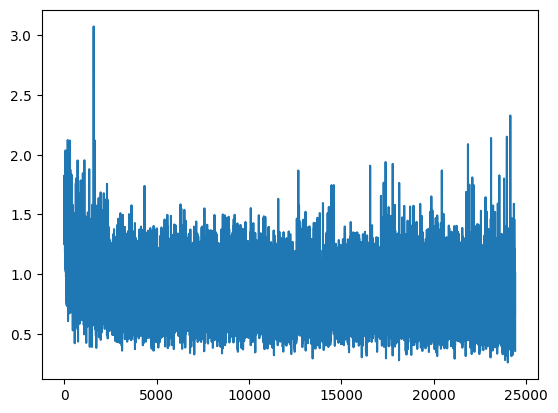

In [38]:
plt.plot(train_losses)

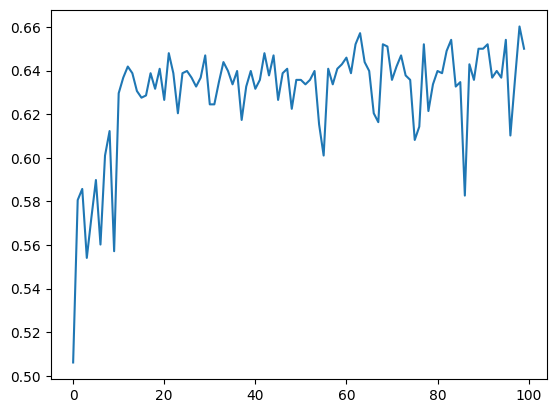

In [39]:
plt.plot(test_accuracy)

In [40]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_window_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [41]:
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [52]:
# del model
# del best_model
# gc.collect()

19668

In [ ]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_window_{epoch}epoch.ckpt'

In [23]:
model_path_prefix = '../models_cremad4/cremad_label4_m14sinc_window_best_'
best_epoch = 99
bmodel_path = f'{model_path_prefix}{best_epoch}epoch.pt'
model.load_state_dict(torch.load(bmodel_path))

<All keys matched successfully>

In [26]:
model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 647/976 (0.6629)
{'acc_detail': tensor([0.6220, 0.6991, 0.7244, 0.6111], device='cuda:0'),
 'acc_unweighted': tensor(0.6642, device='cuda:0'),
 'acc_weighted': tensor(0.6629, device='cuda:0'),
 'f1s_detail': tensor([0.7149, 0.6113, 0.7345, 0.5981], device='cuda:0'),
 'f1s_unweighted': tensor(0.6647, device='cuda:0'),
 'f1s_weighted': tensor(0.6669, device='cuda:0'),
 'precision_detail': tensor([0.8404, 0.5432, 0.7449, 0.5856], device='cuda:0'),
 'recall_detail': tensor([0.6220, 0.6991, 0.7244, 0.6111], device='cuda:0'),
 'rocauc': tensor(0.8739, device='cuda:0'),
 'rocauc_detail': tensor([0.9223, 0.8441, 0.9141, 0.8150], device='cuda:0'),
 'uar': tensor(0.6642, device='cuda:0'),
 'wap': tensor(0.6840, device='cuda:0')}


tensor([[158,  13,   5,  78],
        [  1, 151,  44,  20],
        [  3,  56, 184,  11],
        [ 26,  58,  14, 154]], device='cuda:0')

Time domain: Filters' shapes vary by frequency bins


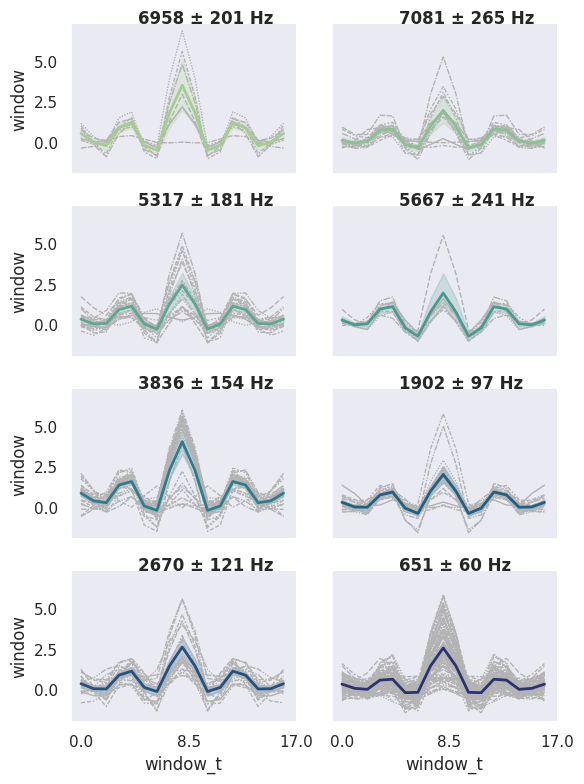

In [28]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


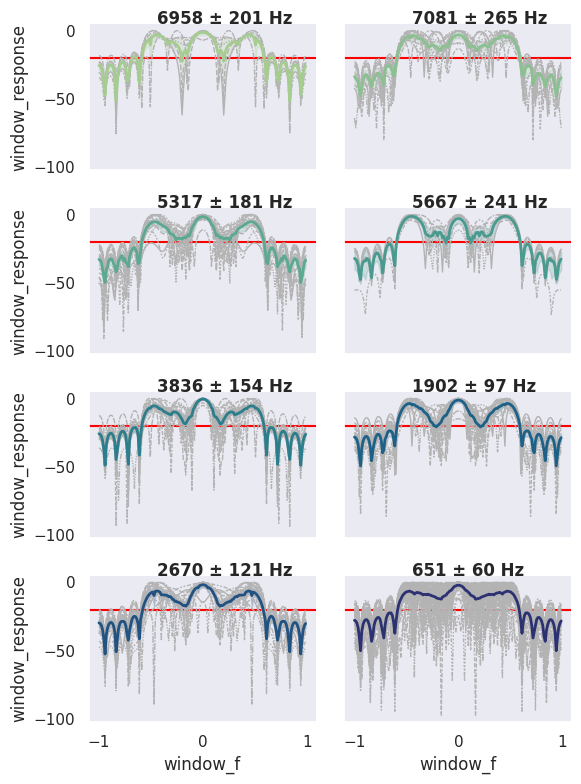

In [29]:
filtviz.visualize_filters(filter_domain='freq')

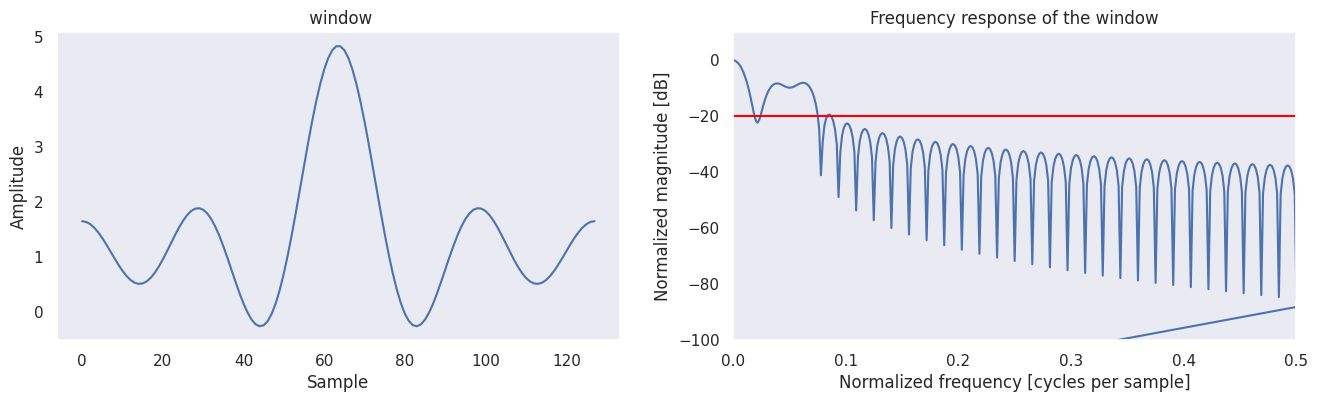

In [34]:
filtviz.visualize_one_window(n_out=3)

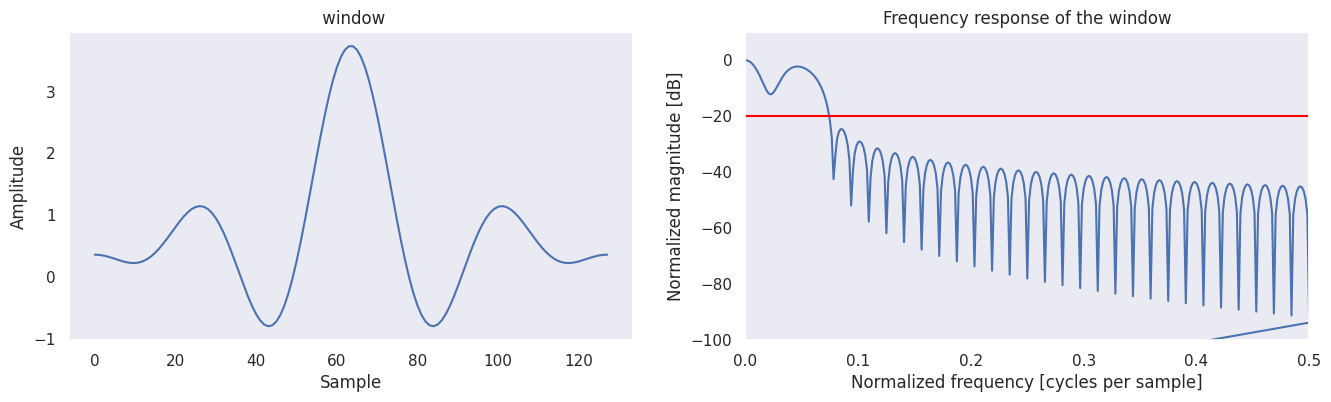

In [30]:
filtviz.visualize_one_window(n_out=10)

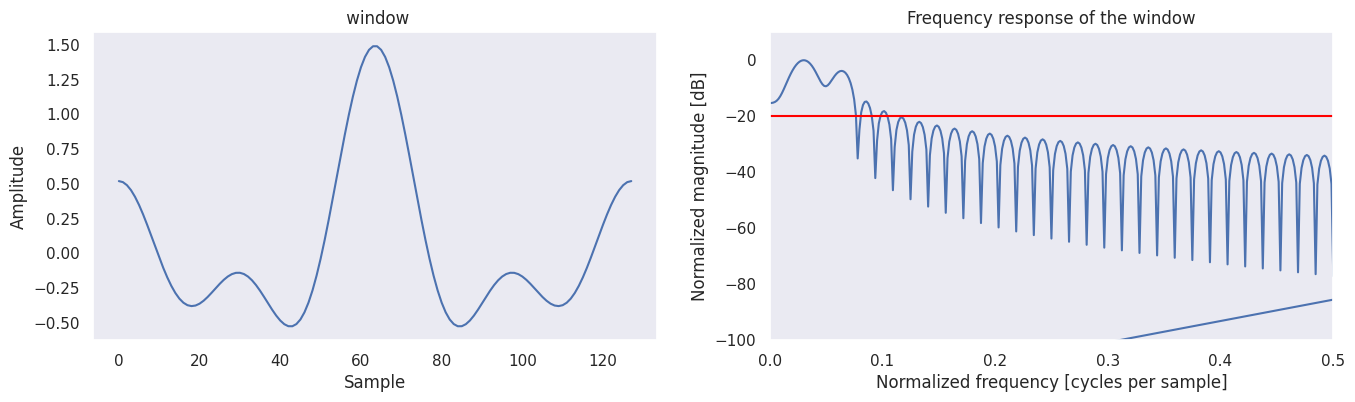

In [35]:
filtviz.visualize_one_window(n_out=20)

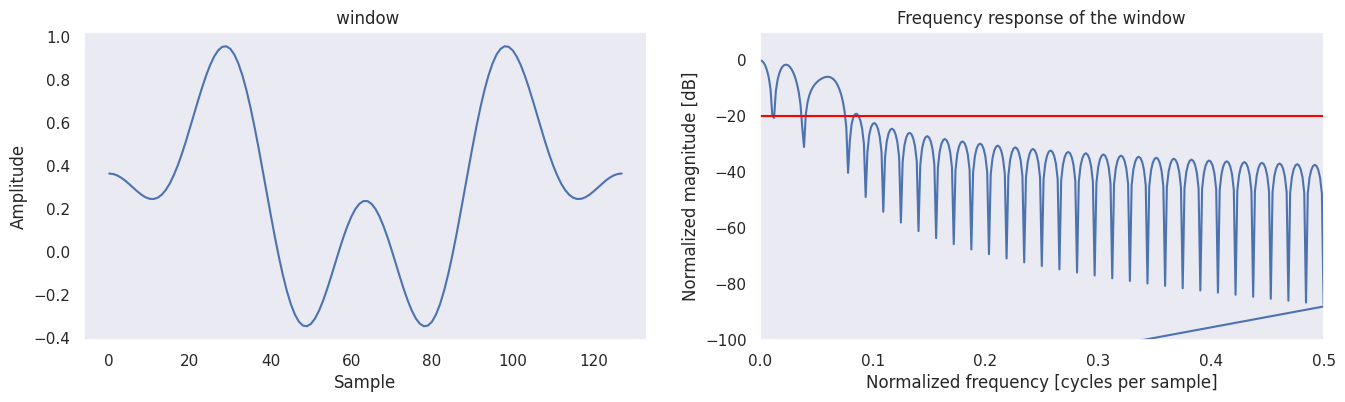

In [31]:
filtviz.visualize_one_window(n_out=30)

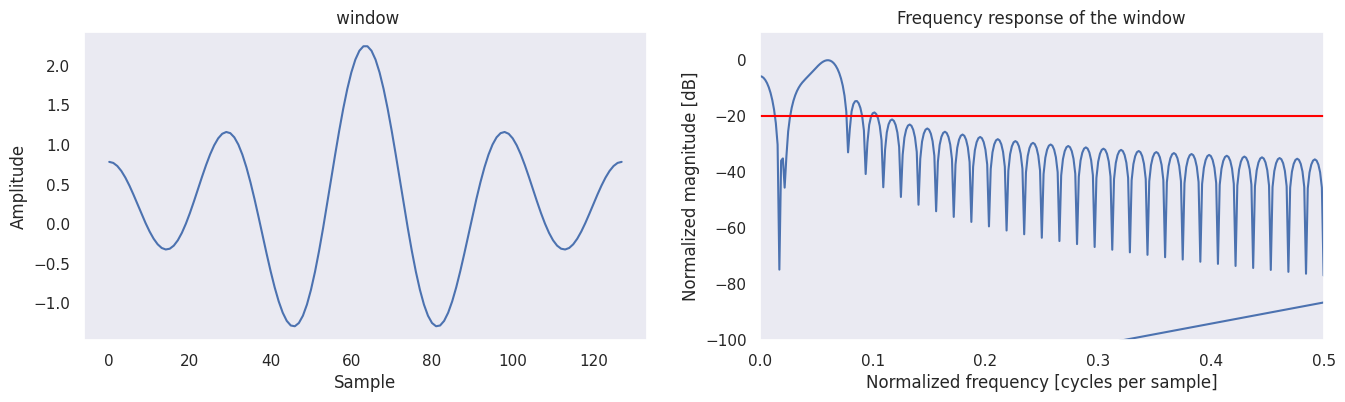

In [32]:
filtviz.visualize_one_window(n_out=50)

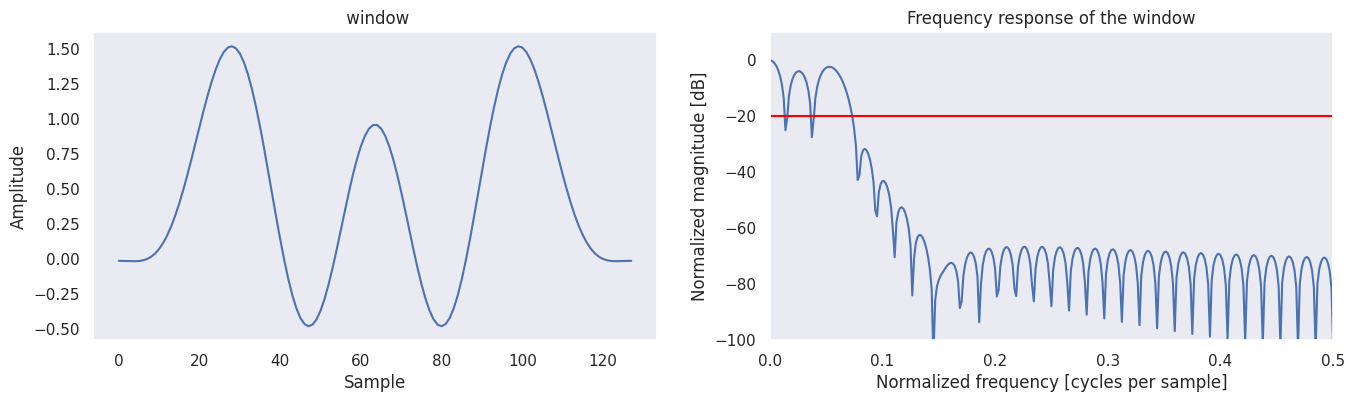

In [33]:
filtviz.visualize_one_window(n_out=60)

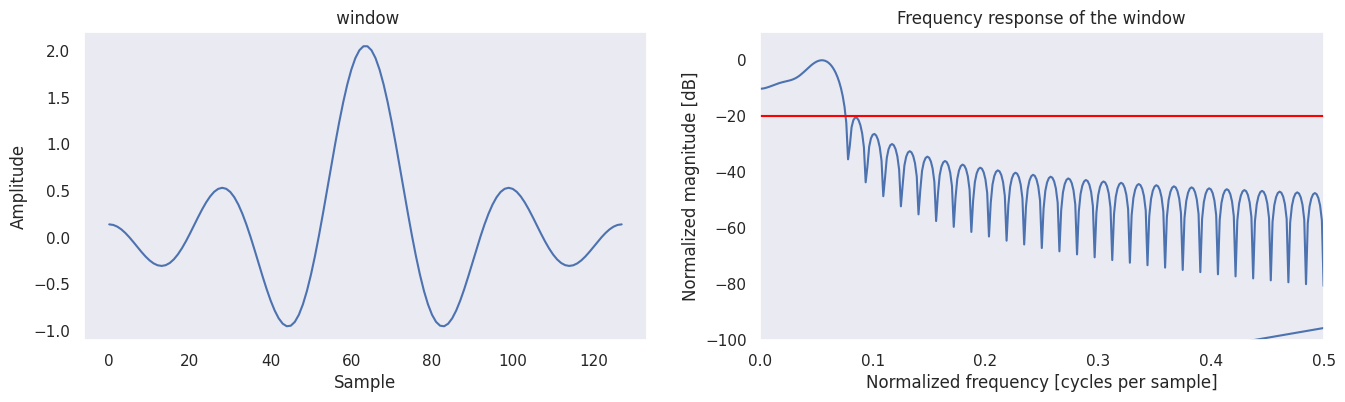

In [36]:
filtviz.visualize_one_window(n_out=63)

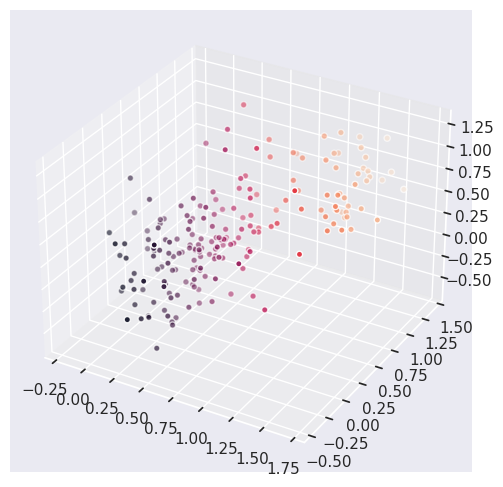

In [37]:
filtviz.visualize_window_params()

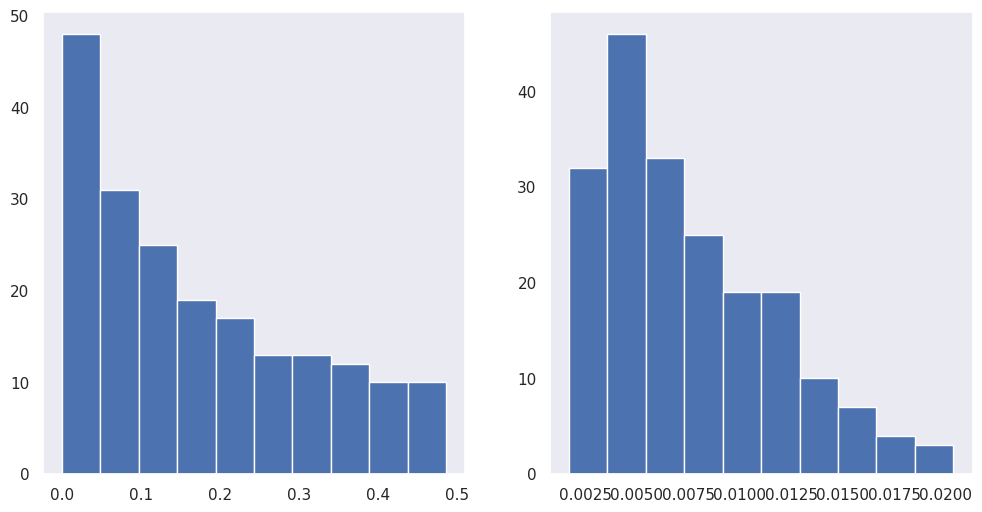

In [38]:
filtviz.visualize_bands()

In [40]:
start_epoch = 100
n_epoch = 51
best_accuracy = 647/976
best_epoch = 99
model_path_prefix = '../models_cremad4/cremad_label4_m14sinc_window_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch + n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                      | 0.003278688524590164/51 [00:00<2:29:22, 175.76s/it]

Train Epoch: 100 [0/3918 (0%)]	Loss: 0.927426
Mem before-during-after: 17375744 3951582208 31166464


  0%|▏                                                      | 0.13442622950819672/51 [00:16<1:48:48, 128.34s/it]

Train Epoch: 100 [640/3918 (16%)]	Loss: 0.603257
Mem before-during-after: 32110592 3907543552 31166464


  1%|▎                                                      | 0.26557377049180286/51 [00:32<2:00:35, 142.61s/it]

Train Epoch: 100 [1280/3918 (33%)]	Loss: 0.738211
Mem before-during-after: 31323136 3965789184 31589888


  1%|▍                                                         | 0.39672131147541/51 [00:47<1:35:28, 113.20s/it]

Train Epoch: 100 [1920/3918 (49%)]	Loss: 0.882345
Mem before-during-after: 31228928 3965028352 32048128


  1%|▌                                                       | 0.5278688524590167/51 [01:04<1:56:06, 138.02s/it]

Train Epoch: 100 [2560/3918 (66%)]	Loss: 0.698197
Mem before-during-after: 31228928 3965093888 32056832


  1%|▋                                                       | 0.6590163934426216/51 [01:21<1:35:54, 114.30s/it]

Train Epoch: 100 [3200/3918 (82%)]	Loss: 0.972527
Mem before-during-after: 32110592 3966568960 32048128


  2%|▊                                                       | 0.7901639344262266/51 [01:36<1:34:53, 113.38s/it]

Train Epoch: 100 [3840/3918 (98%)]	Loss: 0.900528
Mem before-during-after: 32048128 3967099904 31228928


  2%|█▏                                                         | 0.9999999999999944/51 [01:50<55:42, 66.84s/it]


Test Epoch: 100	Accuracy: 633/976 (65%)



  2%|█                                                        | 1.0032786885245846/51 [01:50<1:05:50, 79.01s/it]

Train Epoch: 101 [0/3918 (0%)]	Loss: 0.800739
Mem before-during-after: 31159296 3681221632 31166464


  2%|█▏                                                      | 1.1344262295081895/51 [02:06<1:41:39, 122.33s/it]

Train Epoch: 101 [640/3918 (16%)]	Loss: 0.994267
Mem before-during-after: 32194048 3967159296 32048128


  2%|█▍                                                      | 1.2655737704917944/51 [02:21<1:39:49, 120.43s/it]

Train Epoch: 101 [1280/3918 (33%)]	Loss: 0.461178
Mem before-during-after: 31491072 3964513792 32110592


  3%|█▌                                                      | 1.3967213114753994/51 [02:36<1:32:57, 112.45s/it]

Train Epoch: 101 [1920/3918 (49%)]	Loss: 0.769436
Mem before-during-after: 31228928 3967125504 32048128


  3%|█▋                                                      | 1.5278688524590043/51 [02:52<1:34:24, 114.50s/it]

Train Epoch: 101 [2560/3918 (66%)]	Loss: 0.783758
Mem before-during-after: 32110592 3965811712 31553536


  3%|█▊                                                      | 1.6590163934426092/51 [03:07<1:35:07, 115.68s/it]

Train Epoch: 101 [3200/3918 (82%)]	Loss: 0.954826
Mem before-during-after: 31228928 3967242752 32048128


  4%|█▉                                                      | 1.7901639344262141/51 [03:22<1:34:09, 114.80s/it]

Train Epoch: 101 [3840/3918 (98%)]	Loss: 0.941261
Mem before-during-after: 31166464 3967191552 32110592


  4%|██▎                                                         | 1.999999999999982/51 [03:36<52:52, 64.75s/it]


Test Epoch: 101	Accuracy: 621/976 (63%)



  4%|██▏                                                      | 2.0032786885245724/51 [03:36<1:07:35, 82.78s/it]

Train Epoch: 102 [0/3918 (0%)]	Loss: 0.886431
Mem before-during-after: 31159296 3965511680 31312384


  4%|██▎                                                     | 2.1344262295081773/51 [03:53<1:39:34, 122.26s/it]

Train Epoch: 102 [640/3918 (16%)]	Loss: 0.569851
Mem before-during-after: 31291392 3967430144 31491072


  4%|██▌                                                      | 2.265573770491782/51 [04:09<1:34:34, 116.44s/it]

Train Epoch: 102 [1280/3918 (33%)]	Loss: 0.485130
Mem before-during-after: 32372736 3968303104 32110592


  5%|██▋                                                      | 2.396721311475387/51 [04:24<1:32:01, 113.60s/it]

Train Epoch: 102 [1920/3918 (49%)]	Loss: 0.516387
Mem before-during-after: 32048128 3967099904 31228928


  5%|██▊                                                      | 2.527868852458992/51 [04:39<1:41:50, 126.05s/it]

Train Epoch: 102 [2560/3918 (66%)]	Loss: 0.638001
Mem before-during-after: 32110592 3967483904 32110592


  5%|██▉                                                      | 2.659016393442597/51 [04:54<1:29:26, 111.00s/it]

Train Epoch: 102 [3200/3918 (82%)]	Loss: 0.971152
Mem before-during-after: 31166464 3909607424 31448064


  5%|███                                                      | 2.790163934426202/51 [05:11<1:43:43, 129.09s/it]

Train Epoch: 102 [3840/3918 (98%)]	Loss: 0.877356
Mem before-during-after: 32110592 3965811712 31553536


  6%|███▌                                                         | 2.99999999999997/51 [05:25<52:43, 65.90s/it]


Test Epoch: 102	Accuracy: 624/976 (64%)



  6%|███▍                                                       | 3.00327868852456/51 [05:26<1:01:56, 77.43s/it]

Train Epoch: 103 [0/3918 (0%)]	Loss: 1.029240
Mem before-during-after: 31159296 3883179008 31166464


  6%|███▌                                                     | 3.134426229508165/51 [05:41<1:35:59, 120.32s/it]

Train Epoch: 103 [640/3918 (16%)]	Loss: 0.649010
Mem before-during-after: 31436800 3964388864 31353856


  6%|███▋                                                      | 3.26557377049177/51 [05:56<1:31:08, 114.57s/it]

Train Epoch: 103 [1280/3918 (33%)]	Loss: 0.568887
Mem before-during-after: 32048128 3968072704 31320064


  7%|███▋                                                    | 3.3967213114753747/51 [06:11<1:32:39, 116.79s/it]

Train Epoch: 103 [1920/3918 (49%)]	Loss: 0.749602
Mem before-during-after: 32048128 3965818880 32048128


  7%|███▊                                                    | 3.5278688524589796/51 [06:27<1:34:18, 119.19s/it]

Train Epoch: 103 [2560/3918 (66%)]	Loss: 0.557922
Mem before-during-after: 31257600 3966368768 31166464


  7%|████                                                    | 3.6590163934425846/51 [06:44<1:51:48, 141.70s/it]

Train Epoch: 103 [3200/3918 (82%)]	Loss: 0.928962
Mem before-during-after: 31220736 3964092928 31166464


  7%|████▏                                                   | 3.7901639344261895/51 [07:00<1:35:31, 121.40s/it]

Train Epoch: 103 [3840/3918 (98%)]	Loss: 0.741113
Mem before-during-after: 32194048 3967250432 32048128


  8%|████▋                                                      | 3.9999999999999574/51 [07:15<51:14, 65.42s/it]


Test Epoch: 103	Accuracy: 619/976 (63%)



  8%|████▍                                                    | 4.0032786885245475/51 [07:15<1:01:53, 79.03s/it]

Train Epoch: 104 [0/3918 (0%)]	Loss: 0.775850
Mem before-during-after: 31159296 3965511680 31312384


  8%|████▌                                                    | 4.134426229508152/51 [07:30<1:40:21, 128.48s/it]

Train Epoch: 104 [640/3918 (16%)]	Loss: 0.585455
Mem before-during-after: 31599616 3966286336 31228928


  8%|████▊                                                    | 4.265573770491757/51 [07:46<1:30:42, 116.45s/it]

Train Epoch: 104 [1280/3918 (33%)]	Loss: 0.633927
Mem before-during-after: 31228928 3965093888 32056832


  9%|████▉                                                    | 4.396721311475362/51 [08:01<1:29:30, 115.25s/it]

Train Epoch: 104 [1920/3918 (49%)]	Loss: 0.773486
Mem before-during-after: 32102400 3967196672 31328768


  9%|█████                                                    | 4.527868852458967/51 [08:16<1:30:29, 116.83s/it]

Train Epoch: 104 [2560/3918 (66%)]	Loss: 0.691262
Mem before-during-after: 32110592 3966539776 31491072


  9%|█████▏                                                   | 4.659016393442572/51 [08:32<1:28:43, 114.89s/it]

Train Epoch: 104 [3200/3918 (82%)]	Loss: 0.976095
Mem before-during-after: 31320064 3939258368 31196160


  9%|█████▎                                                   | 4.790163934426177/51 [08:50<1:45:14, 136.66s/it]

Train Epoch: 104 [3840/3918 (98%)]	Loss: 0.644295
Mem before-during-after: 32048128 3965002752 31228928


 10%|█████▉                                                      | 4.999999999999945/51 [09:04<52:01, 67.86s/it]


Test Epoch: 104	Accuracy: 647/976 (66%)



 10%|█████▋                                                    | 5.003278688524535/51 [09:05<1:00:29, 78.91s/it]

Train Epoch: 105 [0/3918 (0%)]	Loss: 0.853528
Mem before-during-after: 31159296 3800102912 31166464


 10%|█████▊                                                    | 5.13442622950814/51 [09:20<1:29:34, 117.18s/it]

Train Epoch: 105 [640/3918 (16%)]	Loss: 0.717701
Mem before-during-after: 31166976 3964180480 31166464


 10%|█████▉                                                   | 5.265573770491745/51 [09:36<1:30:13, 118.37s/it]

Train Epoch: 105 [1280/3918 (33%)]	Loss: 0.884220
Mem before-during-after: 32194048 3965062144 32048128


 11%|██████▏                                                   | 5.39672131147535/51 [09:51<1:31:36, 120.52s/it]

Train Epoch: 105 [1920/3918 (49%)]	Loss: 0.677379
Mem before-during-after: 31166464 3968072704 32110592


 11%|██████▏                                                  | 5.527868852458955/51 [10:07<1:43:39, 136.77s/it]

Train Epoch: 105 [2560/3918 (66%)]	Loss: 0.590431
Mem before-during-after: 31228928 3965093888 32056832


 11%|██████▍                                                   | 5.65901639344256/51 [10:24<1:29:10, 118.00s/it]

Train Epoch: 105 [3200/3918 (82%)]	Loss: 0.751127
Mem before-during-after: 32110592 3966602240 32110592


 11%|██████▍                                                  | 5.790163934426165/51 [10:39<1:27:19, 115.89s/it]

Train Epoch: 105 [3840/3918 (98%)]	Loss: 0.758775
Mem before-during-after: 31228928 3967242752 32048128


 12%|██████▉                                                    | 5.9999999999999325/51 [10:53<48:43, 64.97s/it]


Test Epoch: 105	Accuracy: 631/976 (64%)



 12%|███████                                                     | 6.003278688524523/51 [10:54<59:35, 79.46s/it]

Train Epoch: 106 [0/3918 (0%)]	Loss: 0.675972
Mem before-during-after: 31159296 3965511680 31312384


 12%|██████▋                                                 | 6.1344262295081275/51 [11:09<1:27:04, 116.45s/it]

Train Epoch: 106 [640/3918 (16%)]	Loss: 0.725865
Mem before-during-after: 31312384 3968061952 31312384


 12%|██████▉                                                 | 6.2655737704917325/51 [11:24<1:31:48, 123.14s/it]

Train Epoch: 106 [1280/3918 (33%)]	Loss: 0.644122
Mem before-during-after: 32110592 3966864384 32372736


 13%|███████▏                                                 | 6.396721311475337/51 [11:40<1:34:05, 126.57s/it]

Train Epoch: 106 [1920/3918 (49%)]	Loss: 0.974660
Mem before-during-after: 32110592 3964505088 32110592


 13%|███████▎                                                 | 6.527868852458942/51 [11:55<1:26:52, 117.20s/it]

Train Epoch: 106 [2560/3918 (66%)]	Loss: 0.774664
Mem before-during-after: 31320064 3966243840 31166464


 13%|███████▍                                                 | 6.659016393442547/51 [12:11<1:25:11, 115.28s/it]

Train Epoch: 106 [3200/3918 (82%)]	Loss: 0.622003
Mem before-during-after: 32102400 3965812224 31528448


 13%|███████▌                                                 | 6.790163934426152/51 [12:26<1:24:45, 115.03s/it]

Train Epoch: 106 [3840/3918 (98%)]	Loss: 0.678725
Mem before-during-after: 31291392 3968797696 32048128


 14%|████████▎                                                    | 6.99999999999992/51 [12:41<48:33, 66.21s/it]


Test Epoch: 106	Accuracy: 634/976 (65%)



 14%|████████▍                                                    | 7.00327868852451/51 [12:41<57:39, 78.62s/it]

Train Epoch: 107 [0/3918 (0%)]	Loss: 0.888991
Mem before-during-after: 31159296 3965511680 31312384


 14%|███████▉                                                 | 7.134426229508115/51 [12:57<1:26:01, 117.66s/it]

Train Epoch: 107 [640/3918 (16%)]	Loss: 0.562461
Mem before-during-after: 31491072 3965881344 32110592


 14%|████████▎                                                 | 7.26557377049172/51 [13:12<1:22:32, 113.24s/it]

Train Epoch: 107 [1280/3918 (33%)]	Loss: 0.748537
Mem before-during-after: 31228928 3967125504 32048128


 15%|████████▎                                                | 7.396721311475325/51 [13:28<1:28:46, 122.16s/it]

Train Epoch: 107 [1920/3918 (49%)]	Loss: 0.831022
Mem before-during-after: 32048128 3967099904 31228928


 15%|████████▌                                                 | 7.52786885245893/51 [13:45<1:33:54, 129.62s/it]

Train Epoch: 107 [2560/3918 (66%)]	Loss: 0.676462
Mem before-during-after: 31815680 3963976704 31553536


 15%|████████▌                                                | 7.659016393442535/51 [14:00<1:24:37, 117.15s/it]

Train Epoch: 107 [3200/3918 (82%)]	Loss: 0.952983
Mem before-during-after: 31220736 3839170560 31221248


 15%|████████▊                                                 | 7.79016393442614/51 [14:16<1:38:52, 137.29s/it]

Train Epoch: 107 [3840/3918 (98%)]	Loss: 0.420530
Mem before-during-after: 31491072 3964513792 32110592


 16%|█████████▍                                                  | 7.999999999999908/51 [14:31<47:30, 66.28s/it]


Test Epoch: 107	Accuracy: 630/976 (64%)



 16%|█████████▍                                                  | 8.003278688524498/51 [14:31<56:46, 79.23s/it]

Train Epoch: 108 [0/3918 (0%)]	Loss: 0.663064
Mem before-during-after: 31159296 3965511680 31312384


 16%|█████████                                                | 8.134426229508103/51 [14:48<1:39:02, 138.64s/it]

Train Epoch: 108 [640/3918 (16%)]	Loss: 0.559592
Mem before-during-after: 31323136 3966539776 31228928


 16%|█████████▏                                               | 8.265573770491708/51 [15:03<1:41:31, 142.53s/it]

Train Epoch: 108 [1280/3918 (33%)]	Loss: 0.864722
Mem before-during-after: 32110592 3964767232 32372736


 16%|█████████▍                                               | 8.396721311475313/51 [15:22<1:33:49, 132.14s/it]

Train Epoch: 108 [1920/3918 (49%)]	Loss: 0.853646
Mem before-during-after: 32110592 3965811712 31553536


 17%|█████████▌                                               | 8.527868852458917/51 [15:37<1:20:54, 114.30s/it]

Train Epoch: 108 [2560/3918 (66%)]	Loss: 0.712565
Mem before-during-after: 32110592 3967242752 32048128


 17%|█████████▋                                               | 8.659016393442522/51 [15:52<1:27:18, 123.73s/it]

Train Epoch: 108 [3200/3918 (82%)]	Loss: 0.474916
Mem before-during-after: 31228928 3967817728 31228928


 17%|█████████▊                                               | 8.790163934426127/51 [16:09<1:36:19, 136.91s/it]

Train Epoch: 108 [3840/3918 (98%)]	Loss: 0.594191
Mem before-during-after: 31228928 3967126016 32048128


 18%|██████████▌                                                 | 8.999999999999895/51 [16:23<45:05, 64.41s/it]


Test Epoch: 108	Accuracy: 622/976 (63%)



 18%|██████████▏                                               | 9.003278688524485/51 [16:23<1:00:03, 85.79s/it]

Train Epoch: 109 [0/3918 (0%)]	Loss: 0.596768
Mem before-during-after: 31159296 3965511680 31312384


 18%|██████████▍                                               | 9.13442622950809/51 [16:39<1:20:50, 115.86s/it]

Train Epoch: 109 [640/3918 (16%)]	Loss: 0.799677
Mem before-during-after: 32110592 3965811712 31553536


 18%|██████████▎                                              | 9.265573770491695/51 [16:55<1:23:59, 120.76s/it]

Train Epoch: 109 [1280/3918 (33%)]	Loss: 0.517656
Mem before-during-after: 32194048 3967159296 32048128


 18%|██████████▊                                                | 9.3967213114753/51 [17:11<1:31:29, 131.96s/it]

Train Epoch: 109 [1920/3918 (49%)]	Loss: 0.942863
Mem before-during-after: 31320064 3964334080 31353856


 19%|██████████▋                                              | 9.527868852458905/51 [17:26<1:29:12, 129.07s/it]

Train Epoch: 109 [2560/3918 (66%)]	Loss: 0.889852
Mem before-during-after: 31257600 3966081024 31166464


 19%|██████████▉                                               | 9.65901639344251/51 [17:42<1:20:20, 116.60s/it]

Train Epoch: 109 [3200/3918 (82%)]	Loss: 0.960277
Mem before-during-after: 32048128 3967099904 31228928


 19%|██████████▉                                              | 9.790163934426115/51 [17:58<1:19:17, 115.45s/it]

Train Epoch: 109 [3840/3918 (98%)]	Loss: 0.595252
Mem before-during-after: 32110592 3965811712 31553536


 20%|███████████▊                                                | 9.999999999999883/51 [18:12<44:38, 65.34s/it]


Test Epoch: 109	Accuracy: 643/976 (66%)



 20%|███████████▌                                               | 10.003278688524473/51 [18:13<56:52, 83.24s/it]

Train Epoch: 110 [0/3918 (0%)]	Loss: 0.478337
Mem before-during-after: 31159296 3965511680 31312384


 20%|███████████▏                                            | 10.134426229508078/51 [18:28<1:20:10, 117.71s/it]

Train Epoch: 110 [640/3918 (16%)]	Loss: 0.808444
Mem before-during-after: 32048128 3967099904 31228928


 20%|███████████▎                                            | 10.265573770491683/51 [18:44<1:33:44, 138.07s/it]

Train Epoch: 110 [1280/3918 (33%)]	Loss: 0.503124
Mem before-during-after: 31320064 3965028352 32048128


 20%|███████████▍                                            | 10.396721311475288/51 [19:02<1:19:00, 116.75s/it]

Train Epoch: 110 [1920/3918 (49%)]	Loss: 0.918561
Mem before-during-after: 31175168 3967099904 31228928


 21%|███████████▌                                            | 10.527868852458893/51 [19:18<1:24:28, 125.22s/it]

Train Epoch: 110 [2560/3918 (66%)]	Loss: 0.837667
Mem before-during-after: 31491072 3839503872 31776768


 21%|███████████▋                                            | 10.659016393442498/51 [19:34<1:16:13, 113.37s/it]

Train Epoch: 110 [3200/3918 (82%)]	Loss: 0.928750
Mem before-during-after: 31320064 3909961216 31367680


 21%|███████████▊                                            | 10.793442622950693/51 [19:51<1:17:30, 115.66s/it]

Train Epoch: 110 [3840/3918 (98%)]	Loss: 0.740971
Mem before-during-after: 32048128 3965002752 31228928


 22%|████████████▉                                               | 10.99999999999987/51 [20:05<42:55, 64.39s/it]


Test Epoch: 110	Accuracy: 623/976 (64%)



 22%|████████████▉                                               | 11.00327868852446/51 [20:05<53:15, 79.89s/it]

Train Epoch: 111 [0/3918 (0%)]	Loss: 0.466840
Mem before-during-after: 31159296 3965511680 31312384


 22%|████████████▏                                           | 11.137704918032655/51 [20:21<1:16:48, 115.62s/it]

Train Epoch: 111 [640/3918 (16%)]	Loss: 0.547654
Mem before-during-after: 32110592 3964442624 31491072


 22%|████████████▌                                            | 11.26557377049167/51 [20:38<1:27:18, 131.83s/it]

Train Epoch: 111 [1280/3918 (33%)]	Loss: 1.026569
Mem before-during-after: 31228928 3907994624 31166464


 22%|████████████▌                                           | 11.396721311475275/51 [20:53<1:17:12, 116.97s/it]

Train Epoch: 111 [1920/3918 (49%)]	Loss: 0.445422
Mem before-during-after: 31228928 3967450112 32048128


 23%|████████████▉                                            | 11.52786885245888/51 [21:10<1:27:41, 133.29s/it]

Train Epoch: 111 [2560/3918 (66%)]	Loss: 0.811858
Mem before-during-after: 31291392 3969473024 31436800


 23%|████████████▊                                           | 11.659016393442485/51 [21:26<1:25:11, 129.92s/it]

Train Epoch: 111 [3200/3918 (82%)]	Loss: 0.860527
Mem before-during-after: 32194048 3966693888 31616000


 23%|█████████████▏                                           | 11.79016393442609/51 [21:42<1:18:08, 119.59s/it]

Train Epoch: 111 [3840/3918 (98%)]	Loss: 0.758782
Mem before-during-after: 31166464 3966630912 31553536


 24%|█████████████▉                                             | 11.999999999999858/51 [21:56<42:12, 64.93s/it]


Test Epoch: 111	Accuracy: 637/976 (65%)



 24%|█████████████▉                                             | 12.003278688524448/51 [21:57<52:39, 81.01s/it]

Train Epoch: 112 [0/3918 (0%)]	Loss: 0.544201
Mem before-during-after: 31159296 3965511680 31312384


 24%|█████████████▎                                          | 12.134426229508053/51 [22:12<1:25:01, 131.25s/it]

Train Epoch: 112 [640/3918 (16%)]	Loss: 0.621943
Mem before-during-after: 31388672 3967230464 32048128


 24%|█████████████▍                                          | 12.265573770491658/51 [22:28<1:14:15, 115.02s/it]

Train Epoch: 112 [1280/3918 (33%)]	Loss: 0.656250
Mem before-during-after: 31166464 3967191040 32110592


 24%|█████████████▌                                          | 12.396721311475263/51 [22:45<1:17:34, 120.57s/it]

Train Epoch: 112 [1920/3918 (49%)]	Loss: 0.531531
Mem before-during-after: 32181248 3799543296 31166464


 25%|█████████████▊                                          | 12.527868852458868/51 [23:01<1:14:49, 116.69s/it]

Train Epoch: 112 [2560/3918 (66%)]	Loss: 0.419800
Mem before-during-after: 31257600 3966368768 31166464


 25%|█████████████▉                                          | 12.659016393442473/51 [23:17<1:14:42, 116.91s/it]

Train Epoch: 112 [3200/3918 (82%)]	Loss: 0.621342
Mem before-during-after: 31312384 3968053248 31303680


 25%|██████████████                                          | 12.790163934426078/51 [23:32<1:11:46, 112.70s/it]

Train Epoch: 112 [3840/3918 (98%)]	Loss: 0.569412
Mem before-during-after: 32048128 3967099904 31228928


 25%|███████████████                                            | 12.999999999999845/51 [23:48<44:15, 69.89s/it]


Test Epoch: 112	Accuracy: 634/976 (65%)



 25%|███████████████                                            | 13.003278688524436/51 [23:48<53:19, 84.21s/it]

Train Epoch: 113 [0/3918 (0%)]	Loss: 0.565132
Mem before-during-after: 31159296 3965511680 31312384


 26%|██████████████▋                                          | 13.13442622950804/51 [24:03<1:20:28, 127.51s/it]

Train Epoch: 113 [640/3918 (16%)]	Loss: 0.558010
Mem before-during-after: 32048128 3967515648 31636992


 26%|██████████████▌                                         | 13.265573770491645/51 [24:21<1:32:39, 147.33s/it]

Train Epoch: 113 [1280/3918 (33%)]	Loss: 0.514618
Mem before-during-after: 31491072 3965415936 32110592


 26%|██████████████▉                                          | 13.39672131147525/51 [24:37<1:14:30, 118.87s/it]

Train Epoch: 113 [1920/3918 (49%)]	Loss: 0.517603
Mem before-during-after: 31166464 3967191040 32110592


 27%|██████████████▊                                         | 13.527868852458855/51 [24:53<1:19:19, 127.02s/it]

Train Epoch: 113 [2560/3918 (66%)]	Loss: 0.859317
Mem before-during-after: 31166464 3967424512 32110592


 27%|███████████████▎                                         | 13.65901639344246/51 [25:09<1:11:43, 115.26s/it]

Train Epoch: 113 [3200/3918 (82%)]	Loss: 0.701013
Mem before-during-after: 32048128 3967099904 31228928


 27%|███████████████▏                                        | 13.790163934426065/51 [25:24<1:10:24, 113.52s/it]

Train Epoch: 113 [3840/3918 (98%)]	Loss: 0.747087
Mem before-during-after: 32048128 3967099904 31228928


 27%|████████████████▏                                          | 13.999999999999833/51 [25:39<38:48, 62.93s/it]


Test Epoch: 113	Accuracy: 631/976 (64%)



 27%|████████████████▏                                          | 14.003278688524423/51 [25:39<48:58, 79.42s/it]

Train Epoch: 114 [0/3918 (0%)]	Loss: 0.598829
Mem before-during-after: 31159296 3965511680 31312384


 28%|███████████████▌                                        | 14.134426229508028/51 [25:55<1:10:43, 115.11s/it]

Train Epoch: 114 [640/3918 (16%)]	Loss: 0.631535
Mem before-during-after: 32048128 3967916032 32048128


 28%|███████████████▋                                        | 14.265573770491633/51 [26:12<1:15:02, 122.56s/it]

Train Epoch: 114 [1280/3918 (33%)]	Loss: 0.950706
Mem before-during-after: 31491072 3966073856 31553536


 28%|███████████████▊                                        | 14.396721311475238/51 [26:28<1:09:16, 113.56s/it]

Train Epoch: 114 [1920/3918 (49%)]	Loss: 0.637109
Mem before-during-after: 32048128 3967513088 32110592


 28%|███████████████▉                                        | 14.527868852458843/51 [26:43<1:10:34, 116.11s/it]

Train Epoch: 114 [2560/3918 (66%)]	Loss: 0.832305
Mem before-during-after: 31228928 3967125504 32048128


 29%|████████████████                                        | 14.659016393442448/51 [26:59<1:24:13, 139.06s/it]

Train Epoch: 114 [3200/3918 (82%)]	Loss: 0.745965
Mem before-during-after: 31553536 3965145600 32194048


 29%|████████████████▏                                       | 14.790163934426053/51 [27:16<1:11:10, 117.94s/it]

Train Epoch: 114 [3840/3918 (98%)]	Loss: 0.632431
Mem before-during-after: 31228928 3967242752 32194048


 29%|█████████████████▋                                          | 14.99999999999982/51 [27:30<38:31, 64.21s/it]


Test Epoch: 114	Accuracy: 629/976 (64%)



 29%|█████████████████▋                                          | 15.00327868852441/51 [27:31<45:49, 76.39s/it]

Train Epoch: 115 [0/3918 (0%)]	Loss: 0.824819
Mem before-during-after: 31159296 3843521536 31166464


 30%|████████████████▌                                       | 15.134426229508016/51 [27:47<1:08:19, 114.31s/it]

Train Epoch: 115 [640/3918 (16%)]	Loss: 0.610569
Mem before-during-after: 32048128 3966602240 32048128


 30%|█████████████████                                        | 15.26557377049162/51 [28:03<1:21:23, 136.66s/it]

Train Epoch: 115 [1280/3918 (33%)]	Loss: 0.358836
Mem before-during-after: 31166464 3967187968 31320064


 30%|████████████████▉                                       | 15.396721311475225/51 [28:19<1:17:59, 131.45s/it]

Train Epoch: 115 [1920/3918 (49%)]	Loss: 0.653328
Mem before-during-after: 31491072 3966073856 31553536


 30%|█████████████████▎                                       | 15.52786885245883/51 [28:34<1:20:25, 136.03s/it]

Train Epoch: 115 [2560/3918 (66%)]	Loss: 0.937914
Mem before-during-after: 32110592 3963715072 31553536


 31%|█████████████████▏                                      | 15.659016393442435/51 [28:50<1:21:11, 137.85s/it]

Train Epoch: 115 [3200/3918 (82%)]	Loss: 0.683933
Mem before-during-after: 32110592 3965720576 31228928


 31%|█████████████████▋                                       | 15.79016393442604/51 [29:06<1:08:35, 116.89s/it]

Train Epoch: 115 [3840/3918 (98%)]	Loss: 0.605783
Mem before-during-after: 32048128 3967099904 31228928


 31%|██████████████████▌                                        | 15.999999999999808/51 [29:21<37:25, 64.15s/it]


Test Epoch: 115	Accuracy: 617/976 (63%)



 31%|███████████████████▏                                         | 16.0032786885244/51 [29:21<46:30, 79.73s/it]

Train Epoch: 116 [0/3918 (0%)]	Loss: 0.962753
Mem before-during-after: 31159296 3965511680 31312384


 32%|█████████████████▋                                      | 16.134426229508076/51 [29:36<1:07:25, 116.04s/it]

Train Epoch: 116 [640/3918 (16%)]	Loss: 0.774966
Mem before-during-after: 32048128 3967099904 31228928


 32%|█████████████████▊                                      | 16.265573770491752/51 [29:53<1:21:35, 140.93s/it]

Train Epoch: 116 [1280/3918 (33%)]	Loss: 0.551507
Mem before-during-after: 31312896 3965873152 32102400


 32%|██████████████████                                      | 16.396721311475428/51 [30:10<1:20:38, 139.84s/it]

Train Epoch: 116 [1920/3918 (49%)]	Loss: 0.867877
Mem before-during-after: 31320064 3964999680 31228928


 32%|██████████████████▏                                     | 16.527868852459104/51 [30:27<1:20:39, 140.39s/it]

Train Epoch: 116 [2560/3918 (66%)]	Loss: 0.650107
Mem before-during-after: 31312384 3965145600 31374848


 33%|██████████████████▌                                      | 16.65901639344278/51 [30:45<1:12:15, 126.26s/it]

Train Epoch: 116 [3200/3918 (82%)]	Loss: 0.803517
Mem before-during-after: 32048128 3800241664 31166464


 33%|██████████████████▍                                     | 16.790163934426456/51 [31:00<1:12:08, 126.52s/it]

Train Epoch: 116 [3840/3918 (98%)]	Loss: 1.055155
Mem before-during-after: 32173056 3967125504 32048128


 33%|███████████████████▋                                       | 17.000000000000338/51 [31:15<36:47, 64.92s/it]


Test Epoch: 116	Accuracy: 622/976 (63%)



 33%|████████████████████                                        | 17.00327868852493/51 [31:15<45:05, 79.58s/it]

Train Epoch: 117 [0/3918 (0%)]	Loss: 0.775081
Mem before-during-after: 31159296 3965511680 31312384


 34%|██████████████████▊                                     | 17.134426229508605/51 [31:31<1:08:12, 120.85s/it]

Train Epoch: 117 [640/3918 (16%)]	Loss: 1.428699
Mem before-during-after: 31491072 3966377984 31320576


 34%|███████████████████▎                                     | 17.26557377049228/51 [31:47<1:12:18, 128.62s/it]

Train Epoch: 117 [1280/3918 (33%)]	Loss: 0.948306
Mem before-during-after: 31166464 3967251456 32194048


 34%|███████████████████                                     | 17.396721311475957/51 [32:02<1:06:24, 118.56s/it]

Train Epoch: 117 [1920/3918 (49%)]	Loss: 0.464448
Mem before-during-after: 31320064 3966369280 31291392


 34%|███████████████████▏                                    | 17.527868852459633/51 [32:18<1:04:49, 116.20s/it]

Train Epoch: 117 [2560/3918 (66%)]	Loss: 1.085579
Mem before-during-after: 32110592 3968340992 31166464


 35%|███████████████████▋                                     | 17.65901639344331/51 [32:34<1:04:37, 116.30s/it]

Train Epoch: 117 [3200/3918 (82%)]	Loss: 0.899902
Mem before-during-after: 31553536 3967242752 32194048


 35%|███████████████████▌                                    | 17.790163934426985/51 [32:49<1:04:49, 117.11s/it]

Train Epoch: 117 [3840/3918 (98%)]	Loss: 0.870685
Mem before-during-after: 31228928 3910091776 31166464


 35%|████████████████████▊                                      | 18.000000000000867/51 [33:05<37:11, 67.63s/it]


Test Epoch: 117	Accuracy: 619/976 (63%)



 35%|█████████████████████▏                                      | 18.00327868852546/51 [33:05<46:06, 83.84s/it]

Train Epoch: 118 [0/3918 (0%)]	Loss: 0.503222
Mem before-during-after: 31159296 3965511680 31312384


 36%|███████████████████▉                                    | 18.134426229509135/51 [33:20<1:01:44, 112.71s/it]

Train Epoch: 118 [640/3918 (16%)]	Loss: 0.446890
Mem before-during-after: 32110592 3970138112 32110592


 36%|████████████████████▍                                    | 18.26557377049281/51 [33:36<1:02:59, 115.44s/it]

Train Epoch: 118 [1280/3918 (33%)]	Loss: 0.537484
Mem before-during-after: 32110592 3966243840 31166464


 36%|████████████████████▏                                   | 18.396721311476487/51 [33:53<1:17:19, 142.30s/it]

Train Epoch: 118 [1920/3918 (49%)]	Loss: 0.591913
Mem before-during-after: 31166464 3967330816 31228928


 36%|████████████████████▎                                   | 18.527868852460163/51 [34:11<1:15:41, 139.87s/it]

Train Epoch: 118 [2560/3918 (66%)]	Loss: 0.613748
Mem before-during-after: 31491072 3966631424 32110592


 37%|████████████████████▊                                    | 18.65901639344384/51 [34:27<1:10:26, 130.69s/it]

Train Epoch: 118 [3200/3918 (82%)]	Loss: 1.009873
Mem before-during-after: 31228928 3799698944 31391232


 37%|████████████████████▋                                   | 18.790163934427515/51 [34:43<1:02:04, 115.63s/it]

Train Epoch: 118 [3840/3918 (98%)]	Loss: 0.626531
Mem before-during-after: 31320064 3967221760 31353856


 37%|█████████████████████▉                                     | 19.000000000001396/51 [34:57<34:56, 65.51s/it]


Test Epoch: 118	Accuracy: 643/976 (66%)



 37%|█████████████████████▉                                     | 19.003278688525988/51 [34:58<42:29, 79.69s/it]

Train Epoch: 119 [0/3918 (0%)]	Loss: 0.759617
Mem before-during-after: 31159296 3965511680 31312384


 38%|█████████████████████                                   | 19.134426229509664/51 [35:14<1:06:58, 126.10s/it]

Train Epoch: 119 [640/3918 (16%)]	Loss: 0.824388
Mem before-during-after: 31425536 3756188672 31166464


 38%|█████████████████████▌                                   | 19.26557377049334/51 [35:31<1:11:45, 135.67s/it]

Train Epoch: 119 [1280/3918 (33%)]	Loss: 0.751310
Mem before-during-after: 31425536 3968040960 32048128


 38%|█████████████████████▎                                  | 19.396721311477016/51 [35:47<1:00:03, 114.03s/it]

Train Epoch: 119 [1920/3918 (49%)]	Loss: 0.384798
Mem before-during-after: 31228928 3967125504 32048128


 38%|█████████████████████▍                                  | 19.527868852460692/51 [36:04<1:13:47, 140.67s/it]

Train Epoch: 119 [2560/3918 (66%)]	Loss: 0.934246
Mem before-during-after: 31491072 3964280320 31320064


 39%|█████████████████████▌                                  | 19.659016393444368/51 [36:20<1:13:18, 140.36s/it]

Train Epoch: 119 [3200/3918 (82%)]	Loss: 0.584697
Mem before-during-after: 31228928 3965028352 32048128


 39%|█████████████████████▋                                  | 19.790163934428044/51 [36:38<1:00:18, 115.95s/it]

Train Epoch: 119 [3840/3918 (98%)]	Loss: 0.802267
Mem before-during-after: 32048128 3967099904 31228928


 39%|███████████████████████▏                                   | 20.000000000001926/51 [36:52<33:04, 64.01s/it]


Test Epoch: 119	Accuracy: 636/976 (65%)



 39%|███████████████████████▏                                   | 20.003278688526517/51 [36:52<42:12, 81.70s/it]

Train Epoch: 120 [0/3918 (0%)]	Loss: 0.675160
Mem before-during-after: 31159296 3965511680 31312384


 39%|██████████████████████                                  | 20.134426229510193/51 [37:07<1:06:25, 129.12s/it]

Train Epoch: 120 [640/3918 (16%)]	Loss: 1.253173
Mem before-during-after: 31320064 3964334592 31166976


 40%|██████████████████████▋                                  | 20.26557377049387/51 [37:23<1:04:36, 126.11s/it]

Train Epoch: 120 [1280/3918 (33%)]	Loss: 0.481317
Mem before-during-after: 32194048 3968007168 32048128


 40%|██████████████████████▍                                 | 20.396721311477545/51 [37:39<1:00:28, 118.57s/it]

Train Epoch: 120 [1920/3918 (49%)]	Loss: 0.762711
Mem before-during-after: 32110592 3966539776 31491072


 40%|███████████████████████▋                                   | 20.52786885246122/51 [37:54<59:01, 116.23s/it]

Train Epoch: 120 [2560/3918 (66%)]	Loss: 0.422362
Mem before-during-after: 31312384 3968061952 31312384


 41%|██████████████████████▋                                 | 20.659016393444897/51 [38:10<1:05:40, 129.88s/it]

Train Epoch: 120 [3200/3918 (82%)]	Loss: 0.995423
Mem before-during-after: 31553536 3800304128 31391744


 41%|███████████████████████▋                                  | 20.790163934428573/51 [38:27<57:26, 114.08s/it]

Train Epoch: 120 [3840/3918 (98%)]	Loss: 0.919039
Mem before-during-after: 32048128 3967099904 31228928


 41%|████████████████████████▎                                  | 21.000000000002455/51 [38:41<32:27, 64.91s/it]


Test Epoch: 120	Accuracy: 626/976 (64%)



 41%|███████████████████████▉                                  | 21.003278688527047/51 [38:42<55:14, 110.49s/it]

Train Epoch: 121 [0/3918 (0%)]	Loss: 0.803520
Mem before-during-after: 31159296 3965511680 31312384


 41%|████████████████████████                                  | 21.134426229510723/51 [38:57<58:26, 117.40s/it]

Train Epoch: 121 [640/3918 (16%)]	Loss: 0.793315
Mem before-during-after: 32102912 3968007680 32084992


 42%|█████████████████████████                                   | 21.2655737704944/51 [39:13<57:55, 116.88s/it]

Train Epoch: 121 [1280/3918 (33%)]	Loss: 0.525337
Mem before-during-after: 32110592 3965811712 31553536


 42%|███████████████████████▍                                | 21.396721311478075/51 [39:30<1:05:03, 131.87s/it]

Train Epoch: 121 [1920/3918 (49%)]	Loss: 0.803666
Mem before-during-after: 31257600 3966243840 31166464


 42%|████████████████████████▉                                  | 21.52786885246175/51 [39:46<55:39, 113.30s/it]

Train Epoch: 121 [2560/3918 (66%)]	Loss: 0.511180
Mem before-during-after: 32110592 3966244352 31166464


 42%|███████████████████████▊                                | 21.659016393445427/51 [40:02<1:00:04, 122.85s/it]

Train Epoch: 121 [3200/3918 (82%)]	Loss: 0.920738
Mem before-during-after: 31636992 3965815296 31616000


 43%|████████████████████████▊                                 | 21.790163934429103/51 [40:18<57:38, 118.40s/it]

Train Epoch: 121 [3840/3918 (98%)]	Loss: 0.570714
Mem before-during-after: 32110592 3966539776 31491072


 43%|█████████████████████████▍                                 | 22.000000000002984/51 [40:33<31:35, 65.35s/it]


Test Epoch: 121	Accuracy: 634/976 (65%)



 43%|█████████████████████████▍                                 | 22.003278688527576/51 [40:33<39:04, 80.86s/it]

Train Epoch: 122 [0/3918 (0%)]	Loss: 0.571583
Mem before-during-after: 31159296 3965511680 31312384


 43%|████████████████████████▎                               | 22.134426229511252/51 [40:50<1:11:34, 148.79s/it]

Train Epoch: 122 [640/3918 (16%)]	Loss: 0.950901
Mem before-during-after: 31291392 3717344256 31166464


 44%|█████████████████████████▎                                | 22.265573770494928/51 [41:06<54:44, 114.30s/it]

Train Epoch: 122 [1280/3918 (33%)]	Loss: 0.891915
Mem before-during-after: 31312384 3968061952 31312384


 44%|█████████████████████████▍                                | 22.396721311478604/51 [41:21<57:49, 121.30s/it]

Train Epoch: 122 [1920/3918 (49%)]	Loss: 0.743347
Mem before-during-after: 32048128 3967099904 31228928


 44%|██████████████████████████                                 | 22.52786885246228/51 [41:38<56:20, 118.73s/it]

Train Epoch: 122 [2560/3918 (66%)]	Loss: 0.672996
Mem before-during-after: 32048128 3967916032 32048128


 44%|████████████████████████▉                               | 22.659016393445956/51 [41:55<1:06:38, 141.08s/it]

Train Epoch: 122 [3200/3918 (82%)]	Loss: 0.849144
Mem before-during-after: 31228928 3965145600 32048128


 45%|█████████████████████████▉                                | 22.790163934429632/51 [42:11<54:36, 116.15s/it]

Train Epoch: 122 [3840/3918 (98%)]	Loss: 0.780415
Mem before-during-after: 32048128 3967099904 31228928


 45%|██████████████████████████▌                                | 23.000000000003514/51 [42:26<33:12, 71.16s/it]


Test Epoch: 122	Accuracy: 632/976 (64%)



 45%|██████████████████████████▌                                | 23.003278688528106/51 [42:26<39:46, 85.23s/it]

Train Epoch: 123 [0/3918 (0%)]	Loss: 0.796821
Mem before-during-after: 31159296 3965511680 31312384


 45%|██████████████████████████▊                                | 23.13442622951178/51 [42:43<53:10, 114.50s/it]

Train Epoch: 123 [640/3918 (16%)]	Loss: 0.778384
Mem before-during-after: 31257600 3910204416 31232000


 46%|██████████████████████████▍                               | 23.265573770495457/51 [42:59<52:23, 113.33s/it]

Train Epoch: 123 [1280/3918 (33%)]	Loss: 0.891173
Mem before-during-after: 31166464 3967191040 32110592


 46%|█████████████████████████▋                              | 23.396721311479133/51 [43:15<1:01:36, 133.92s/it]

Train Epoch: 123 [1920/3918 (49%)]	Loss: 0.580016
Mem before-during-after: 31166464 3967512576 32110592


 46%|███████████████████████████▏                               | 23.52786885246281/51 [43:32<52:52, 115.47s/it]

Train Epoch: 123 [2560/3918 (66%)]	Loss: 0.525013
Mem before-during-after: 32048128 3967099904 31228928


 46%|██████████████████████████▉                               | 23.659016393446485/51 [43:48<55:20, 121.44s/it]

Train Epoch: 123 [3200/3918 (82%)]	Loss: 0.477000
Mem before-during-after: 31553536 3967159296 31166464


 47%|███████████████████████████▌                               | 23.79016393443016/51 [44:03<51:17, 113.12s/it]

Train Epoch: 123 [3840/3918 (98%)]	Loss: 0.837977
Mem before-during-after: 32048128 3967099904 31228928


 47%|███████████████████████████▊                               | 24.000000000004043/51 [44:17<28:50, 64.10s/it]


Test Epoch: 123	Accuracy: 631/976 (64%)



 47%|███████████████████████████▊                               | 24.003278688528635/51 [44:18<36:00, 80.02s/it]

Train Epoch: 124 [0/3918 (0%)]	Loss: 1.007506
Mem before-during-after: 31159296 3965511680 31312384


 47%|███████████████████████████▉                               | 24.13442622951231/51 [44:33<52:11, 116.58s/it]

Train Epoch: 124 [640/3918 (16%)]	Loss: 0.713208
Mem before-during-after: 31228928 3967126016 32048128


 48%|██████████████████████████▋                             | 24.265573770495987/51 [44:49<1:02:49, 141.00s/it]

Train Epoch: 124 [1280/3918 (33%)]	Loss: 0.522769
Mem before-during-after: 31664640 3965613056 31312384


 48%|███████████████████████████▋                              | 24.396721311479663/51 [45:05<53:41, 121.10s/it]

Train Epoch: 124 [1920/3918 (49%)]	Loss: 0.453794
Mem before-during-after: 31553536 3966432256 32194048


 48%|████████████████████████████▍                              | 24.52786885246334/51 [45:21<59:34, 135.04s/it]

Train Epoch: 124 [2560/3918 (66%)]	Loss: 0.547051
Mem before-during-after: 31203840 3966244352 31220736


 48%|████████████████████████████                              | 24.659016393447015/51 [45:37<49:49, 113.51s/it]

Train Epoch: 124 [3200/3918 (82%)]	Loss: 0.769134
Mem before-during-after: 31553536 3967242752 32194048


 49%|████████████████████████████▋                              | 24.79016393443069/51 [45:53<50:41, 116.05s/it]

Train Epoch: 124 [3840/3918 (98%)]	Loss: 0.551519
Mem before-during-after: 31166464 3967187968 31320064


 49%|████████████████████████████▉                              | 25.000000000004572/51 [46:07<28:22, 65.48s/it]


Test Epoch: 124	Accuracy: 638/976 (65%)



 49%|████████████████████████████▉                              | 25.003278688529164/51 [46:07<34:43, 80.14s/it]

Train Epoch: 125 [0/3918 (0%)]	Loss: 0.690675
Mem before-during-after: 31159296 3965511680 31312384


 49%|████████████████████████████                             | 25.13442622951284/51 [46:23<1:00:49, 141.11s/it]

Train Epoch: 125 [640/3918 (16%)]	Loss: 0.653014
Mem before-during-after: 32110592 3964272128 32110592


 50%|████████████████████████████▋                             | 25.265573770496516/51 [46:41<54:10, 126.30s/it]

Train Epoch: 125 [1280/3918 (33%)]	Loss: 1.094426
Mem before-during-after: 31291392 3839261184 31312384


 50%|████████████████████████████▉                             | 25.396721311480192/51 [46:57<48:35, 113.86s/it]

Train Epoch: 125 [1920/3918 (49%)]	Loss: 0.732601
Mem before-during-after: 32194048 3967250432 32048128


 50%|█████████████████████████████                             | 25.527868852463868/51 [47:14<53:39, 126.38s/it]

Train Epoch: 125 [2560/3918 (66%)]	Loss: 0.494919
Mem before-during-after: 31258112 3965487616 31166464


 50%|█████████████████████████████▏                            | 25.659016393447544/51 [47:30<49:46, 117.84s/it]

Train Epoch: 125 [3200/3918 (82%)]	Loss: 0.545503
Mem before-during-after: 32048128 3967099904 31228928


 51%|█████████████████████████████▊                             | 25.79016393443122/51 [47:47<57:02, 135.76s/it]

Train Epoch: 125 [3840/3918 (98%)]	Loss: 0.624567
Mem before-during-after: 32194048 3968007168 32048128


 51%|███████████████████████████████                              | 26.0000000000051/51 [48:01<26:58, 64.76s/it]


Test Epoch: 125	Accuracy: 637/976 (65%)



 51%|██████████████████████████████                             | 26.003278688529694/51 [48:01<33:56, 81.45s/it]

Train Epoch: 126 [0/3918 (0%)]	Loss: 0.494403
Mem before-during-after: 31159296 3965511680 31312384


 51%|██████████████████████████████▏                            | 26.13442622951337/51 [48:18<57:02, 137.63s/it]

Train Epoch: 126 [640/3918 (16%)]	Loss: 0.563447
Mem before-during-after: 31553536 3965145600 32194048


 52%|█████████████████████████████▊                            | 26.265573770497046/51 [48:34<49:32, 120.19s/it]

Train Epoch: 126 [1280/3918 (33%)]	Loss: 0.735967
Mem before-during-after: 31291904 3966402560 31166464


 52%|██████████████████████████████▌                            | 26.39672131148072/51 [48:49<46:50, 114.24s/it]

Train Epoch: 126 [1920/3918 (49%)]	Loss: 0.542481
Mem before-during-after: 32048128 3967099904 31228928


 52%|██████████████████████████████▏                           | 26.527868852464398/51 [49:05<47:00, 115.26s/it]

Train Epoch: 126 [2560/3918 (66%)]	Loss: 0.793877
Mem before-during-after: 31166464 3968007168 31257600


 52%|██████████████████████████████▎                           | 26.659016393448074/51 [49:22<58:02, 143.06s/it]

Train Epoch: 126 [3200/3918 (82%)]	Loss: 0.881375
Mem before-during-after: 32110592 3964126720 31175168


 53%|██████████████████████████████▉                            | 26.79016393443175/51 [49:38<50:37, 125.46s/it]

Train Epoch: 126 [3840/3918 (98%)]	Loss: 0.832309
Mem before-during-after: 31291392 3967250432 31382528


 53%|███████████████████████████████▊                            | 27.00000000000563/51 [49:53<26:46, 66.94s/it]


Test Epoch: 126	Accuracy: 616/976 (63%)



 53%|███████████████████████████████▏                           | 27.003278688530223/51 [49:54<32:54, 82.27s/it]

Train Epoch: 127 [0/3918 (0%)]	Loss: 0.572655
Mem before-during-after: 31159296 3965511680 31312384


 53%|███████████████████████████████▉                            | 27.1344262295139/51 [50:10<45:29, 114.36s/it]

Train Epoch: 127 [640/3918 (16%)]	Loss: 0.594362
Mem before-during-after: 32110592 3966277632 31228928


 53%|███████████████████████████████                           | 27.265573770497575/51 [50:26<56:05, 141.79s/it]

Train Epoch: 127 [1280/3918 (33%)]	Loss: 0.665662
Mem before-during-after: 31166464 3965982720 31228928


 54%|███████████████████████████████▋                           | 27.39672131148125/51 [50:41<45:19, 115.23s/it]

Train Epoch: 127 [1920/3918 (49%)]	Loss: 1.175805
Mem before-during-after: 32048128 3675821056 31494144


 54%|███████████████████████████████▎                          | 27.527868852464927/51 [50:57<45:02, 115.15s/it]

Train Epoch: 127 [2560/3918 (66%)]	Loss: 0.692484
Mem before-during-after: 32048128 3968072704 31320064


 54%|███████████████████████████████▍                          | 27.659016393448603/51 [51:13<45:26, 116.81s/it]

Train Epoch: 127 [3200/3918 (82%)]	Loss: 0.603797
Mem before-during-after: 32048128 3967512576 32110592


 54%|████████████████████████████████▏                          | 27.79016393443228/51 [51:30<53:16, 137.73s/it]

Train Epoch: 127 [3840/3918 (98%)]	Loss: 0.869205
Mem before-during-after: 32194048 3965153280 32048128


 55%|████████████████████████████████▉                           | 28.00000000000616/51 [51:44<24:40, 64.36s/it]


Test Epoch: 127	Accuracy: 625/976 (64%)



 55%|████████████████████████████████▍                          | 28.003278688530752/51 [51:45<30:47, 80.33s/it]

Train Epoch: 128 [0/3918 (0%)]	Loss: 0.858280
Mem before-during-after: 31159296 3965511680 31312384


 55%|████████████████████████████████▌                          | 28.13442622951443/51 [52:01<51:22, 134.82s/it]

Train Epoch: 128 [640/3918 (16%)]	Loss: 1.018917
Mem before-during-after: 31491072 3416367104 31166464


 55%|████████████████████████████████▏                         | 28.265573770498104/51 [52:16<52:46, 139.30s/it]

Train Epoch: 128 [1280/3918 (33%)]	Loss: 0.689735
Mem before-during-after: 31288832 3967358976 31491072


 56%|████████████████████████████████▊                          | 28.39672131148178/51 [52:32<50:19, 133.57s/it]

Train Epoch: 128 [1920/3918 (49%)]	Loss: 1.471356
Mem before-during-after: 32110592 3634513920 31500800


 56%|████████████████████████████████▍                         | 28.527868852465456/51 [52:48<44:32, 118.91s/it]

Train Epoch: 128 [2560/3918 (66%)]	Loss: 0.891410
Mem before-during-after: 32110592 3966277632 31228928


 56%|████████████████████████████████▌                         | 28.659016393449132/51 [53:06<42:40, 114.59s/it]

Train Epoch: 128 [3200/3918 (82%)]	Loss: 0.695945
Mem before-during-after: 31228928 3967126016 32048128


 56%|████████████████████████████████▋                         | 28.790163934432808/51 [53:23<51:34, 139.32s/it]

Train Epoch: 128 [3840/3918 (98%)]	Loss: 0.713275
Mem before-during-after: 31228928 3965028352 32048128


 57%|██████████████████████████████████                          | 29.00000000000669/51 [53:37<24:03, 65.61s/it]


Test Epoch: 128	Accuracy: 610/976 (62%)



 57%|██████████████████████████████████                          | 29.00327868853128/51 [53:38<29:41, 81.00s/it]

Train Epoch: 129 [0/3918 (0%)]	Loss: 0.658721
Mem before-during-after: 31159296 3965511680 31312384


 57%|█████████████████████████████████▏                        | 29.134426229514958/51 [53:53<41:45, 114.61s/it]

Train Epoch: 129 [640/3918 (16%)]	Loss: 0.692201
Mem before-during-after: 31166464 3967187968 31320064


 57%|█████████████████████████████████▎                        | 29.265573770498634/51 [54:08<41:34, 114.75s/it]

Train Epoch: 129 [1280/3918 (33%)]	Loss: 0.702360
Mem before-during-after: 31220736 3966368768 32084992


 58%|██████████████████████████████████                         | 29.39672131148231/51 [54:24<41:40, 115.74s/it]

Train Epoch: 129 [1920/3918 (49%)]	Loss: 0.611645
Mem before-during-after: 31291392 3968797696 32048128


 58%|█████████████████████████████████▌                        | 29.527868852465986/51 [54:40<40:45, 113.89s/it]

Train Epoch: 129 [2560/3918 (66%)]	Loss: 0.568294
Mem before-during-after: 31382528 3909643776 31177216


 58%|██████████████████████████████████▎                        | 29.65901639344966/51 [54:56<43:18, 121.75s/it]

Train Epoch: 129 [3200/3918 (82%)]	Loss: 0.611587
Mem before-during-after: 32372736 3966377472 31320064


 58%|█████████████████████████████████▉                        | 29.790163934433338/51 [55:12<48:49, 138.12s/it]

Train Epoch: 129 [3840/3918 (98%)]	Loss: 0.679603
Mem before-during-after: 31228928 3964126720 31175168


 59%|███████████████████████████████████▎                        | 30.00000000000722/51 [55:26<23:45, 67.86s/it]


Test Epoch: 129	Accuracy: 617/976 (63%)



 59%|███████████████████████████████████▎                        | 30.00327868853181/51 [55:27<28:32, 81.58s/it]

Train Epoch: 130 [0/3918 (0%)]	Loss: 0.596842
Mem before-during-after: 31159296 3965511680 31312384


 59%|██████████████████████████████████▎                       | 30.134426229515487/51 [55:43<42:08, 121.20s/it]

Train Epoch: 130 [640/3918 (16%)]	Loss: 0.401085
Mem before-during-after: 31257600 3964271616 31166464


 59%|██████████████████████████████████▍                       | 30.265573770499163/51 [56:00<39:18, 113.73s/it]

Train Epoch: 130 [1280/3918 (33%)]	Loss: 0.630768
Mem before-during-after: 32372736 3939107840 31166464


 60%|███████████████████████████████████▏                       | 30.39672131148284/51 [56:15<45:35, 132.79s/it]

Train Epoch: 130 [1920/3918 (49%)]	Loss: 0.456158
Mem before-during-after: 31343616 3965428224 31228928


 60%|██████████████████████████████████▋                       | 30.527868852466515/51 [56:31<39:55, 117.01s/it]

Train Epoch: 130 [2560/3918 (66%)]	Loss: 0.684490
Mem before-during-after: 31228928 3966223872 31175168


 60%|███████████████████████████████████▍                       | 30.65901639345019/51 [56:47<40:11, 118.54s/it]

Train Epoch: 130 [3200/3918 (82%)]	Loss: 0.498512
Mem before-during-after: 31228928 3968015360 31265792


 60%|███████████████████████████████████                       | 30.790163934433867/51 [57:04<48:41, 144.54s/it]

Train Epoch: 130 [3840/3918 (98%)]	Loss: 0.710033
Mem before-during-after: 31416320 3966223872 31166464


 61%|████████████████████████████████████▍                       | 31.00000000000775/51 [57:18<21:51, 65.60s/it]


Test Epoch: 130	Accuracy: 624/976 (64%)



 61%|████████████████████████████████████▍                       | 31.00327868853234/51 [57:18<25:34, 76.74s/it]

Train Epoch: 131 [0/3918 (0%)]	Loss: 0.867563
Mem before-during-after: 31159296 3762371584 31166464


 61%|███████████████████████████████████▍                      | 31.134426229516016/51 [57:34<38:31, 116.38s/it]

Train Epoch: 131 [640/3918 (16%)]	Loss: 0.759223
Mem before-during-after: 31291392 3966431232 31166464


 61%|███████████████████████████████████▌                      | 31.265573770499692/51 [57:50<38:54, 118.27s/it]

Train Epoch: 131 [1280/3918 (33%)]	Loss: 0.720109
Mem before-during-after: 31166464 3968007168 31257600


 62%|████████████████████████████████████▎                      | 31.39672131148337/51 [58:06<36:48, 112.66s/it]

Train Epoch: 131 [1920/3918 (49%)]	Loss: 0.661833
Mem before-during-after: 32048128 3966542848 31228928


 62%|███████████████████████████████████▊                      | 31.527868852467044/51 [58:22<38:02, 117.24s/it]

Train Epoch: 131 [2560/3918 (66%)]	Loss: 0.626797
Mem before-during-after: 31257600 3966369280 31166976


 62%|████████████████████████████████████▋                      | 31.65901639345072/51 [58:38<37:37, 116.72s/it]

Train Epoch: 131 [3200/3918 (82%)]	Loss: 0.471241
Mem before-during-after: 32372736 3968303104 32110592


 62%|████████████████████████████████████▏                     | 31.790163934434396/51 [58:53<38:50, 121.30s/it]

Train Epoch: 131 [3840/3918 (98%)]	Loss: 1.070123
Mem before-during-after: 31228928 3967125504 32048128


 63%|█████████████████████████████████████▋                      | 32.00000000000828/51 [59:07<20:54, 66.00s/it]


Test Epoch: 131	Accuracy: 619/976 (63%)



 63%|█████████████████████████████████████                      | 32.003278688532866/51 [59:08<25:56, 81.94s/it]

Train Epoch: 132 [0/3918 (0%)]	Loss: 0.883414
Mem before-during-after: 31159296 3965511680 31312384


 63%|█████████████████████████████████████▊                      | 32.1344262295164/51 [59:24<43:04, 137.00s/it]

Train Epoch: 132 [640/3918 (16%)]	Loss: 0.364810
Mem before-during-after: 32110592 3964146688 31166464


 63%|████████████████████████████████████▋                     | 32.265573770499934/51 [59:42<37:04, 118.75s/it]

Train Epoch: 132 [1280/3918 (33%)]	Loss: 0.787666
Mem before-during-after: 32048128 3968072704 31320064


 64%|█████████████████████████████████████▍                     | 32.39672131148347/51 [59:59<43:08, 139.16s/it]

Train Epoch: 132 [1920/3918 (49%)]	Loss: 0.577586
Mem before-during-after: 32048128 3965818880 32048128


 64%|█████████████████████████████████████▋                     | 32.527868852467/51 [1:00:17<37:54, 123.11s/it]

Train Epoch: 132 [2560/3918 (66%)]	Loss: 1.767486
Mem before-during-after: 31491072 3800241152 31166464


 64%|███████████████████████████████████▊                    | 32.659016393450536/51 [1:00:34<35:28, 116.03s/it]

Train Epoch: 132 [3200/3918 (82%)]	Loss: 0.518714
Mem before-during-after: 31491072 3967512576 32110592


 64%|████████████████████████████████████▋                    | 32.79016393443407/51 [1:00:50<48:45, 160.67s/it]

Train Epoch: 132 [3840/3918 (98%)]	Loss: 0.745660
Mem before-during-after: 31166464 3966694400 31636992


 65%|████████████████████████████████████▉                    | 33.000000000007724/51 [1:01:05<20:15, 67.50s/it]


Test Epoch: 132	Accuracy: 592/976 (60%)



 65%|█████████████████████████████████████▌                    | 33.00327868853231/51 [1:01:05<24:45, 82.55s/it]

Train Epoch: 133 [0/3918 (0%)]	Loss: 0.519361
Mem before-during-after: 31159296 3965511680 31312384


 65%|████████████████████████████████████▍                   | 33.134426229515846/51 [1:01:21<36:24, 122.27s/it]

Train Epoch: 133 [640/3918 (16%)]	Loss: 0.831845
Mem before-during-after: 31499776 3966614016 32110592


 65%|█████████████████████████████████████▏                   | 33.26557377049938/51 [1:01:38<35:17, 119.37s/it]

Train Epoch: 133 [1280/3918 (33%)]	Loss: 0.852389
Mem before-during-after: 32048128 3968072704 31320064


 65%|████████████████████████████████████▋                   | 33.396721311482914/51 [1:01:53<33:16, 113.41s/it]

Train Epoch: 133 [1920/3918 (49%)]	Loss: 0.656496
Mem before-during-after: 31228928 3967126016 32048128


 66%|█████████████████████████████████████▍                   | 33.52786885246645/51 [1:02:08<33:26, 114.84s/it]

Train Epoch: 133 [2560/3918 (66%)]	Loss: 0.735701
Mem before-during-after: 31553536 3967242752 32194048


 66%|█████████████████████████████████████▌                   | 33.65901639344998/51 [1:02:24<34:41, 120.06s/it]

Train Epoch: 133 [3200/3918 (82%)]	Loss: 0.662536
Mem before-during-after: 31291392 3967125504 31257600


 66%|█████████████████████████████████████                   | 33.790163934433515/51 [1:02:40<39:01, 136.08s/it]

Train Epoch: 133 [3840/3918 (98%)]	Loss: 0.754068
Mem before-during-after: 31553536 3964031488 31636992


 67%|██████████████████████████████████████▋                   | 34.00000000000717/51 [1:02:54<18:53, 66.67s/it]


Test Epoch: 133	Accuracy: 619/976 (63%)



 67%|██████████████████████████████████████▋                   | 34.00327868853176/51 [1:02:54<23:44, 83.80s/it]

Train Epoch: 134 [0/3918 (0%)]	Loss: 0.537726
Mem before-during-after: 31159296 3965511680 31312384


 67%|██████████████████████████████████████▏                  | 34.13442622951529/51 [1:03:10<33:28, 119.06s/it]

Train Epoch: 134 [640/3918 (16%)]	Loss: 0.951348
Mem before-during-after: 31491072 3759204352 31166464


 67%|█████████████████████████████████████▌                  | 34.265573770498825/51 [1:03:26<31:50, 114.17s/it]

Train Epoch: 134 [1280/3918 (33%)]	Loss: 0.717384
Mem before-during-after: 31228928 3967242752 32194048


 67%|██████████████████████████████████████▍                  | 34.39672131148236/51 [1:03:41<35:30, 128.30s/it]

Train Epoch: 134 [1920/3918 (49%)]	Loss: 0.389004
Mem before-during-after: 31312384 3965467136 31166464


 68%|██████████████████████████████████████▌                  | 34.52786885246589/51 [1:03:58<38:04, 138.71s/it]

Train Epoch: 134 [2560/3918 (66%)]	Loss: 0.309717
Mem before-during-after: 31491072 3965982720 31228928


 68%|██████████████████████████████████████▋                  | 34.65901639344943/51 [1:04:14<34:29, 126.65s/it]

Train Epoch: 134 [3200/3918 (82%)]	Loss: 0.805149
Mem before-during-after: 31320064 3964146688 31166464


 68%|██████████████████████████████████████▉                  | 34.79016393443296/51 [1:04:30<31:30, 116.61s/it]

Train Epoch: 134 [3840/3918 (98%)]	Loss: 0.625405
Mem before-during-after: 31553536 3966432256 32194048


 69%|███████████████████████████████████████                  | 35.000000000006615/51 [1:04:44<17:36, 66.05s/it]


Test Epoch: 134	Accuracy: 622/976 (63%)



 69%|████████████████████████████████████████▍                  | 35.0032786885312/51 [1:04:44<21:02, 78.93s/it]

Train Epoch: 135 [0/3918 (0%)]	Loss: 0.580800
Mem before-during-after: 31159296 3965511680 31312384


 69%|███████████████████████████████████████▎                 | 35.13442622951474/51 [1:05:00<30:05, 113.77s/it]

Train Epoch: 135 [640/3918 (16%)]	Loss: 0.682998
Mem before-during-after: 32048128 3968072704 31320064


 69%|███████████████████████████████████████▍                 | 35.26557377049827/51 [1:05:15<29:53, 113.97s/it]

Train Epoch: 135 [1280/3918 (33%)]	Loss: 0.728801
Mem before-during-after: 31228928 3967125504 32048128


 69%|██████████████████████████████████████▊                 | 35.396721311481805/51 [1:05:31<29:38, 113.99s/it]

Train Epoch: 135 [1920/3918 (49%)]	Loss: 0.703090
Mem before-during-after: 32194048 3967250432 32048128


 70%|███████████████████████████████████████▋                 | 35.52786885246534/51 [1:05:47<31:02, 120.39s/it]

Train Epoch: 135 [2560/3918 (66%)]	Loss: 0.557755
Mem before-during-after: 31166464 3968069632 31320064


 70%|███████████████████████████████████████▊                 | 35.65901639344887/51 [1:06:03<31:48, 124.39s/it]

Train Epoch: 135 [3200/3918 (82%)]	Loss: 0.911257
Mem before-during-after: 31553536 3966756864 32372736


 70%|████████████████████████████████████████                 | 35.79016393443241/51 [1:06:19<36:10, 142.69s/it]

Train Epoch: 135 [3840/3918 (98%)]	Loss: 0.752423
Mem before-during-after: 31228928 3965028352 32048128


 71%|████████████████████████████████████████▉                 | 36.00000000000606/51 [1:06:34<16:27, 65.85s/it]


Test Epoch: 135	Accuracy: 624/976 (64%)



 71%|████████████████████████████████████████▉                 | 36.00327868853065/51 [1:06:34<19:50, 79.36s/it]

Train Epoch: 136 [0/3918 (0%)]	Loss: 0.656245
Mem before-during-after: 31159296 3965511680 31312384


 71%|████████████████████████████████████████▍                | 36.13442622951418/51 [1:06:50<29:18, 118.33s/it]

Train Epoch: 136 [640/3918 (16%)]	Loss: 0.703398
Mem before-during-after: 32048128 3964505088 32048128


 71%|████████████████████████████████████████▌                | 36.26557377049772/51 [1:07:07<30:07, 122.67s/it]

Train Epoch: 136 [1280/3918 (33%)]	Loss: 0.537636
Mem before-during-after: 31186944 3967504896 31636992


 71%|████████████████████████████████████████▋                | 36.39672131148125/51 [1:07:22<28:12, 115.90s/it]

Train Epoch: 136 [1920/3918 (49%)]	Loss: 0.777590
Mem before-during-after: 32110592 3966369280 32110592


 72%|████████████████████████████████████████                | 36.527868852464785/51 [1:07:37<28:36, 118.63s/it]

Train Epoch: 136 [2560/3918 (66%)]	Loss: 0.397558
Mem before-during-after: 32048128 3967099904 31228928


 72%|████████████████████████████████████████▉                | 36.65901639344832/51 [1:07:52<27:13, 113.89s/it]

Train Epoch: 136 [3200/3918 (82%)]	Loss: 0.846149
Mem before-during-after: 32048128 3967099904 31228928


 72%|█████████████████████████████████████████                | 36.79016393443185/51 [1:08:08<29:05, 122.85s/it]

Train Epoch: 136 [3840/3918 (98%)]	Loss: 0.659612
Mem before-during-after: 32048128 3967099904 31228928


 73%|██████████████████████████████████████████                | 37.00000000000551/51 [1:08:22<15:24, 66.01s/it]


Test Epoch: 136	Accuracy: 615/976 (63%)



 73%|█████████████████████████████████████████▎               | 37.003278688530095/51 [1:08:23<18:45, 80.42s/it]

Train Epoch: 137 [0/3918 (0%)]	Loss: 0.818125
Mem before-during-after: 31159296 3965511680 31312384


 73%|█████████████████████████████████████████▌               | 37.13442622951363/51 [1:08:38<30:23, 131.51s/it]

Train Epoch: 137 [640/3918 (16%)]	Loss: 0.695802
Mem before-during-after: 31166464 3965511680 31312384


 73%|█████████████████████████████████████████▋               | 37.26557377049716/51 [1:08:54<33:49, 147.79s/it]

Train Epoch: 137 [1280/3918 (33%)]	Loss: 0.672440
Mem before-during-after: 32194048 3965153280 32173056


 73%|██████████████████████████████████████████▌               | 37.3967213114807/51 [1:09:11<28:49, 127.11s/it]

Train Epoch: 137 [1920/3918 (49%)]	Loss: 0.798653
Mem before-during-after: 31228928 3967242752 32048128


 74%|█████████████████████████████████████████▉               | 37.52786885246423/51 [1:09:28<28:45, 128.07s/it]

Train Epoch: 137 [2560/3918 (66%)]	Loss: 0.484748
Mem before-during-after: 31636992 3966693888 31491072


 74%|█████████████████████████████████████████▎              | 37.659016393447764/51 [1:09:45<33:09, 149.11s/it]

Train Epoch: 137 [3200/3918 (82%)]	Loss: 0.554119
Mem before-during-after: 31842304 3966306304 31228928


 74%|██████████████████████████████████████████▉               | 37.7901639344313/51 [1:10:01<25:27, 115.64s/it]

Train Epoch: 137 [3840/3918 (98%)]	Loss: 0.322819
Mem before-during-after: 31228928 3967125504 32048128


 75%|███████████████████████████████████████████▏              | 38.00000000000495/51 [1:10:15<14:18, 66.06s/it]


Test Epoch: 137	Accuracy: 614/976 (63%)



 75%|███████████████████████████████████████████▏              | 38.00327868852954/51 [1:10:16<17:53, 82.59s/it]

Train Epoch: 138 [0/3918 (0%)]	Loss: 0.716551
Mem before-during-after: 31159296 3965511680 31312384


 75%|█████████████████████████████████████████▊              | 38.134426229513075/51 [1:10:31<24:56, 116.30s/it]

Train Epoch: 138 [640/3918 (16%)]	Loss: 0.744267
Mem before-during-after: 32048128 3967099904 31228928


 75%|██████████████████████████████████████████▊              | 38.26557377049661/51 [1:10:49<29:59, 141.34s/it]

Train Epoch: 138 [1280/3918 (33%)]	Loss: 0.651037
Mem before-during-after: 31228928 3965093888 32056832


 75%|██████████████████████████████████████████▉              | 38.39672131148014/51 [1:11:05<25:41, 122.31s/it]

Train Epoch: 138 [1920/3918 (49%)]	Loss: 0.612770
Mem before-during-after: 31382528 3967166976 31228928


 76%|██████████████████████████████████████████▎             | 38.527868852463676/51 [1:11:21<24:04, 115.83s/it]

Train Epoch: 138 [2560/3918 (66%)]	Loss: 0.528486
Mem before-during-after: 31374848 3967187968 31228928


 76%|███████████████████████████████████████████▏             | 38.65901639344721/51 [1:11:37<25:55, 126.02s/it]

Train Epoch: 138 [3200/3918 (82%)]	Loss: 0.484414
Mem before-during-after: 32048128 3966306304 31228928


 76%|██████████████████████████████████████████▌             | 38.790163934430744/51 [1:11:52<28:05, 138.06s/it]

Train Epoch: 138 [3840/3918 (98%)]	Loss: 0.604224
Mem before-during-after: 31491072 3965415936 32110592


 76%|█████████████████████████████████████████████              | 39.0000000000044/51 [1:12:07<13:35, 67.95s/it]


Test Epoch: 138	Accuracy: 636/976 (65%)



 76%|████████████████████████████████████████████▎             | 39.00327868852899/51 [1:12:07<17:01, 85.17s/it]

Train Epoch: 139 [0/3918 (0%)]	Loss: 0.571286
Mem before-during-after: 31159296 3965511680 31312384


 77%|███████████████████████████████████████████▋             | 39.13442622951252/51 [1:12:23<26:55, 136.16s/it]

Train Epoch: 139 [640/3918 (16%)]	Loss: 0.590418
Mem before-during-after: 31491072 3965415424 32110592


 77%|███████████████████████████████████████████             | 39.265573770496054/51 [1:12:41<27:04, 138.43s/it]

Train Epoch: 139 [1280/3918 (33%)]	Loss: 0.498546
Mem before-during-after: 32084992 3964271616 32102400


 77%|████████████████████████████████████████████             | 39.39672131147959/51 [1:12:58<25:19, 130.96s/it]

Train Epoch: 139 [1920/3918 (49%)]	Loss: 0.633007
Mem before-during-after: 31228928 3967242752 32194048


 78%|████████████████████████████████████████████▏            | 39.52786885246312/51 [1:13:14<26:24, 138.10s/it]

Train Epoch: 139 [2560/3918 (66%)]	Loss: 0.712704
Mem before-during-after: 32110592 3964588544 31636992


 78%|███████████████████████████████████████████▌            | 39.659016393446656/51 [1:13:30<21:27, 113.50s/it]

Train Epoch: 139 [3200/3918 (82%)]	Loss: 0.506486
Mem before-during-after: 31228928 3967126016 32048128


 78%|████████████████████████████████████████████▍            | 39.79016393443019/51 [1:13:45<22:45, 121.82s/it]

Train Epoch: 139 [3840/3918 (98%)]	Loss: 0.956854
Mem before-during-after: 31228928 3966368768 32110592


 78%|████████████████████████████████████████████▋            | 40.000000000003844/51 [1:13:59<11:45, 64.10s/it]


Test Epoch: 139	Accuracy: 621/976 (63%)



 78%|█████████████████████████████████████████████▍            | 40.00327868852843/51 [1:14:00<14:54, 81.31s/it]

Train Epoch: 140 [0/3918 (0%)]	Loss: 0.359774
Mem before-during-after: 31159296 3965511680 31312384


 79%|████████████████████████████████████████████            | 40.134426229511966/51 [1:14:15<20:51, 115.16s/it]

Train Epoch: 140 [640/3918 (16%)]	Loss: 0.607166
Mem before-during-after: 32048128 3967099904 31228928


 79%|█████████████████████████████████████████████▊            | 40.2655737704955/51 [1:14:30<21:24, 119.70s/it]

Train Epoch: 140 [1280/3918 (33%)]	Loss: 0.834601
Mem before-during-after: 32048128 3967099904 31228928


 79%|████████████████████████████████████████████▎           | 40.396721311479034/51 [1:14:47<22:59, 130.12s/it]

Train Epoch: 140 [1920/3918 (49%)]	Loss: 0.458865
Mem before-during-after: 31291392 3966431232 31166464


 79%|█████████████████████████████████████████████▎           | 40.52786885246257/51 [1:15:02<22:22, 128.15s/it]

Train Epoch: 140 [2560/3918 (66%)]	Loss: 0.656995
Mem before-during-after: 32110592 3965812224 31553536


 80%|██████████████████████████████████████████████▏           | 40.6590163934461/51 [1:15:18<21:30, 124.78s/it]

Train Epoch: 140 [3200/3918 (82%)]	Loss: 1.050832
Mem before-during-after: 32048128 3800241664 31166464


 80%|████████████████████████████████████████████▊           | 40.790163934429636/51 [1:15:34<24:37, 144.72s/it]

Train Epoch: 140 [3840/3918 (98%)]	Loss: 0.574321
Mem before-during-after: 32055808 3965083648 31312896


 80%|██████████████████████████████████████████████▋           | 41.00000000000329/51 [1:15:49<10:42, 64.22s/it]


Test Epoch: 140	Accuracy: 626/976 (64%)



 80%|██████████████████████████████████████████████▋           | 41.00327868852788/51 [1:15:49<12:52, 77.25s/it]

Train Epoch: 141 [0/3918 (0%)]	Loss: 0.537072
Mem before-during-after: 31159296 3965511680 31312384


 81%|█████████████████████████████████████████████▉           | 41.13442622951141/51 [1:16:05<23:47, 144.71s/it]

Train Epoch: 141 [640/3918 (16%)]	Loss: 0.999604
Mem before-during-after: 31166464 3966223872 31166464


 81%|█████████████████████████████████████████████▎          | 41.265573770494946/51 [1:16:20<19:57, 123.06s/it]

Train Epoch: 141 [1280/3918 (33%)]	Loss: 0.684670
Mem before-during-after: 32110592 3967242752 32194048


 81%|██████████████████████████████████████████████▎          | 41.39672131147848/51 [1:16:35<18:39, 116.59s/it]

Train Epoch: 141 [1920/3918 (49%)]	Loss: 0.512293
Mem before-during-after: 32110592 3966369280 32110592


 81%|█████████████████████████████████████████████▌          | 41.527868852462014/51 [1:16:50<18:03, 114.41s/it]

Train Epoch: 141 [2560/3918 (66%)]	Loss: 0.467118
Mem before-during-after: 32048128 3965002752 31228928


 82%|██████████████████████████████████████████████▌          | 41.65901639344555/51 [1:17:06<18:38, 119.76s/it]

Train Epoch: 141 [3200/3918 (82%)]	Loss: 0.404610
Mem before-during-after: 32372736 3966205952 32110592


 82%|██████████████████████████████████████████████▋          | 41.79016393442908/51 [1:17:22<19:23, 126.38s/it]

Train Epoch: 141 [3840/3918 (98%)]	Loss: 0.725955
Mem before-during-after: 31228928 3964829696 31553536


 82%|██████████████████████████████████████████████▉          | 42.000000000002736/51 [1:17:36<09:43, 64.79s/it]


Test Epoch: 141	Accuracy: 617/976 (63%)



 82%|██████████████████████████████████████████████▉          | 42.003278688527324/51 [1:17:36<11:38, 77.62s/it]

Train Epoch: 142 [0/3918 (0%)]	Loss: 0.341738
Mem before-during-after: 31159296 3965511680 31312384


 83%|███████████████████████████████████████████████          | 42.13442622951086/51 [1:17:52<17:56, 121.42s/it]

Train Epoch: 142 [640/3918 (16%)]	Loss: 0.409200
Mem before-during-after: 31545344 3967125504 32084992


 83%|███████████████████████████████████████████████▏         | 42.26557377049439/51 [1:18:07<16:38, 114.37s/it]

Train Epoch: 142 [1280/3918 (33%)]	Loss: 0.665316
Mem before-during-after: 31228928 3967191040 32056832


 83%|██████████████████████████████████████████████▌         | 42.396721311477926/51 [1:18:22<18:52, 131.59s/it]

Train Epoch: 142 [1920/3918 (49%)]	Loss: 0.480542
Mem before-during-after: 31356928 3966377472 31228928


 83%|███████████████████████████████████████████████▌         | 42.52786885246146/51 [1:18:37<16:04, 113.84s/it]

Train Epoch: 142 [2560/3918 (66%)]	Loss: 0.518128
Mem before-during-after: 31166464 3965976064 32110592


 84%|███████████████████████████████████████████████▋         | 42.65901639344499/51 [1:18:53<16:40, 119.94s/it]

Train Epoch: 142 [3200/3918 (82%)]	Loss: 0.950247
Mem before-during-after: 31354368 3967180288 31312384


 84%|███████████████████████████████████████████████▊         | 42.79016393442853/51 [1:19:08<15:26, 112.84s/it]

Train Epoch: 142 [3840/3918 (98%)]	Loss: 0.761700
Mem before-during-after: 31166464 3967191552 32110592


 84%|████████████████████████████████████████████████▉         | 43.00000000000218/51 [1:19:22<08:47, 65.91s/it]


Test Epoch: 142	Accuracy: 617/976 (63%)



 84%|████████████████████████████████████████████████▉         | 43.00327868852677/51 [1:19:22<10:22, 77.88s/it]

Train Epoch: 143 [0/3918 (0%)]	Loss: 0.530266
Mem before-during-after: 31159296 3965511680 31312384


 85%|███████████████████████████████████████████████▎        | 43.134426229510304/51 [1:19:37<16:28, 125.66s/it]

Train Epoch: 143 [640/3918 (16%)]	Loss: 0.501586
Mem before-during-after: 31320064 3965124608 31353856


 85%|████████████████████████████████████████████████▎        | 43.26557377049384/51 [1:19:52<14:39, 113.65s/it]

Train Epoch: 143 [1280/3918 (33%)]	Loss: 0.414274
Mem before-during-after: 32048128 3965002752 31228928


 85%|████████████████████████████████████████████████▌        | 43.39672131147737/51 [1:20:08<14:20, 113.24s/it]

Train Epoch: 143 [1920/3918 (49%)]	Loss: 0.789180
Mem before-during-after: 32048128 3967099904 31228928


 85%|████████████████████████████████████████████████▋        | 43.53114754098549/51 [1:20:24<12:40, 101.77s/it]

Train Epoch: 143 [2560/3918 (66%)]	Loss: 0.439427
Mem before-during-after: 32048128 3965975552 31320064


 86%|████████████████████████████████████████████████▊        | 43.65901639344444/51 [1:20:39<14:06, 115.29s/it]

Train Epoch: 143 [3200/3918 (82%)]	Loss: 0.464751
Mem before-during-after: 31228928 3967125504 32048128


 86%|████████████████████████████████████████████████▉        | 43.79016393442797/51 [1:20:54<15:16, 127.07s/it]

Train Epoch: 143 [3840/3918 (98%)]	Loss: 0.573960
Mem before-during-after: 32048128 3966073856 31553536


 86%|██████████████████████████████████████████████████        | 44.00000000000163/51 [1:21:09<07:41, 65.91s/it]


Test Epoch: 143	Accuracy: 633/976 (65%)



 86%|█████████████████████████████████████████████████▏       | 44.003278688526215/51 [1:21:09<09:04, 77.87s/it]

Train Epoch: 144 [0/3918 (0%)]	Loss: 0.746821
Mem before-during-after: 31159296 3965511680 31312384


 87%|█████████████████████████████████████████████████▎       | 44.13442622950975/51 [1:21:25<13:05, 114.40s/it]

Train Epoch: 144 [640/3918 (16%)]	Loss: 0.768590
Mem before-during-after: 31166464 3967191040 32110592


 87%|█████████████████████████████████████████████████▍       | 44.26557377049328/51 [1:21:40<13:12, 117.63s/it]

Train Epoch: 144 [1280/3918 (33%)]	Loss: 0.597039
Mem before-during-after: 31228928 3967126016 32048128


 87%|█████████████████████████████████████████████████▌       | 44.39672131147682/51 [1:21:55<12:45, 115.96s/it]

Train Epoch: 144 [1920/3918 (49%)]	Loss: 0.625460
Mem before-during-after: 32180736 3966548480 32056832


 87%|█████████████████████████████████████████████████▊       | 44.52786885246035/51 [1:22:10<12:16, 113.83s/it]

Train Epoch: 144 [2560/3918 (66%)]	Loss: 0.441900
Mem before-during-after: 32048128 3966602240 32048128


 88%|█████████████████████████████████████████████████       | 44.659016393443885/51 [1:22:26<12:05, 114.35s/it]

Train Epoch: 144 [3200/3918 (82%)]	Loss: 0.646302
Mem before-during-after: 32048128 3967099904 31228928


 88%|██████████████████████████████████████████████████       | 44.79016393442742/51 [1:22:41<11:49, 114.25s/it]

Train Epoch: 144 [3840/3918 (98%)]	Loss: 0.776488
Mem before-during-after: 31491072 3967512576 32110592


 88%|███████████████████████████████████████████████████▏      | 45.00000000000107/51 [1:22:56<07:04, 70.79s/it]


Test Epoch: 144	Accuracy: 627/976 (64%)



 88%|███████████████████████████████████████████████████▏      | 45.00327868852566/51 [1:22:56<08:18, 83.21s/it]

Train Epoch: 145 [0/3918 (0%)]	Loss: 0.387676
Mem before-during-after: 31159296 3965511680 31312384


 88%|█████████████████████████████████████████████████▌      | 45.134426229509195/51 [1:23:12<11:19, 115.76s/it]

Train Epoch: 145 [640/3918 (16%)]	Loss: 0.310544
Mem before-during-after: 32048128 3967424512 32110592


 89%|██████████████████████████████████████████████████▌      | 45.26557377049273/51 [1:23:27<10:54, 114.22s/it]

Train Epoch: 145 [1280/3918 (33%)]	Loss: 0.653458
Mem before-during-after: 31320064 3965549568 31166464


 89%|██████████████████████████████████████████████████▋      | 45.39672131147626/51 [1:23:42<11:09, 119.57s/it]

Train Epoch: 145 [1920/3918 (49%)]	Loss: 0.443692
Mem before-during-after: 31636992 3964596224 31491072


 89%|███████████████████████████████████████████████████▊      | 45.5278688524598/51 [1:23:57<10:51, 119.10s/it]

Train Epoch: 145 [2560/3918 (66%)]	Loss: 0.465143
Mem before-during-after: 31553536 3966693376 31553536


 90%|███████████████████████████████████████████████████      | 45.65901639344333/51 [1:24:12<10:16, 115.35s/it]

Train Epoch: 145 [3200/3918 (82%)]	Loss: 0.580694
Mem before-during-after: 31553536 3967242752 32194048


 90%|██████████████████████████████████████████████████▎     | 45.790163934426865/51 [1:24:28<10:59, 126.59s/it]

Train Epoch: 145 [3840/3918 (98%)]	Loss: 0.360338
Mem before-during-after: 31553536 3966693888 31553536


 90%|████████████████████████████████████████████████████▎     | 46.00000000000052/51 [1:24:42<05:36, 67.30s/it]


Test Epoch: 145	Accuracy: 614/976 (63%)



 90%|████████████████████████████████████████████████████▎     | 46.00327868852511/51 [1:24:42<07:03, 84.81s/it]

Train Epoch: 146 [0/3918 (0%)]	Loss: 0.603295
Mem before-during-after: 31159296 3965511680 31312384


 90%|███████████████████████████████████████████████████▌     | 46.13442622950864/51 [1:24:58<09:33, 117.79s/it]

Train Epoch: 146 [640/3918 (16%)]	Loss: 0.629198
Mem before-during-after: 32084992 3968007168 32102400


 91%|██████████████████████████████████████████████████▊     | 46.265573770492175/51 [1:25:14<10:29, 133.00s/it]

Train Epoch: 146 [1280/3918 (33%)]	Loss: 0.570162
Mem before-during-after: 31228928 3966361088 31312384


 91%|███████████████████████████████████████████████████▊     | 46.39672131147571/51 [1:25:29<08:42, 113.50s/it]

Train Epoch: 146 [1920/3918 (49%)]	Loss: 0.830106
Mem before-during-after: 31228928 3965145600 32194048


 91%|████████████████████████████████████████████████████     | 46.52786885245924/51 [1:25:45<08:56, 119.90s/it]

Train Epoch: 146 [2560/3918 (66%)]	Loss: 1.054097
Mem before-during-after: 31288832 3923778560 31288832


 91%|███████████████████████████████████████████████████▏    | 46.659016393442776/51 [1:26:00<08:51, 122.33s/it]

Train Epoch: 146 [3200/3918 (82%)]	Loss: 0.743032
Mem before-during-after: 32110592 3966223872 31175168


 92%|████████████████████████████████████████████████████▎    | 46.79016393442631/51 [1:26:16<08:21, 119.16s/it]

Train Epoch: 146 [3840/3918 (98%)]	Loss: 0.510462
Mem before-during-after: 32102912 3965855744 32084992


 92%|████████████████████████████████████████████████████▌    | 46.999999999999964/51 [1:26:31<04:47, 71.98s/it]


Test Epoch: 146	Accuracy: 627/976 (64%)



 92%|█████████████████████████████████████████████████████▍    | 47.00327868852455/51 [1:26:31<05:35, 83.89s/it]

Train Epoch: 147 [0/3918 (0%)]	Loss: 0.717216
Mem before-during-after: 31159296 3965511680 31312384


 92%|████████████████████████████████████████████████████▋    | 47.13442622950809/51 [1:26:47<07:39, 118.84s/it]

Train Epoch: 147 [640/3918 (16%)]	Loss: 0.449652
Mem before-during-after: 32110592 3967159296 31291392


 93%|████████████████████████████████████████████████████▊    | 47.26557377049162/51 [1:27:02<07:20, 117.98s/it]

Train Epoch: 147 [1280/3918 (33%)]	Loss: 0.453617
Mem before-during-after: 31491072 3967512576 32110592


 93%|████████████████████████████████████████████████████    | 47.396721311475154/51 [1:27:19<10:32, 175.42s/it]

Train Epoch: 147 [1920/3918 (49%)]	Loss: 0.739842
Mem before-during-after: 31166976 3967213568 31345664


 93%|█████████████████████████████████████████████████████    | 47.52786885245869/51 [1:27:38<08:29, 146.63s/it]

Train Epoch: 147 [2560/3918 (66%)]	Loss: 0.852456
Mem before-during-after: 32056832 3964767232 32110592


 93%|█████████████████████████████████████████████████████▎   | 47.65901639344222/51 [1:27:56<06:35, 118.27s/it]

Train Epoch: 147 [3200/3918 (82%)]	Loss: 0.444909
Mem before-during-after: 32048128 3967099904 31228928


 94%|████████████████████████████████████████████████████▍   | 47.790163934425756/51 [1:28:12<06:12, 116.10s/it]

Train Epoch: 147 [3840/3918 (98%)]	Loss: 0.903764
Mem before-during-after: 31228928 3967191040 32056832


 94%|██████████████████████████████████████████████████████▌   | 47.99999999999941/51 [1:28:26<03:14, 64.78s/it]


Test Epoch: 147	Accuracy: 613/976 (63%)



 94%|████████████████████████████████████████████████████████▍   | 48.003278688524/51 [1:28:27<04:00, 80.31s/it]

Train Epoch: 148 [0/3918 (0%)]	Loss: 0.572921
Mem before-during-after: 31159296 3965511680 31312384


 94%|█████████████████████████████████████████████████████▊   | 48.13442622950753/51 [1:28:44<06:31, 136.47s/it]

Train Epoch: 148 [640/3918 (16%)]	Loss: 1.022942
Mem before-during-after: 31228928 3966277632 31228928


 95%|████████████████████████████████████████████████████▉   | 48.265573770491066/51 [1:29:00<05:36, 123.19s/it]

Train Epoch: 148 [1280/3918 (33%)]	Loss: 0.583153
Mem before-during-after: 31491072 3967978496 32110592


 95%|███████████████████████████████████████████████████████   | 48.3967213114746/51 [1:29:16<06:22, 147.08s/it]

Train Epoch: 148 [1920/3918 (49%)]	Loss: 0.439838
Mem before-during-after: 31491072 3964280832 31320576


 95%|█████████████████████████████████████████████████████▎  | 48.527868852458134/51 [1:29:33<05:51, 142.30s/it]

Train Epoch: 148 [2560/3918 (66%)]	Loss: 0.657655
Mem before-during-after: 32048128 3965002752 31228928


 95%|██████████████████████████████████████████████████████▍  | 48.65901639344167/51 [1:29:50<04:23, 112.69s/it]

Train Epoch: 148 [3200/3918 (82%)]	Loss: 0.693948
Mem before-during-after: 32048128 3967099904 31228928


 96%|███████████████████████████████████████████████████████▍  | 48.7901639344252/51 [1:30:07<04:23, 119.17s/it]

Train Epoch: 148 [3840/3918 (98%)]	Loss: 0.524488
Mem before-during-after: 31166464 3966277632 31166464


 96%|██████████████████████████████████████████████████████▊  | 48.999999999998856/51 [1:30:21<02:05, 62.62s/it]


Test Epoch: 148	Accuracy: 614/976 (63%)



 96%|██████████████████████████████████████████████████████▊  | 49.003278688523444/51 [1:30:22<02:36, 78.51s/it]

Train Epoch: 149 [0/3918 (0%)]	Loss: 0.477167
Mem before-during-after: 31159296 3965511680 31312384


 96%|██████████████████████████████████████████████████████▉  | 49.13442622950698/51 [1:30:38<03:52, 124.88s/it]

Train Epoch: 149 [640/3918 (16%)]	Loss: 0.524129
Mem before-during-after: 31320064 3964146688 31166464


 97%|███████████████████████████████████████████████████████  | 49.26557377049051/51 [1:30:55<04:08, 143.17s/it]

Train Epoch: 149 [1280/3918 (33%)]	Loss: 0.517512
Mem before-during-after: 31425536 3968040960 32048128


 97%|██████████████████████████████████████████████████████▏ | 49.396721311474046/51 [1:31:12<03:03, 114.28s/it]

Train Epoch: 149 [1920/3918 (49%)]	Loss: 0.519413
Mem before-during-after: 31320064 3966243840 31166464


 97%|███████████████████████████████████████████████████████▎ | 49.52786885245758/51 [1:31:27<02:47, 113.80s/it]

Train Epoch: 149 [2560/3918 (66%)]	Loss: 0.594005
Mem before-during-after: 32048128 3967099904 31228928


 97%|██████████████████████████████████████████████████████▌ | 49.659016393441114/51 [1:31:43<02:41, 120.51s/it]

Train Epoch: 149 [3200/3918 (82%)]	Loss: 0.560846
Mem before-during-after: 31166464 3968069632 31320064


 98%|███████████████████████████████████████████████████████▋ | 49.79016393442465/51 [1:32:00<02:47, 138.67s/it]

Train Epoch: 149 [3840/3918 (98%)]	Loss: 0.571983
Mem before-during-after: 32194048 3965153280 32048128


 98%|█████████████████████████████████████████████████████████▊ | 49.9999999999983/51 [1:32:14<01:04, 64.16s/it]


Test Epoch: 149	Accuracy: 623/976 (64%)



 98%|████████████████████████████████████████████████████████▊ | 50.00327868852289/51 [1:32:15<01:20, 81.18s/it]

Train Epoch: 150 [0/3918 (0%)]	Loss: 0.249541
Mem before-during-after: 31159296 3965511680 31312384


 98%|███████████████████████████████████████████████████████ | 50.134426229506424/51 [1:32:30<01:39, 114.41s/it]

Train Epoch: 150 [640/3918 (16%)]	Loss: 0.687365
Mem before-during-after: 31228928 3967242752 32194048


 99%|████████████████████████████████████████████████████████▏| 50.26557377048996/51 [1:32:46<01:41, 137.98s/it]

Train Epoch: 150 [1280/3918 (33%)]	Loss: 0.616488
Mem before-during-after: 31291392 3966700544 32048128


 99%|████████████████████████████████████████████████████████▎| 50.39672131147349/51 [1:33:04<01:20, 133.12s/it]

Train Epoch: 150 [1920/3918 (49%)]	Loss: 0.943920
Mem before-during-after: 31175168 3966074368 31553536


 99%|███████████████████████████████████████████████████████▍| 50.527868852457026/51 [1:33:19<00:54, 115.14s/it]

Train Epoch: 150 [2560/3918 (66%)]	Loss: 0.292443
Mem before-during-after: 32048128 3967099904 31228928


 99%|████████████████████████████████████████████████████████▌| 50.65901639344056/51 [1:33:36<00:39, 117.07s/it]

Train Epoch: 150 [3200/3918 (82%)]	Loss: 0.753141
Mem before-during-after: 31382528 3967166976 31228928


100%|████████████████████████████████████████████████████████▊| 50.79016393442409/51 [1:33:52<00:23, 114.22s/it]

Train Epoch: 150 [3840/3918 (98%)]	Loss: 0.499435
Mem before-during-after: 32048128 3967099904 31228928


100%|████████████████████████████████████████████████████████▉| 50.99999999999775/51 [1:34:06<00:00, 110.71s/it]


Test Epoch: 150	Accuracy: 620/976 (63%)



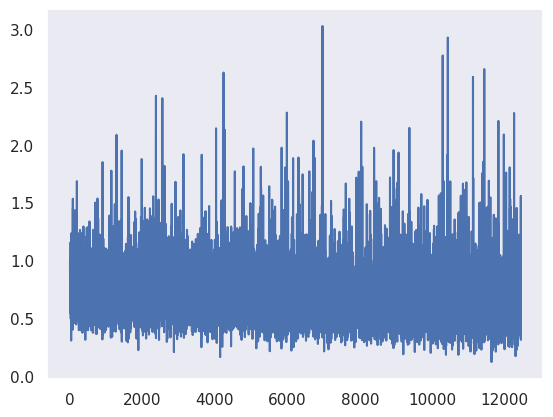

In [41]:
plt.plot(train_losses)

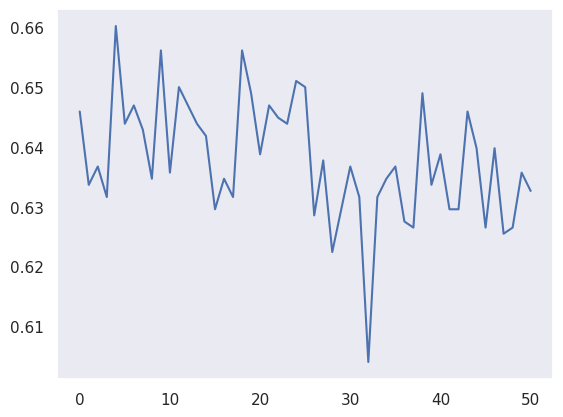

In [42]:
plt.plot(test_accuracy)

In [43]:
best_epoch

99